The following conditions apply:

 - env = biomass_zonal
 - data merged_slats_field_agb_dp1_start.csv


# -------------------------------------------------------------------------------------------------------



In [1]:

%matplotlib inline


import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.ensemble import AdaBoostRegressor as abr
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.model_selection import train_test_split
import scipy.stats as sc
import textwrap

# stats module
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import explained_variance_score
%matplotlib inline

# import plotting and stats modules
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
import pandas as pd

# Set option to display floating-point numbers without scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from bokeh.io import output_notebook, output_file
from bokeh.plotting import save # figure, show, 
#%matplotlib inline

# Bokeh Libraries
from bokeh.plotting import figure, show
from bokeh.io import output_file
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool


### Import data

In [2]:
drive = "D"
date = "adb_all_data_sddv4_mean"
# mdl = "rfr"
# model_name = "Random Forrest Regressor"


mdl = "abr"
model_name = "AdaBoost Regressor"

#mdl = "gbr"
#model_name = "Gradient Boosting Regressor"
rs = 0

In [3]:
csv_file = r"C:\Users\robot\projects\biomass\collated_zonal_stats\dry_mask\dp1_dbi_si_dry_mask_density.csv"

## Set output file locations

In [4]:
output = r"C:\Users\robot\projects\biomass\model\{}".format(date)
output_ = os.path.join(output, "plots")

In [5]:
if not os.path.isdir(output):
    os.mkdir(output)
if not os.path.isdir(output_):
    os.mkdir(output_)

In [6]:
# read as dataframe and copy
df1 = pd.read_csv(csv_file, header=0) # the first row is read in as the header for you columns
print(df1.shape) # prints out the number of rows and columns in your csv file 
print(list(df1))
df1.shape
#df2 = df1.copy()

(200, 215)
['uid', 'site_clean', 'date', 'lon_gda94', 'lat_gda94', 'geometry', 'bio_l_kg1ha', 'bio_t_kg1ha', 'bio_b_kg1ha', 'bio_w_kg1ha', 'bio_br_kg1ha', 'bio_s_kg1ha', 'bio_r_kg1ha', 'bio_agb_kg1ha', 'c_l_kg1ha', 'c_t_kg1ha', 'c_b_kg1ha', 'c_w_kg1ha', 'c_br_kg1ha', 'c_s_kg1ha', 'c_r_kg1ha', 'c_agb_kg1ha', 'basal_dt', 'b1_wfp_dry_min', 'b1_wfp_dry_max', 'b1_wfp_dry_mean', 'b1_wfp_dry_std', 'b1_wfp_dry_med', 'b1_wfp_dry_p25', 'b1_wfp_dry_p50', 'b1_wfp_dry_p75', 'b1_wfp_dry_p95', 'b1_wfp_dry_p99', 'b1_wdc_dry_major', 'b1_wdc_dry_minor', 'b1_n17_dry_major', 'b1_n17_dry_minor', 'b1_hsd_min', 'b1_hsd_max', 'b1_hsd_mean', 'b1_hsd_std', 'b1_hsd_med', 'b1_hsd_p25', 'b1_hsd_p50', 'b1_hsd_p75', 'b1_hsd_p95', 'b1_hsd_p99', 'b1_hmc_min', 'b1_hmc_max', 'b1_hmc_mean', 'b1_hmc_std', 'b1_hmc_med', 'b1_hmc_p25', 'b1_hmc_p50', 'b1_hmc_p75', 'b1_hmc_p95', 'b1_hmc_p99', 'b1_hcv_min', 'b1_hcv_max', 'b1_hcv_mean', 'b1_hcv_std', 'b1_hcv_med', 'b1_hcv_p25', 'b1_hcv_p50', 'b1_hcv_p75', 'b1_hcv_p95', 'b1_hcv_p

(200, 215)

In [7]:
# Check for null values in each column
columns_with_nulls = df1.columns[df1.isnull().any()]
columns_with_nulls

Index(['b1_wfp_dry_min', 'b1_wfp_dry_max', 'b1_wfp_dry_mean', 'b1_wfp_dry_std',
       'b1_wfp_dry_med', 'b1_wfp_dry_p25', 'b1_wfp_dry_p50', 'b1_wfp_dry_p75',
       'b1_wfp_dry_p95', 'b1_wfp_dry_p99', 'b1_wdc_dry_major',
       'b1_wdc_dry_minor', 'b1_ccw_dry_min', 'b1_ccw_dry_max',
       'b1_ccw_dry_mean', 'b1_ccw_dry_std', 'b1_ccw_dry_med', 'b1_ccw_dry_p25',
       'b1_ccw_dry_p50', 'b1_ccw_dry_p75', 'b1_ccw_dry_p95', 'b1_ccw_dry_p99',
       'b1_dp1fm_dry_min', 'b2_dp1fm_dry_min'],
      dtype='object')

## Fill missing values

In [8]:
# Fill missing values with the minimum value of each column
df1 = df1.apply(lambda col: col.fillna(col.min()), axis=0)

In [9]:
# Check for null values in each column
columns_with_nulls = df1.columns[df1.isnull().any()]
columns_with_nulls

Index([], dtype='object')

In [10]:
df = df1.rename(columns={'bio_agb_kg1ha': 'target'})

In [11]:
df

uid  site_clean      date  lon_gda94  lat_gda94  \
0      1  agb02.2012  20120714     131.01     -12.65   
1      2  amg01.2012  20120619     134.05     -16.38   
2      3  amg03.2012  20120620     134.03     -16.78   
3      4  amg05.2012  20120621     134.09     -16.73   
4      5  amg06.2012  20120621     134.09     -16.69   
..   ...         ...       ...        ...        ...   
195  196   wh07.2012  20120725     130.86     -17.73   
196  197   wh08.2012  20120725     130.86     -17.80   
197  198   wh09.2012  20120725     130.83     -17.85   
198  199   wh13.2012  20120726     130.98     -17.48   
199  200   wh15.2012  20120727     130.95     -17.57   

                                         geometry  bio_l_kg1ha  bio_t_kg1ha  \
0    POINT (131.0051902997444 -12.64729111005121)         0.00         0.00   
1    POINT (134.0516779247276 -16.38097178688785)       413.63       448.55   
2    POINT (134.0316178323347 -16.77900462426776)         0.00         0.00   
3    POINT (134.0906366351442 -16.73125956338392)       833.61       906.46   
4    POINT (134.0878483341189 -16.69423322370554)       104.28       113.39   
..                                            ...          ...          ...   
195  POINT (130.8552048292092 -17.73062671109738)         8.12         8.83   
196  POINT (130.8648461304422 -17.80031196047614)         0.00         0.00   
197   POINT (130.827555028162 -17.84950593035178)         0.00         0.00   
198  POINT (130.9793829359707 -17.48492706190497)         0.00         0.00   
199  POINT (130.9483094345248 -17.57351353150741)         0.00         0.00   

     bio_b_kg1ha  bio_w_kg1ha  ...  dbifmdry_NDGI  dbifmdry_RI  dbifmdry_NBR  \
0           0.00         0.00  ...       -1538462      1538462       1964774   
1        1310.22      3748.31  ...       -1341991      1341991       2881356   
2           0.00         0.00  ...       -2629287      2629287       1429988   
3        3541.75     11522.38  ...       -1173184      1173184       2241024   
4         443.05      1441.38  ...       -1255729      1255729       2197205   
..           ...          ...  ...            ...          ...           ...   
195        34.49       112.20  ...       -1751216      1751216       -653378   
196         0.00         0.00  ...       -1711085      1711085        742810   
197         0.00         0.00  ...       -1939035      1939035       2065458   
198         0.00         0.00  ...       -1670989      1670989       1488840   
199         0.00         0.00  ...       -1938944      1938944       1487304   

     dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  dbifmdry_DVI  \
0          -383207        1409000         2022182       1205000   
1          -338983        1438000         2197130       1283000   
2         -1452928        1629000         1787156       1146000   
3          -539075        1088000         1753382        983000   
4          -836979        1094000         1668140        957000   
..             ...            ...             ...           ...   
195       -1646321        1345000         1214483        841000   
196        -791061        1523000         1587738       1080000   
197        -545833        1776000         1952017       1318000   
198        -458342        1218000         1131930        767000   
199        -952381        1398000         1389131        928000   

     dbifmdry_SAVI  dbifmdry_NDVI  dbifmdry_MSR  
0          2336781        4405850       6047316  
1          2534571        4947937       7201101  
2          2030475        3306405       4099401  
3          2111557        4957136       7222079  
4          1997912        4379863       5995724  
..             ...            ...           ...  
195        1367776        1991475       2236580  
196        1777875        2626459       3085874  
197        2163493        3185114       3909535  
198        1290232        1958131       2194196  
199        1577873        2428048       2811428  

[200 rows x 215 

In [12]:
columns_with_nulls = df.columns[df.isnull().any()]
columns_with_nulls

Index([], dtype='object')

## Main only

In [13]:
#main major and h99 
var_ = date

df_columns = list(df.columns)
keep = ['site_clean', "target", 
        "mean", 
        "major", 
        #"p99", 
        "GNDVI", "MSR", "NBR", "_NDVI", "CVI", "GDVI", "GSAVI",
        "NDGI","RI", "NDII", "MSAVI", "SAVI"
       'r32', 'r42', 'r43',
         'r52', 'r53', 'r54', 'r62', 'r63', 'r64', 'r65',
         ]
header = [ele for ele in df_columns for x in keep if x in ele]
df2 = df[header]

In [14]:
print(df2.columns.tolist())

['site_clean', 'target', 'b1_wfp_dry_mean', 'b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_hsd_mean', 'b1_hmc_mean', 'b1_hcv_mean', 'b1_h99_mean', 'b1_fdc_dry_major', 'b1_ccw_dry_mean', 'b1_dbifm_dry_mean', 'b1_dp1fm_dry_mean', 'b2_dp1fm_dry_mean', 'b3_dp1fm_dry_mean', 'b2_dbifm_dry_mean', 'b3_dbifm_dry_mean', 'b4_dbifm_dry_mean', 'b5_dbifm_dry_mean', 'b6_dbifm_dry_mean', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_GSAVI', 'dbifmdry_GNDVI', 'dbifmdry_CVI', 'dbifmdry_NDGI', 'dbifmdry_RI', 'dbifmdry_NBR', 'dbifmdry_NDII', 'dbifmdry_GDVI', 'dbifmdry_MSAVI', 'dbifmdry_NDVI', 'dbifmdry_MSR']


In [15]:
df_columns = list(df.columns)
keep = ['major']
       
classified_cols = [ele for ele in df_columns for x in keep if x in ele]
print(classified_cols)

['b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_fdc_dry_major']


In [16]:
# df2 = df2[['site_clean', 'target', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_NDVI',
# 
#  ]]
# print(df2.columns.tolist())
# var_ = "_ratio_NDVI_only_test"

In [17]:
df2.columns.tolist()

['site_clean',
 'target',
 'b1_wfp_dry_mean',
 'b1_wdc_dry_major',
 'b1_n17_dry_major',
 'b1_hsd_mean',
 'b1_hmc_mean',
 'b1_hcv_mean',
 'b1_h99_mean',
 'b1_fdc_dry_major',
 'b1_ccw_dry_mean',
 'b1_dbifm_dry_mean',
 'b1_dp1fm_dry_mean',
 'b2_dp1fm_dry_mean',
 'b3_dp1fm_dry_mean',
 'b2_dbifm_dry_mean',
 'b3_dbifm_dry_mean',
 'b4_dbifm_dry_mean',
 'b5_dbifm_dry_mean',
 'b6_dbifm_dry_mean',
 'dbifmdry_r42',
 'dbifmdry_r43',
 'dbifmdry_r52',
 'dbifmdry_r53',
 'dbifmdry_r54',
 'dbifmdry_r62',
 'dbifmdry_r63',
 'dbifmdry_r64',
 'dbifmdry_r65',
 'dbifmdry_GSAVI',
 'dbifmdry_GNDVI',
 'dbifmdry_CVI',
 'dbifmdry_NDGI',
 'dbifmdry_RI',
 'dbifmdry_NBR',
 'dbifmdry_NDII',
 'dbifmdry_GDVI',
 'dbifmdry_MSAVI',
 'dbifmdry_NDVI',
 'dbifmdry_MSR']

### Logical selection

In [18]:
# Check for duplicate columns and print them
duplicate_columns = df2.columns[df2.columns.duplicated()]

if duplicate_columns.any():
    print("Duplicate columns found:")
    for col in duplicate_columns:
        print(col)
else:
    print("No duplicate columns found.")

No duplicate columns found.


## Remove site values which seem like outliers

Detect outliers using Z score on all columns including Target


In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   site_clean         200 non-null    object 
 1   target             200 non-null    float64
 2   b1_wfp_dry_mean    200 non-null    float64
 3   b1_wdc_dry_major   200 non-null    float64
 4   b1_n17_dry_major   200 non-null    float64
 5   b1_hsd_mean        200 non-null    float64
 6   b1_hmc_mean        200 non-null    float64
 7   b1_hcv_mean        200 non-null    float64
 8   b1_h99_mean        200 non-null    float64
 9   b1_fdc_dry_major   200 non-null    float64
 10  b1_ccw_dry_mean    200 non-null    float64
 11  b1_dbifm_dry_mean  200 non-null    float64
 12  b1_dp1fm_dry_mean  200 non-null    float64
 13  b2_dp1fm_dry_mean  200 non-null    float64
 14  b3_dp1fm_dry_mean  200 non-null    float64
 15  b2_dbifm_dry_mean  200 non-null    float64
 16  b3_dbifm_dry_mean  200 non

In [20]:
import pandas as pd
from scipy.stats import zscore
import numpy as np

# Function to detect outliers using Z-score
def detect_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 4).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types
df = df2.copy()

# Detect outliers
outliers = detect_outliers(df)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# If you want to highlight these outliers in the original DataFrame
df_highlighted = df.copy()

for col in df.select_dtypes(include=[np.number]).columns:
    df_highlighted[col + '_outlier'] = np.where(outliers, 'Outlier', 'Normal')

print("Original DataFrame with Outliers Highlighted:")
df_highlighted

output_ = os.path.join(output, f"dry_mask_{var_}_outlier.csv")
df_highlighted.to_csv(output_, index=False)

Detected Outliers:
          site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  \
20        auv07.2012     0.00             1.00              1.00   
40         ep01.2012 18757.20            85.08              4.00   
132  ntamgd0002.2014     0.00             1.00              1.00   
167      site21.2023 43331.12            60.56              3.00   

     b1_n17_dry_major  b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  \
20              14.00       100.37       100.47       112.70       100.89   
40               1.00       102.77       107.54       138.38       113.30   
132             14.00       100.94       101.70       128.66       103.49   
167              1.00       105.12       112.38       142.76       119.99   

     b1_fdc_dry_major  ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  \
20               1.00  ...         3182178      29832240       -2135036   
40               4.00  ...         7035081      42981955        1441048   
132              1.00  ...   

In [21]:
# Function to detect outliers using Z-score
def detect_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 4).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types
df = df2.copy()

# Detect outliers
outliers = detect_outliers(df)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# Drop rows that contain outliers
df_cleaned = df[~outliers]

print("Cleaned DataFrame (without outliers):")
df_cleaned

Detected Outliers:
          site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  \
20        auv07.2012     0.00             1.00              1.00   
40         ep01.2012 18757.20            85.08              4.00   
132  ntamgd0002.2014     0.00             1.00              1.00   
167      site21.2023 43331.12            60.56              3.00   

     b1_n17_dry_major  b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  \
20              14.00       100.37       100.47       112.70       100.89   
40               1.00       102.77       107.54       138.38       113.30   
132             14.00       100.94       101.70       128.66       103.49   
167              1.00       105.12       112.38       142.76       119.99   

     b1_fdc_dry_major  ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  \
20               1.00  ...         3182178      29832240       -2135036   
40               4.00  ...         7035081      42981955        1441048   
132              1.00  ...   

site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  b1_n17_dry_major  \
0    agb02.2012     0.00            45.89              3.00              4.00   
1    amg01.2012  8376.22            44.00              3.00              1.00   
2    amg03.2012     0.00             3.33              1.00              1.00   
3    amg05.2012 24670.80            34.83              3.00              4.00   
4    amg06.2012  3086.16            29.78              2.00              4.00   
..          ...      ...              ...               ...               ...   
195   wh07.2012   240.24             2.25              1.00             10.00   
196   wh08.2012     0.00            11.92              2.00              7.00   
197   wh09.2012     0.00             7.89              1.00              1.00   
198   wh13.2012     0.00             6.00              1.00              6.00   
199   wh15.2012     0.00             1.00              1.00              3.00   

     b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  b1_fdc_dry_major  \
0         103.63       107.13       151.32       114.13              3.00   
1         103.88       106.25       169.41       113.93              3.00   
2         101.58       103.49       137.70       106.57              1.00   
3         103.14       105.14       157.61       111.49              3.00   
4         103.02       104.74       163.29       110.91              3.00   
..           ...          ...          ...          ...               ...   
195       100.94       102.21       140.04       103.96              1.00   
196       102.08       103.29       156.05       107.97              2.00   
197       100.82       101.59       144.41       103.81              2.00   
198       101.01       101.96       131.00       104.01              1.00   
199       100.89       101.59       138.83       103.90              1.00   

     ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  dbifmdry_RI  \
0    ...         5566970      47885270       -1538462      1538462   
1    ...         5898277      50775600       -1341991      1341991   
2    ...         5460945      58363315       -2629287      2629287   
3    ...         5793397      47524435       -1173184      1173184   
4    ...         5341797      42394332       -1255729      1255729   
..   ...             ...           ...            ...          ...   
195  ...         3616564      30388263       -1751216      1751216   
196  ...         4150995      34182549       -1711085      1711085   
197  ...         4826087      42441388       -1939035      1939035   
198  ...         3514137      29196771       -1670989      1670989   
199  ...         4170644      36003359       -1938944      1938944   

     dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         1964774        -383207        1409000         2022182   
1         2881356        -338983        1438000         2197130   
2         1429988       -1452928        1629000         1787156   
3         2241024        -539075        1088000         1753382   
4         2197205        -836979        1094000         1668140   
..            ...            ...            ...             ...   
195       -653378       -1646321        1345000         1214483   
196        742810        -791061        1523000         1587738   
197       2065458        -545833        1776000         1952017   
198       1488840        -458342        1218000         1131930   
199       1487304        -952381        1398000         1389131   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4405850       6047316  
1          4947937       7201101  
2          3306405       4099401  
3          4957136       7222079  
4          4379863       5995724  
..             ...           ...  
195        1991475       2236580  
196        2626459       3085874  
197        3185114       3909535  
198        1958131       2194196  
199        2428048       2811428  

[196 rows x 40 columns]

In [22]:
df_cleaned

site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  b1_n17_dry_major  \
0    agb02.2012     0.00            45.89              3.00              4.00   
1    amg01.2012  8376.22            44.00              3.00              1.00   
2    amg03.2012     0.00             3.33              1.00              1.00   
3    amg05.2012 24670.80            34.83              3.00              4.00   
4    amg06.2012  3086.16            29.78              2.00              4.00   
..          ...      ...              ...               ...               ...   
195   wh07.2012   240.24             2.25              1.00             10.00   
196   wh08.2012     0.00            11.92              2.00              7.00   
197   wh09.2012     0.00             7.89              1.00              1.00   
198   wh13.2012     0.00             6.00              1.00              6.00   
199   wh15.2012     0.00             1.00              1.00              3.00   

     b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  b1_fdc_dry_major  \
0         103.63       107.13       151.32       114.13              3.00   
1         103.88       106.25       169.41       113.93              3.00   
2         101.58       103.49       137.70       106.57              1.00   
3         103.14       105.14       157.61       111.49              3.00   
4         103.02       104.74       163.29       110.91              3.00   
..           ...          ...          ...          ...               ...   
195       100.94       102.21       140.04       103.96              1.00   
196       102.08       103.29       156.05       107.97              2.00   
197       100.82       101.59       144.41       103.81              2.00   
198       101.01       101.96       131.00       104.01              1.00   
199       100.89       101.59       138.83       103.90              1.00   

     ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  dbifmdry_RI  \
0    ...         5566970      47885270       -1538462      1538462   
1    ...         5898277      50775600       -1341991      1341991   
2    ...         5460945      58363315       -2629287      2629287   
3    ...         5793397      47524435       -1173184      1173184   
4    ...         5341797      42394332       -1255729      1255729   
..   ...             ...           ...            ...          ...   
195  ...         3616564      30388263       -1751216      1751216   
196  ...         4150995      34182549       -1711085      1711085   
197  ...         4826087      42441388       -1939035      1939035   
198  ...         3514137      29196771       -1670989      1670989   
199  ...         4170644      36003359       -1938944      1938944   

     dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         1964774        -383207        1409000         2022182   
1         2881356        -338983        1438000         2197130   
2         1429988       -1452928        1629000         1787156   
3         2241024        -539075        1088000         1753382   
4         2197205        -836979        1094000         1668140   
..            ...            ...            ...             ...   
195       -653378       -1646321        1345000         1214483   
196        742810        -791061        1523000         1587738   
197       2065458        -545833        1776000         1952017   
198       1488840        -458342        1218000         1131930   
199       1487304        -952381        1398000         1389131   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4405850       6047316  
1          4947937       7201101  
2          3306405       4099401  
3          4957136       7222079  
4          4379863       5995724  
..             ...           ...  
195        1991475       2236580  
196        2626459       3085874  
197        3185114       3909535  
198        1958131       2194196  
199        2428048       2811428  

[196 rows x 40 columns]

In [23]:
df_cleaned.shape

(196, 40)

## Detect Z score outliers on all columns except target

In [24]:
import pandas as pd
from scipy.stats import zscore
import numpy as np

# Function to detect outliers using Z-score
def detect_outliers(df, target_column):
    # Select only numeric columns except the target column
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 3).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types and 'target' is the target column
df = df2.copy()

# Define the target column
target_column = 'target'  # Replace 'target' with the name of your target column

# Detect outliers
outliers = detect_outliers(df, target_column)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# If you want to highlight these outliers in the original DataFrame
df_highlighted = df.copy()

for col in df.select_dtypes(include=[np.number]).drop(columns=[target_column]).columns:
    df_highlighted[col + '_outlier'] = np.where(outliers, 'Outlier', 'Normal')

print("Original DataFrame with Outliers Highlighted:")
print(df_highlighted)

output_ = os.path.join(output, f"dry_mask_{var_}_not_target_outlier.csv")
df_highlighted.to_csv(output_, index=False)

Detected Outliers:
          site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  \
5         amg08.2012 29521.80            57.22              3.00   
20        auv07.2012     0.00             1.00              1.00   
40         ep01.2012 18757.20            85.08              4.00   
48        hsf01.2012 25701.69            65.25              3.00   
50       hshr01.2012 35199.71            72.56              4.00   
62       legu03.2012     0.00             1.50              1.00   
76        lit01.2013 25585.07            67.42              3.00   
84        nt004.2012     0.00            15.22              1.00   
132  ntamgd0002.2014     0.00             1.00              1.00   
142  ntastu0005.2016  8402.81            17.06              2.00   
191        wh03.2012     0.00            16.42              2.00   
192        wh04.2012     0.00            15.89              2.00   

     b1_n17_dry_major  b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  \
5                4.

In [25]:
# Function to detect outliers using Z-score
def detect_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 3).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types
df = df2.copy()

# Detect outliers
outliers = detect_outliers(df)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# Drop rows that contain outliers
df_cleaned = df[~outliers]

print("Cleaned DataFrame (without outliers):")
df_cleaned

Detected Outliers:
          site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  \
5         amg08.2012 29521.80            57.22              3.00   
20        auv07.2012     0.00             1.00              1.00   
40         ep01.2012 18757.20            85.08              4.00   
48        hsf01.2012 25701.69            65.25              3.00   
50       hshr01.2012 35199.71            72.56              4.00   
62       legu03.2012     0.00             1.50              1.00   
76        lit01.2013 25585.07            67.42              3.00   
84        nt004.2012     0.00            15.22              1.00   
132  ntamgd0002.2014     0.00             1.00              1.00   
142  ntastu0005.2016  8402.81            17.06              2.00   
167      site21.2023 43331.12            60.56              3.00   
191        wh03.2012     0.00            16.42              2.00   
192        wh04.2012     0.00            15.89              2.00   

     b1_n17_dry_major  b1_hs

site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  b1_n17_dry_major  \
0    agb02.2012     0.00            45.89              3.00              4.00   
1    amg01.2012  8376.22            44.00              3.00              1.00   
2    amg03.2012     0.00             3.33              1.00              1.00   
3    amg05.2012 24670.80            34.83              3.00              4.00   
4    amg06.2012  3086.16            29.78              2.00              4.00   
..          ...      ...              ...               ...               ...   
195   wh07.2012   240.24             2.25              1.00             10.00   
196   wh08.2012     0.00            11.92              2.00              7.00   
197   wh09.2012     0.00             7.89              1.00              1.00   
198   wh13.2012     0.00             6.00              1.00              6.00   
199   wh15.2012     0.00             1.00              1.00              3.00   

     b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  b1_fdc_dry_major  \
0         103.63       107.13       151.32       114.13              3.00   
1         103.88       106.25       169.41       113.93              3.00   
2         101.58       103.49       137.70       106.57              1.00   
3         103.14       105.14       157.61       111.49              3.00   
4         103.02       104.74       163.29       110.91              3.00   
..           ...          ...          ...          ...               ...   
195       100.94       102.21       140.04       103.96              1.00   
196       102.08       103.29       156.05       107.97              2.00   
197       100.82       101.59       144.41       103.81              2.00   
198       101.01       101.96       131.00       104.01              1.00   
199       100.89       101.59       138.83       103.90              1.00   

     ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  dbifmdry_RI  \
0    ...         5566970      47885270       -1538462      1538462   
1    ...         5898277      50775600       -1341991      1341991   
2    ...         5460945      58363315       -2629287      2629287   
3    ...         5793397      47524435       -1173184      1173184   
4    ...         5341797      42394332       -1255729      1255729   
..   ...             ...           ...            ...          ...   
195  ...         3616564      30388263       -1751216      1751216   
196  ...         4150995      34182549       -1711085      1711085   
197  ...         4826087      42441388       -1939035      1939035   
198  ...         3514137      29196771       -1670989      1670989   
199  ...         4170644      36003359       -1938944      1938944   

     dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         1964774        -383207        1409000         2022182   
1         2881356        -338983        1438000         2197130   
2         1429988       -1452928        1629000         1787156   
3         2241024        -539075        1088000         1753382   
4         2197205        -836979        1094000         1668140   
..            ...            ...            ...             ...   
195       -653378       -1646321        1345000         1214483   
196        742810        -791061        1523000         1587738   
197       2065458        -545833        1776000         1952017   
198       1488840        -458342        1218000         1131930   
199       1487304        -952381        1398000         1389131   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4405850       6047316  
1          4947937       7201101  
2          3306405       4099401  
3          4957136       7222079  
4          4379863       5995724  
..             ...           ...  
195        1991475       2236580  
196        2626459       3085874  
197        3185114       3909535  
198        1958131       2194196  
199        2428048       2811428  

[187 rows x 40 columns]

In [26]:
df_cleaned

site_clean   target  b1_wfp_dry_mean  b1_wdc_dry_major  b1_n17_dry_major  \
0    agb02.2012     0.00            45.89              3.00              4.00   
1    amg01.2012  8376.22            44.00              3.00              1.00   
2    amg03.2012     0.00             3.33              1.00              1.00   
3    amg05.2012 24670.80            34.83              3.00              4.00   
4    amg06.2012  3086.16            29.78              2.00              4.00   
..          ...      ...              ...               ...               ...   
195   wh07.2012   240.24             2.25              1.00             10.00   
196   wh08.2012     0.00            11.92              2.00              7.00   
197   wh09.2012     0.00             7.89              1.00              1.00   
198   wh13.2012     0.00             6.00              1.00              6.00   
199   wh15.2012     0.00             1.00              1.00              3.00   

     b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  b1_fdc_dry_major  \
0         103.63       107.13       151.32       114.13              3.00   
1         103.88       106.25       169.41       113.93              3.00   
2         101.58       103.49       137.70       106.57              1.00   
3         103.14       105.14       157.61       111.49              3.00   
4         103.02       104.74       163.29       110.91              3.00   
..           ...          ...          ...          ...               ...   
195       100.94       102.21       140.04       103.96              1.00   
196       102.08       103.29       156.05       107.97              2.00   
197       100.82       101.59       144.41       103.81              2.00   
198       101.01       101.96       131.00       104.01              1.00   
199       100.89       101.59       138.83       103.90              1.00   

     ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  dbifmdry_RI  \
0    ...         5566970      47885270       -1538462      1538462   
1    ...         5898277      50775600       -1341991      1341991   
2    ...         5460945      58363315       -2629287      2629287   
3    ...         5793397      47524435       -1173184      1173184   
4    ...         5341797      42394332       -1255729      1255729   
..   ...             ...           ...            ...          ...   
195  ...         3616564      30388263       -1751216      1751216   
196  ...         4150995      34182549       -1711085      1711085   
197  ...         4826087      42441388       -1939035      1939035   
198  ...         3514137      29196771       -1670989      1670989   
199  ...         4170644      36003359       -1938944      1938944   

     dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         1964774        -383207        1409000         2022182   
1         2881356        -338983        1438000         2197130   
2         1429988       -1452928        1629000         1787156   
3         2241024        -539075        1088000         1753382   
4         2197205        -836979        1094000         1668140   
..            ...            ...            ...             ...   
195       -653378       -1646321        1345000         1214483   
196        742810        -791061        1523000         1587738   
197       2065458        -545833        1776000         1952017   
198       1488840        -458342        1218000         1131930   
199       1487304        -952381        1398000         1389131   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4405850       6047316  
1          4947937       7201101  
2          3306405       4099401  
3          4957136       7222079  
4          4379863       5995724  
..             ...           ...  
195        1991475       2236580  
196        2626459       3085874  
197        3185114       3909535  
198        1958131       2194196  
199        2428048       2811428  

[187 rows x 40 columns]

In [27]:
df_cleaned.shape

(187, 40)

In [28]:
df2 = df_cleaned

### Set variables to plot

In [29]:
# predicted value is x
value_x = 'target'
# variable is y
value_y = "b1_wfp_mean"
value_a = 'b2_dp1fm_dry_mean'
value_b = 'b1_h99_mean'


site = 'site_clean'


In [30]:
value_y

'b1_wfp_mean'

In [31]:
df2.shape

(187, 40)

In [32]:
output_int = os.path.join(output, "inter")
if not os.path.isdir(output_):
    os.mkdir(output_int)


In [33]:
def save_fig(value_x, value_y):
    # Output to file
    output_file(os.path.join(output_int,'all_sites_{0}_{1}.html'.format(value_x, value_y)),
                title='Relationship between {0} and {1}'.format(value_x.replace("_", " "), value_y.replace("_", " ")))


    #Specify the selection tools to be made available
    select_tools = ['box_select', 'lasso_select', 'poly_select', 'tap', 'zoom_in', 'zoom_out', 'wheel_zoom', 'reset']

    #print(test)
    # Format the tooltip
    tooltips = [
                ('Site', '@site_clean'),
                (value_x, '@{0}'.format(value_x)),
                (value_y, '@{0}'.format(value_y)),   
                (value_a, '@{0}'.format(value_a)),
                (value_b, '@{0}'.format(value_b)) 
               ]

    # Create the figure
    fig = figure(plot_height=400,
                 plot_width=1500,
                 y_axis_label= value_y.replace("_", " "), 
                 x_axis_label= value_x.replace("_", " "),
                 title='Relationship between {0} and {1}'.format(value_x.replace("_", " "), value_y.replace("_", " ")),
                 toolbar_location='below',
                 tools=select_tools)

    # # Format the y-axis tick label
    fig.yaxis[0].formatter = NumeralTickFormatter(format='0')

    # Add square representing each site
    fig.square(x= value_x,
               y= value_y,
               source=df2.round(4),
               size=5,
               color='royalblue',
               selection_color='deepskyblue',
               nonselection_color='lightgray',
               nonselection_alpha=0.3)

    # Add the HoverTool to the figure
    fig.add_tools(HoverTool(tooltips=tooltips))

    # Visualize
    save(fig)

In [34]:
df2.shape

(187, 40)

In [35]:
column_list = df2.columns.to_list()
y_list = column_list[3:]
value_x = column_list[1:2][0]


for i in y_list:
    value_y = i
    save_fig(value_x, value_y)
    

In [36]:
print(column_list[3:])
print(column_list[1:2])

['b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_hsd_mean', 'b1_hmc_mean', 'b1_hcv_mean', 'b1_h99_mean', 'b1_fdc_dry_major', 'b1_ccw_dry_mean', 'b1_dbifm_dry_mean', 'b1_dp1fm_dry_mean', 'b2_dp1fm_dry_mean', 'b3_dp1fm_dry_mean', 'b2_dbifm_dry_mean', 'b3_dbifm_dry_mean', 'b4_dbifm_dry_mean', 'b5_dbifm_dry_mean', 'b6_dbifm_dry_mean', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_GSAVI', 'dbifmdry_GNDVI', 'dbifmdry_CVI', 'dbifmdry_NDGI', 'dbifmdry_RI', 'dbifmdry_NBR', 'dbifmdry_NDII', 'dbifmdry_GDVI', 'dbifmdry_MSAVI', 'dbifmdry_NDVI', 'dbifmdry_MSR']
['target']


### One-Hot Encoding (for Tree-based Models)

In [37]:
# add columns that contain class data n17
classified_cols

['b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_fdc_dry_major']

In [38]:
df2.columns

Index(['site_clean', 'target', 'b1_wfp_dry_mean', 'b1_wdc_dry_major',
       'b1_n17_dry_major', 'b1_hsd_mean', 'b1_hmc_mean', 'b1_hcv_mean',
       'b1_h99_mean', 'b1_fdc_dry_major', 'b1_ccw_dry_mean',
       'b1_dbifm_dry_mean', 'b1_dp1fm_dry_mean', 'b2_dp1fm_dry_mean',
       'b3_dp1fm_dry_mean', 'b2_dbifm_dry_mean', 'b3_dbifm_dry_mean',
       'b4_dbifm_dry_mean', 'b5_dbifm_dry_mean', 'b6_dbifm_dry_mean',
       'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53',
       'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64',
       'dbifmdry_r65', 'dbifmdry_GSAVI', 'dbifmdry_GNDVI', 'dbifmdry_CVI',
       'dbifmdry_NDGI', 'dbifmdry_RI', 'dbifmdry_NBR', 'dbifmdry_NDII',
       'dbifmdry_GDVI', 'dbifmdry_MSAVI', 'dbifmdry_NDVI', 'dbifmdry_MSR'],
      dtype='object')

In [39]:
for i in classified_cols:
    df2 = pd.get_dummies(df2, columns=[i], prefix=f'{i}_en')

In [40]:
#df_encoded
df2

site_clean   target  b1_wfp_dry_mean  b1_hsd_mean  b1_hmc_mean  \
0    agb02.2012     0.00            45.89       103.63       107.13   
1    amg01.2012  8376.22            44.00       103.88       106.25   
2    amg03.2012     0.00             3.33       101.58       103.49   
3    amg05.2012 24670.80            34.83       103.14       105.14   
4    amg06.2012  3086.16            29.78       103.02       104.74   
..          ...      ...              ...          ...          ...   
195   wh07.2012   240.24             2.25       100.94       102.21   
196   wh08.2012     0.00            11.92       102.08       103.29   
197   wh09.2012     0.00             7.89       100.82       101.59   
198   wh13.2012     0.00             6.00       101.01       101.96   
199   wh15.2012     0.00             1.00       100.89       101.59   

     b1_hcv_mean  b1_h99_mean  b1_ccw_dry_mean  b1_dbifm_dry_mean  \
0         151.32       114.13            68.00             373.67   
1         169.41       113.93            66.00             292.44   
2         137.70       106.57             6.92             412.33   
3         157.61       111.49            54.75             223.58   
4         163.29       110.91            48.33             259.56   
..           ...          ...              ...                ...   
195       140.04       103.96             2.25             738.67   
196       156.05       107.97            21.25             692.08   
197       144.41       103.81            14.22             582.56   
198       131.00       104.01            11.00             710.88   
199       138.83       103.90             1.00             625.56   

     b1_dp1fm_dry_mean  ...  b1_n17_dry_major_en_4.0  b1_n17_dry_major_en_5.0  \
0                10.67  ...                        1                        0   
1                 1.33  ...                        0                        0   
2                 0.67  ...                        0                        0   
3                 8.75  ...                        1                        0   
4                 5.22  ...                        1                        0   
..                 ...  ...                      ...                      ...   
195              35.33  ...                        0                        0   
196              30.33  ...                        0                        0   
197               1.78  ...                        0                        0   
198              21.38  ...                        0                        0   
199               5.78  ...                        0                        0   

     b1_n17_dry_major_en_6.0  b1_n17_dry_major_en_7.0  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   
..                       ...                      ...   
195                        0                        0   
196                        0                        1   
197                        0                        0   
198                        1                        0   
199                        0                        0   

     b1_n17_dry_major_en_8.0  b1_n17_dry_major_en_10.0  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   
..                       ...                       ...   
195                        0                         1   
196                        0                         0   
197                        0                         0   
198                        0                         0   
199                        

## Choose which data set to run the models from

In [41]:
df_ml = df2

In [42]:
# drop some of the unwanted values
df_ml.drop(['site_clean',], axis=1, inplace=True)
#df_ml.drop(['fpca2_imdate'], axis=1, inplace=True)

In [43]:
print(list(df_ml))

['target', 'b1_wfp_dry_mean', 'b1_hsd_mean', 'b1_hmc_mean', 'b1_hcv_mean', 'b1_h99_mean', 'b1_ccw_dry_mean', 'b1_dbifm_dry_mean', 'b1_dp1fm_dry_mean', 'b2_dp1fm_dry_mean', 'b3_dp1fm_dry_mean', 'b2_dbifm_dry_mean', 'b3_dbifm_dry_mean', 'b4_dbifm_dry_mean', 'b5_dbifm_dry_mean', 'b6_dbifm_dry_mean', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_GSAVI', 'dbifmdry_GNDVI', 'dbifmdry_CVI', 'dbifmdry_NDGI', 'dbifmdry_RI', 'dbifmdry_NBR', 'dbifmdry_NDII', 'dbifmdry_GDVI', 'dbifmdry_MSAVI', 'dbifmdry_NDVI', 'dbifmdry_MSR', 'b1_wdc_dry_major_en_1.0', 'b1_wdc_dry_major_en_2.0', 'b1_wdc_dry_major_en_3.0', 'b1_n17_dry_major_en_1.0', 'b1_n17_dry_major_en_2.0', 'b1_n17_dry_major_en_3.0', 'b1_n17_dry_major_en_4.0', 'b1_n17_dry_major_en_5.0', 'b1_n17_dry_major_en_6.0', 'b1_n17_dry_major_en_7.0', 'b1_n17_dry_major_en_8.0', 'b1_n17_dry_major_en_10.0', 'b1_n17_dry_major_en_11.0', 'b1_fdc_dry_major_en

In [44]:
df_ml.shape

(187, 52)

In [45]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 199
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    187 non-null    float64
 1   b1_wfp_dry_mean           187 non-null    float64
 2   b1_hsd_mean               187 non-null    float64
 3   b1_hmc_mean               187 non-null    float64
 4   b1_hcv_mean               187 non-null    float64
 5   b1_h99_mean               187 non-null    float64
 6   b1_ccw_dry_mean           187 non-null    float64
 7   b1_dbifm_dry_mean         187 non-null    float64
 8   b1_dp1fm_dry_mean         187 non-null    float64
 9   b2_dp1fm_dry_mean         187 non-null    float64
 10  b3_dp1fm_dry_mean         187 non-null    float64
 11  b2_dbifm_dry_mean         187 non-null    float64
 12  b3_dbifm_dry_mean         187 non-null    float64
 13  b4_dbifm_dry_mean         187 non-null    float64
 14  b5_dbifm_d

## Reduce level of 0 values is this cell needed?

## Drop AGB numbers which are low

In [46]:
# df2 = df2[df2['target']>0.0]
# #df2 = df2[df2['target']>1000.0]
# df2.shape

In [47]:
# columns_with_nulls = df2.columns[df2.isnull().any()]
# columns_with_nulls

## Drop AGB numbers which are high

In [48]:
# # drop the 7 tern sites that appear to be outliers
# df2 =df2[df2['target'] <= 40000]
# df2.to_csv(os.path.join(output, "{0}_lt_40000.csv".format('target')))
# #df2 =df2[df2['target'] > 40000]
# #df2.value_counts(['site_clean', value_x, value_y])

In [49]:
df_ml.shape

(187, 52)

In [50]:
#no removal
out_df = df_ml
samp = "all_data"

# # due to the number of field sites with no basal collected data is stratified
# out_df = df_ml[df_ml['target']>0.0]
# samp = "no0"
# out_df.to_csv(os.path.join(output, "more_than_0kgha.csv"))
# out_df = df_ml[df_ml['target']>=10.0]
# samp="more_t_10"
# out_df.to_csv(os.path.join(output, "more_than_10kgha.csv"))
# 
# # create a random selection of 0 - based on sample size
# sample_size = 3
# no_0_df = df_ml[df_ml['target']>0.0]
# samp = "no0"
# agb_0 = df_ml[df_ml['bio_agb_kg1ha']==0.0].sample(sample_size)
# out_df = pd.concat([no_0_df, agb_0])
# out_df.to_csv(os.path.join(output, "ml_df_0_sample_{0}kgha.csv".format(str(sample_size))))
# samp = f"some0_{sample_size}"
# 
# 
# out_df =df_ml[df_ml['target'] <= 40000]
# out_df.to_csv(os.path.join(output, "less_than_40000kgha.csv"))
# samp = "less_t_40"

In [51]:
test = out_df[out_df['target']>40000.0]
test.shape

(0, 52)

## Select the dataset to run the models from

In [52]:
# All variables
df_ml = out_df

# select variables
#df = select_df
df_ml.shape

(187, 52)

 Define if you are using all variabes or selected variables

In [53]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 199
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    187 non-null    float64
 1   b1_wfp_dry_mean           187 non-null    float64
 2   b1_hsd_mean               187 non-null    float64
 3   b1_hmc_mean               187 non-null    float64
 4   b1_hcv_mean               187 non-null    float64
 5   b1_h99_mean               187 non-null    float64
 6   b1_ccw_dry_mean           187 non-null    float64
 7   b1_dbifm_dry_mean         187 non-null    float64
 8   b1_dp1fm_dry_mean         187 non-null    float64
 9   b2_dp1fm_dry_mean         187 non-null    float64
 10  b3_dp1fm_dry_mean         187 non-null    float64
 11  b2_dbifm_dry_mean         187 non-null    float64
 12  b3_dbifm_dry_mean         187 non-null    float64
 13  b4_dbifm_dry_mean         187 non-null    float64
 14  b5_dbifm_d

In [54]:
df_ml.dropna(inplace=True)

In [55]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 199
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    187 non-null    float64
 1   b1_wfp_dry_mean           187 non-null    float64
 2   b1_hsd_mean               187 non-null    float64
 3   b1_hmc_mean               187 non-null    float64
 4   b1_hcv_mean               187 non-null    float64
 5   b1_h99_mean               187 non-null    float64
 6   b1_ccw_dry_mean           187 non-null    float64
 7   b1_dbifm_dry_mean         187 non-null    float64
 8   b1_dp1fm_dry_mean         187 non-null    float64
 9   b2_dp1fm_dry_mean         187 non-null    float64
 10  b3_dp1fm_dry_mean         187 non-null    float64
 11  b2_dbifm_dry_mean         187 non-null    float64
 12  b3_dbifm_dry_mean         187 non-null    float64
 13  b4_dbifm_dry_mean         187 non-null    float64
 14  b5_dbifm_d

In [56]:
df_ml.describe()

target  b1_wfp_dry_mean  b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  \
count   187.00           187.00       187.00       187.00       187.00   
mean   6600.97            22.64       102.77       105.19       152.11   
std    7885.74            18.04         1.36         2.73         9.98   
min       0.00             1.00       100.55       100.86       122.17   
25%       0.00             5.82       101.62       102.97       145.93   
50%    3668.79            18.67       102.65       104.48       152.80   
75%    9589.98            37.67       103.79       107.06       158.35   
max   32025.21            68.22       105.72       112.38       179.98   

       b1_h99_mean  b1_ccw_dry_mean  b1_dbifm_dry_mean  b1_dp1fm_dry_mean  \
count       187.00           187.00             187.00             187.00   
mean        110.44            34.69             429.60              10.89   
std           4.81            26.11             155.48              10.30   
min         101.91             1.00             191.00               0.00   
25%         106.33             9.39             304.25               3.32   
50%         110.21            31.33             391.06               7.33   
75%         113.95            57.67             535.12              17.05   
max         120.23            87.33             894.00              49.62   

       b2_dp1fm_dry_mean  ...  b1_n17_dry_major_en_4.0  \
count             187.00  ...                   187.00   
mean               25.58  ...                     0.16   
std                16.84  ...                     0.37   
min                 0.11  ...                     0.00   
25%                10.61  ...                     0.00   
50%                24.92  ...                     0.00   
75%                41.78  ...                     0.00   
max                62.56  ...                     1.00   

       b1_n17_dry_major_en_5.0  b1_n17_dry_major_en_6.0  \
count                   187.00                   187.00   
mean                      0.01                     0.09   
std                       0.07                     0.29   
min                       0.00                     0.00   
25%                       0.00                     0.00   
50%                       0.00                     0.00   
75%                       0.00                     0.00   
max                       1.00                     1.00   

       b1_n17_dry_major_en_7.0  b1_n17_dry_major_en_8.0  \
count                   187.00                   187.00   
mean                      0.11                     0.19   
std                       0.31                     0.39   
min                       0.00                     0.00   
25%                       0.00                     0.00   
50%                       0.00                     0.00   
75%                       0.00                     0.00   
max                       1.00                     1.00   

       b1_n17_dry_major_en_10.0  b1_n17_dry_major_en_11.0  \
count                    187.00                    187.00   
mean                       0.03                      0.02   
std                        0.16                      0.13   
min                        0.00                      0.00   
25%                        0.00                      0.00   
50%                        0.00                      0.00   
75%                        0.00                      0.00   
max                        1.00                      1.00   

       b1_fdc_dry_major_en_1.0  b1_fdc_dry_major_en_2.0  \
count                   187.00                   187.00   
mean                      0.24                     0.34   
std                       0.43                     0.47   
min                       0.00                     0.00   
25%                       0.00                     0.00   
50%                       0.00                     0.00   
75%                       0.00                     1.00   
max                       1.00        

# Scatter plots with error

In [57]:
#df_ml.to_csv(, index=False)
df_ml.to_csv(os.path.join(output, "{0}_{1}_{2}_ml_data.csv".format(var_, mdl, samp)), index=False)

In [58]:
df_ml.describe()

target  b1_wfp_dry_mean  b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  \
count   187.00           187.00       187.00       187.00       187.00   
mean   6600.97            22.64       102.77       105.19       152.11   
std    7885.74            18.04         1.36         2.73         9.98   
min       0.00             1.00       100.55       100.86       122.17   
25%       0.00             5.82       101.62       102.97       145.93   
50%    3668.79            18.67       102.65       104.48       152.80   
75%    9589.98            37.67       103.79       107.06       158.35   
max   32025.21            68.22       105.72       112.38       179.98   

       b1_h99_mean  b1_ccw_dry_mean  b1_dbifm_dry_mean  b1_dp1fm_dry_mean  \
count       187.00           187.00             187.00             187.00   
mean        110.44            34.69             429.60              10.89   
std           4.81            26.11             155.48              10.30   
min         101.91             1.00             191.00               0.00   
25%         106.33             9.39             304.25               3.32   
50%         110.21            31.33             391.06               7.33   
75%         113.95            57.67             535.12              17.05   
max         120.23            87.33             894.00              49.62   

       b2_dp1fm_dry_mean  ...  b1_n17_dry_major_en_4.0  \
count             187.00  ...                   187.00   
mean               25.58  ...                     0.16   
std                16.84  ...                     0.37   
min                 0.11  ...                     0.00   
25%                10.61  ...                     0.00   
50%                24.92  ...                     0.00   
75%                41.78  ...                     0.00   
max                62.56  ...                     1.00   

       b1_n17_dry_major_en_5.0  b1_n17_dry_major_en_6.0  \
count                   187.00                   187.00   
mean                      0.01                     0.09   
std                       0.07                     0.29   
min                       0.00                     0.00   
25%                       0.00                     0.00   
50%                       0.00                     0.00   
75%                       0.00                     0.00   
max                       1.00                     1.00   

       b1_n17_dry_major_en_7.0  b1_n17_dry_major_en_8.0  \
count                   187.00                   187.00   
mean                      0.11                     0.19   
std                       0.31                     0.39   
min                       0.00                     0.00   
25%                       0.00                     0.00   
50%                       0.00                     0.00   
75%                       0.00                     0.00   
max                       1.00                     1.00   

       b1_n17_dry_major_en_10.0  b1_n17_dry_major_en_11.0  \
count                    187.00                    187.00   
mean                       0.03                      0.02   
std                        0.16                      0.13   
min                        0.00                      0.00   
25%                        0.00                      0.00   
50%                        0.00                      0.00   
75%                        0.00                      0.00   
max                        1.00                      1.00   

       b1_fdc_dry_major_en_1.0  b1_fdc_dry_major_en_2.0  \
count                   187.00                   187.00   
mean                      0.24                     0.34   
std                       0.43                     0.47   
min                       0.00                     0.00   
25%                       0.00                     0.00   
50%                       0.00                     0.00   
75%                       0.00                     1.00   
max                       1.00        

In [59]:
# Check for null values
null_values = df_ml.isnull().sum()

In [60]:
null_values

target                      0
b1_wfp_dry_mean             0
b1_hsd_mean                 0
b1_hmc_mean                 0
b1_hcv_mean                 0
b1_h99_mean                 0
b1_ccw_dry_mean             0
b1_dbifm_dry_mean           0
b1_dp1fm_dry_mean           0
b2_dp1fm_dry_mean           0
b3_dp1fm_dry_mean           0
b2_dbifm_dry_mean           0
b3_dbifm_dry_mean           0
b4_dbifm_dry_mean           0
b5_dbifm_dry_mean           0
b6_dbifm_dry_mean           0
dbifmdry_r42                0
dbifmdry_r43                0
dbifmdry_r52                0
dbifmdry_r53                0
dbifmdry_r54                0
dbifmdry_r62                0
dbifmdry_r63                0
dbifmdry_r64                0
dbifmdry_r65                0
dbifmdry_GSAVI              0
dbifmdry_GNDVI              0
dbifmdry_CVI                0
dbifmdry_NDGI               0
dbifmdry_RI                 0
dbifmdry_NBR                0
dbifmdry_NDII               0
dbifmdry_GDVI               0
dbifmdry_M

In [61]:
#df = df_ml

In [62]:
# Function to check if a value is in scientific notation
def is_scientific_notation(value):
    try:
        float_value = float(value)
        return '{:e}'.format(float_value) == value.lower()
    except ValueError:
        return False

# Check for scientific notation in each cell
for column in df_ml.columns:
    for value in df_ml[column]:
        if is_scientific_notation(str(value)):
            print(f"Column {column}: {value} is in scientific notation")

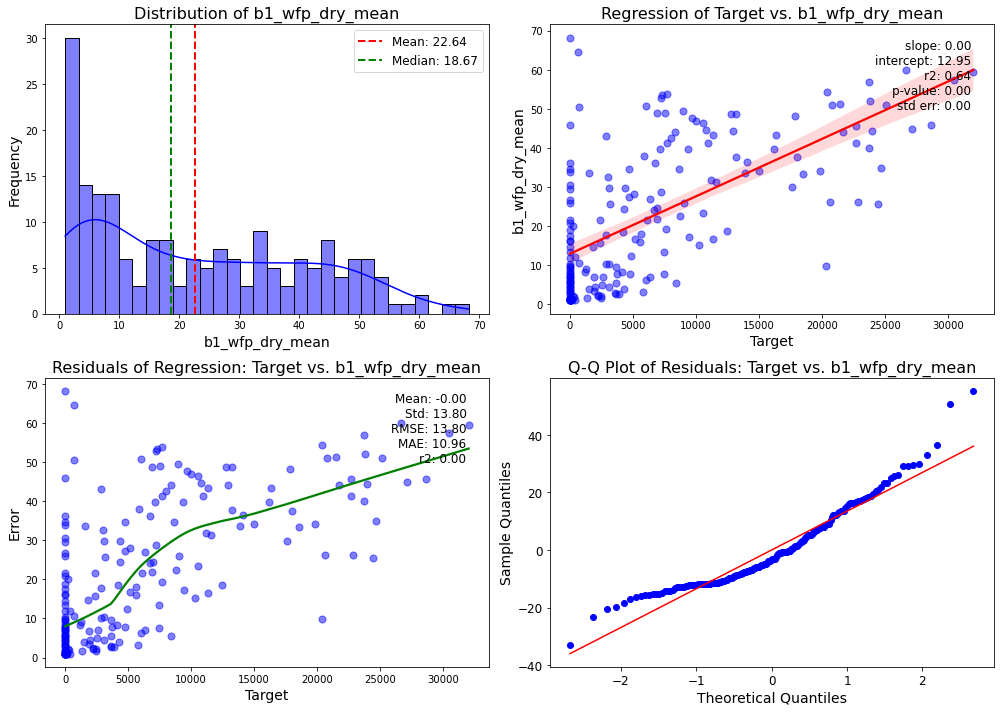

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_wfp_dry_mean_0_combined_plot_tr.JPG


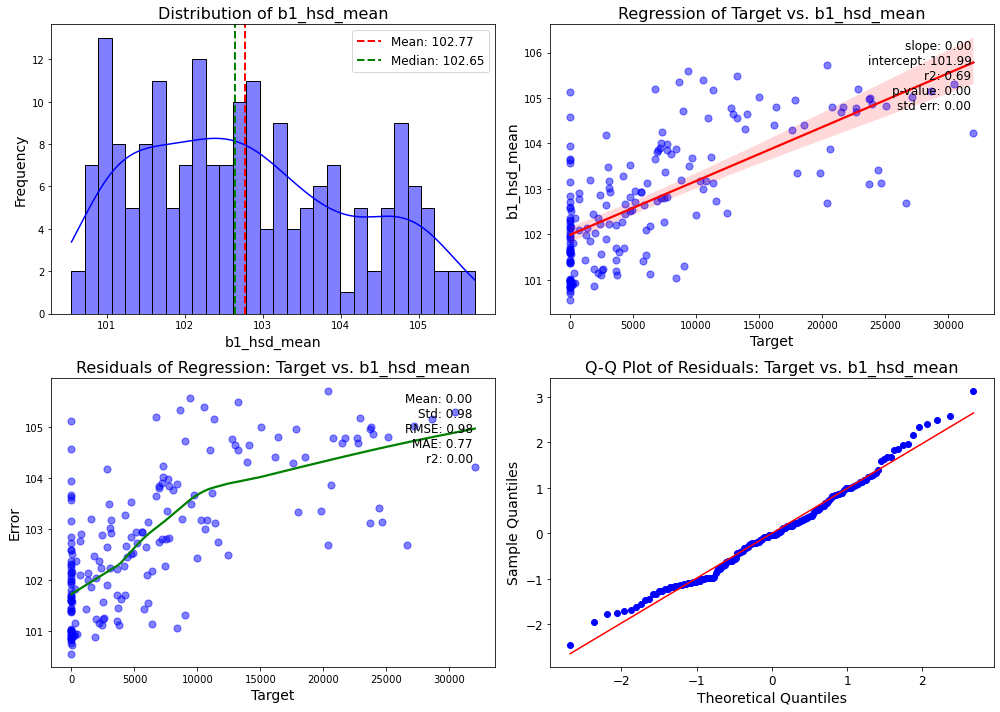

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_hsd_mean_0_combined_plot_tr.JPG


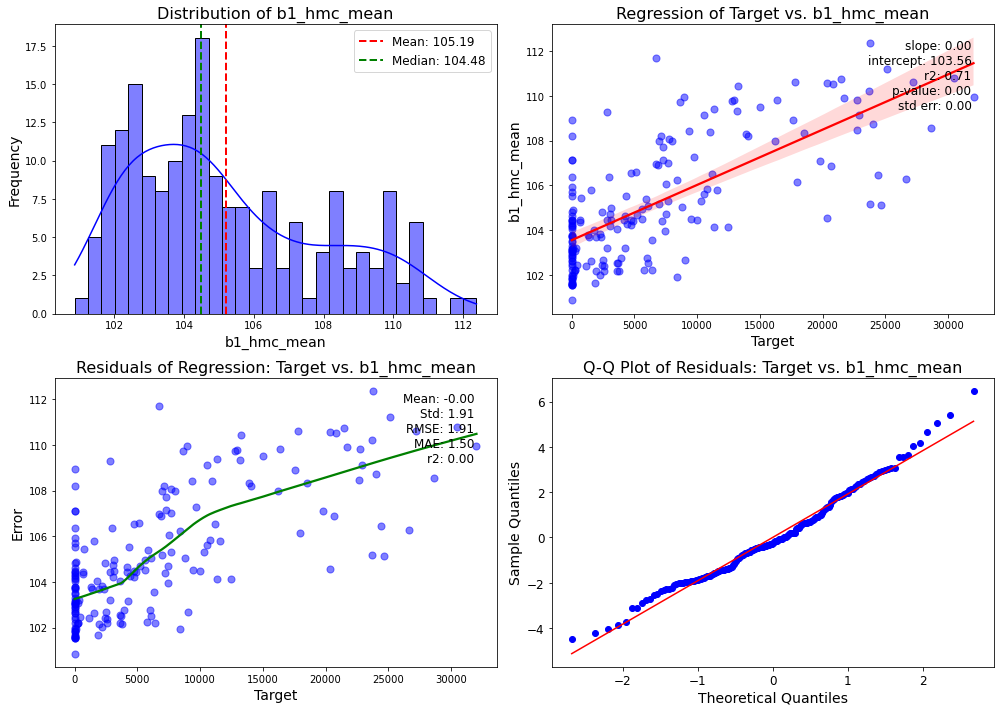

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_hmc_mean_0_combined_plot_tr.JPG


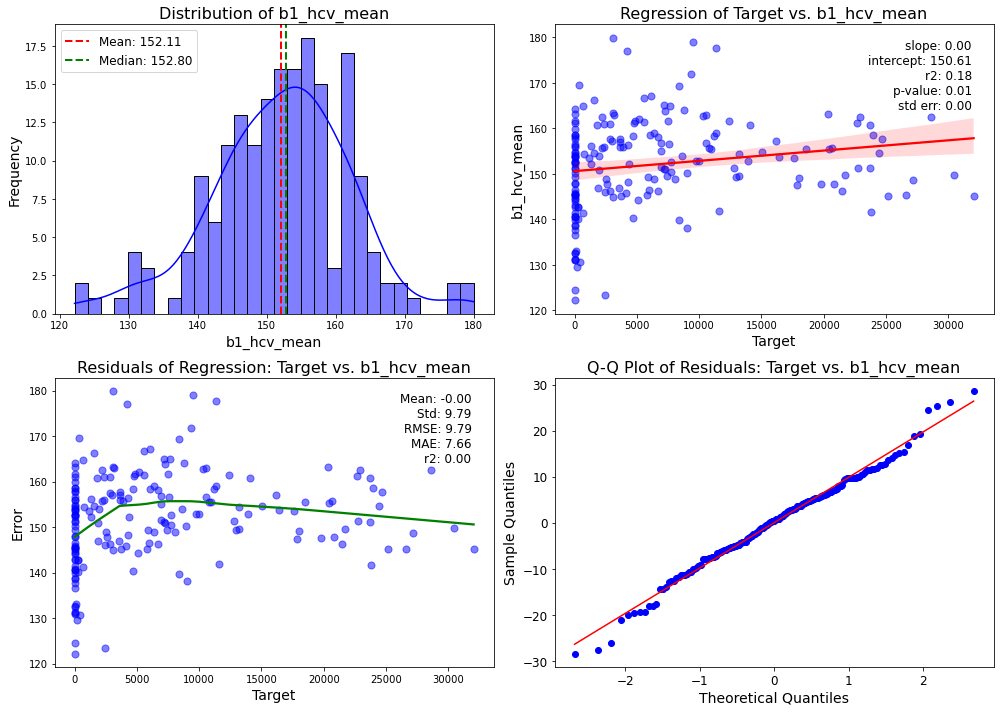

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_hcv_mean_0_combined_plot_tr.JPG


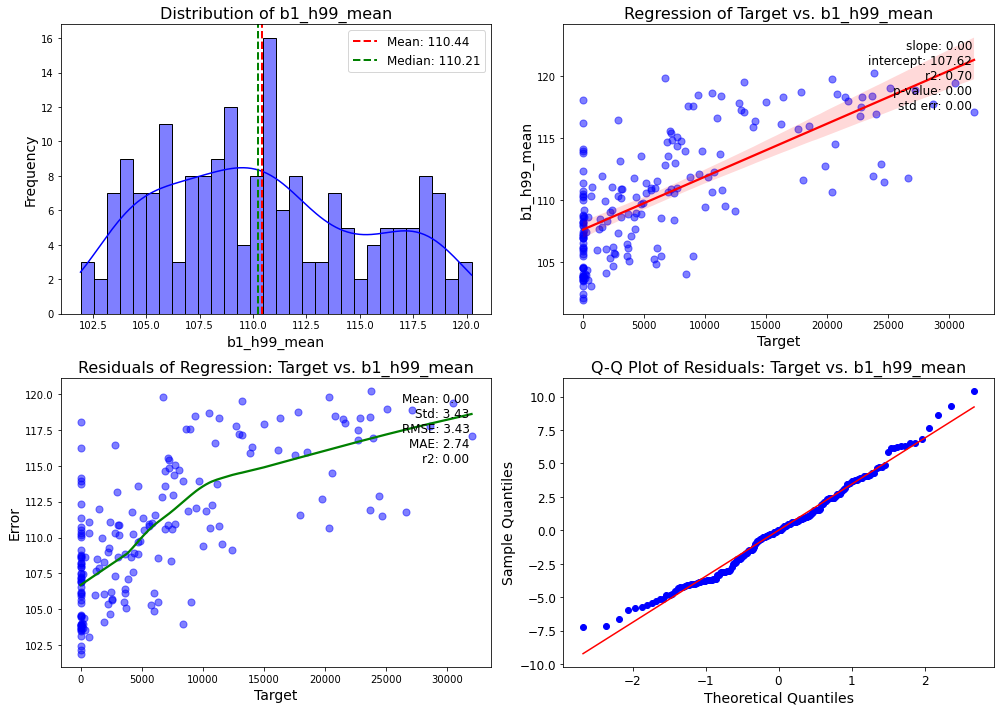

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_h99_mean_0_combined_plot_tr.JPG


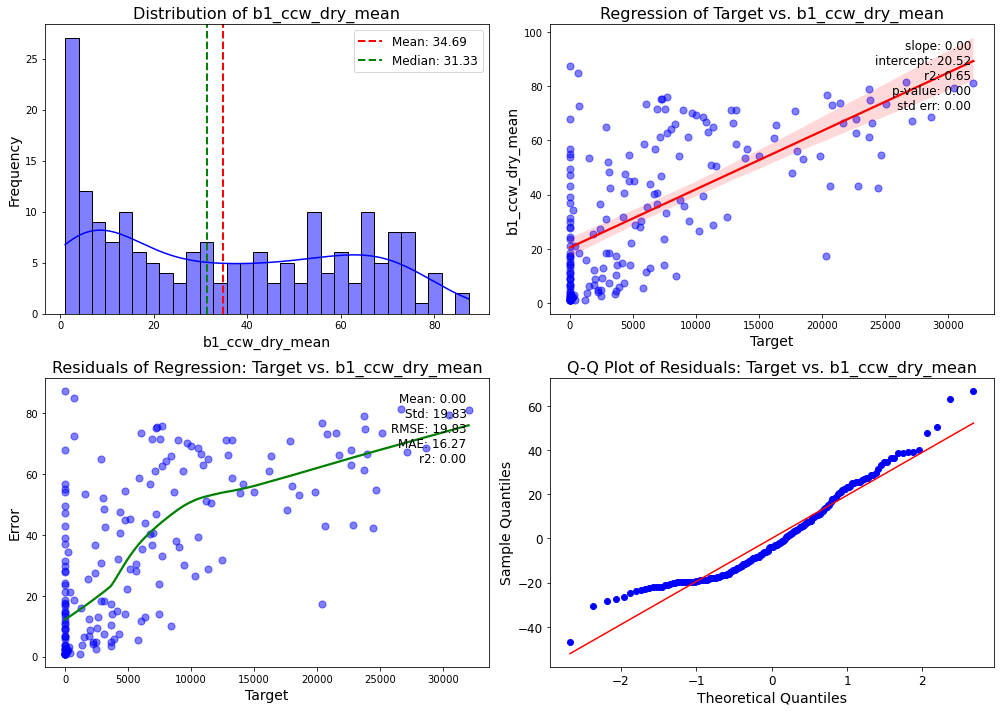

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_ccw_dry_mean_0_combined_plot_tr.JPG


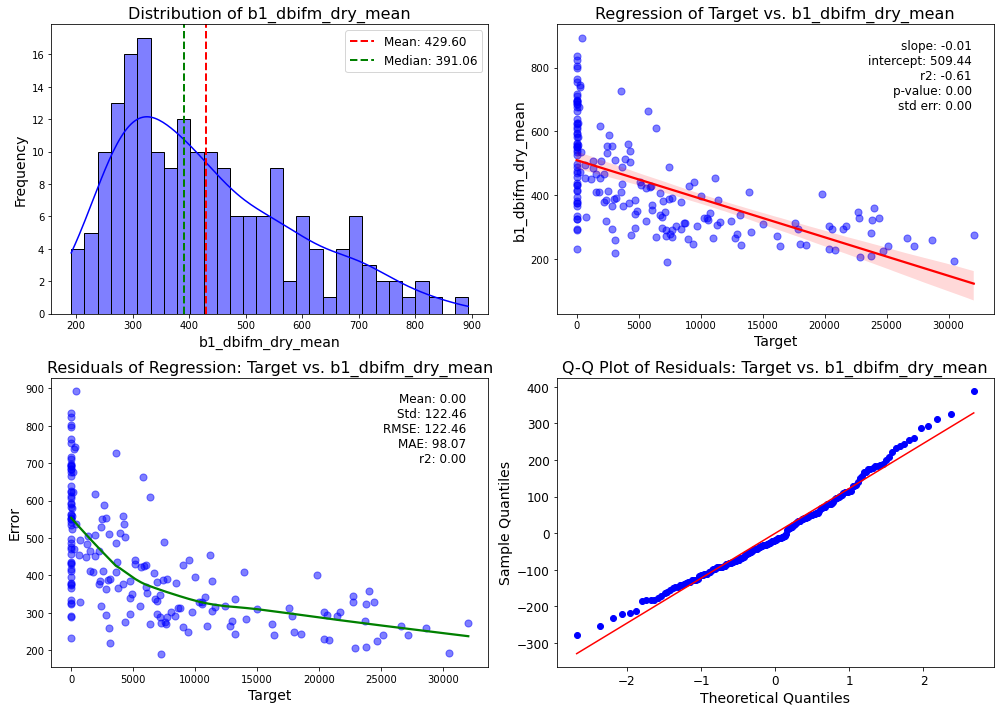

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_dbifm_dry_mean_0_combined_plot_tr.JPG


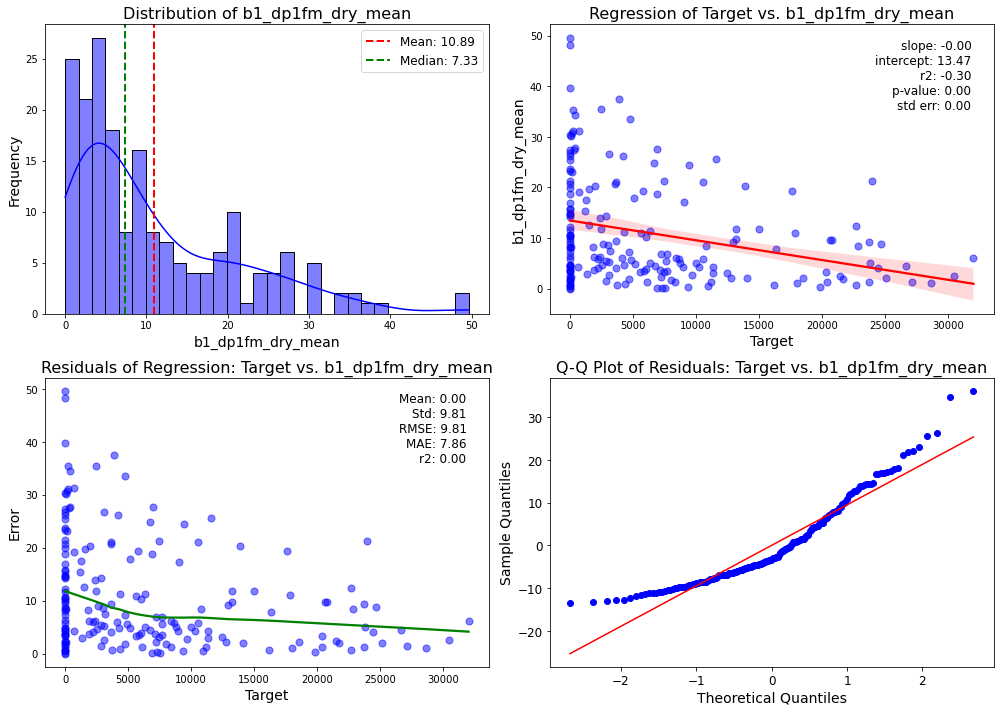

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_dp1fm_dry_mean_0_combined_plot_tr.JPG


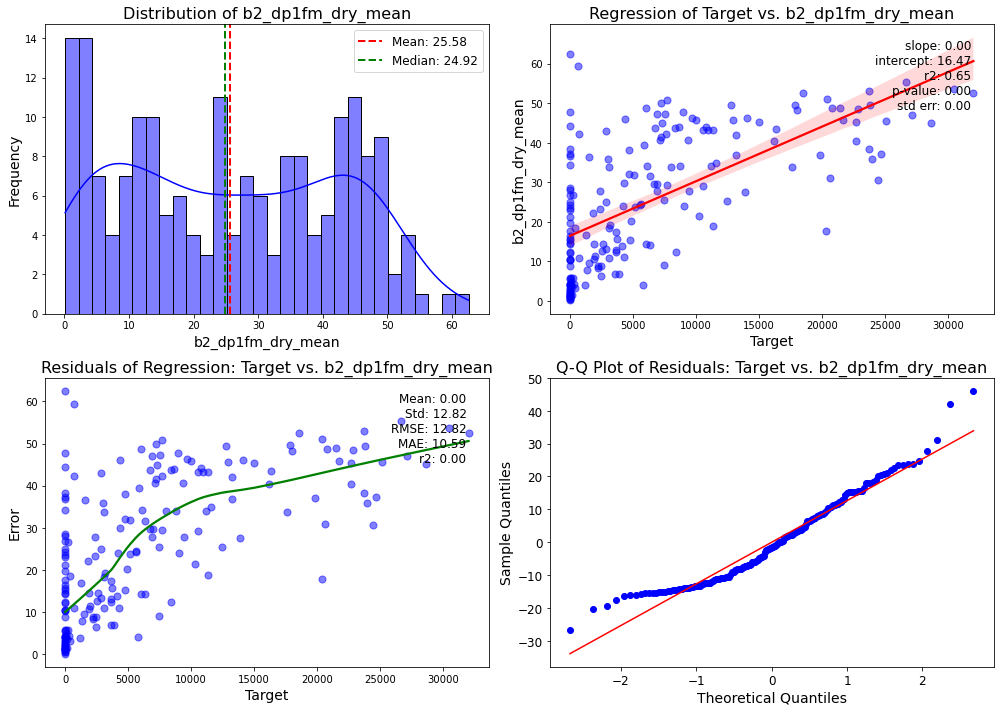

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b2_dp1fm_dry_mean_0_combined_plot_tr.JPG


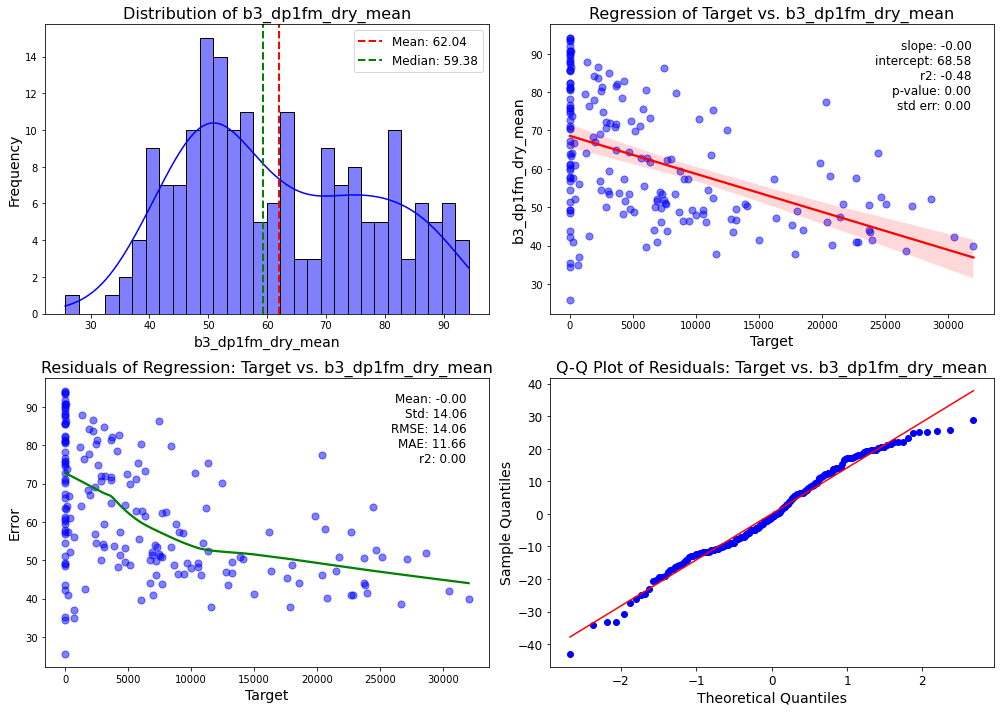

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b3_dp1fm_dry_mean_0_combined_plot_tr.JPG


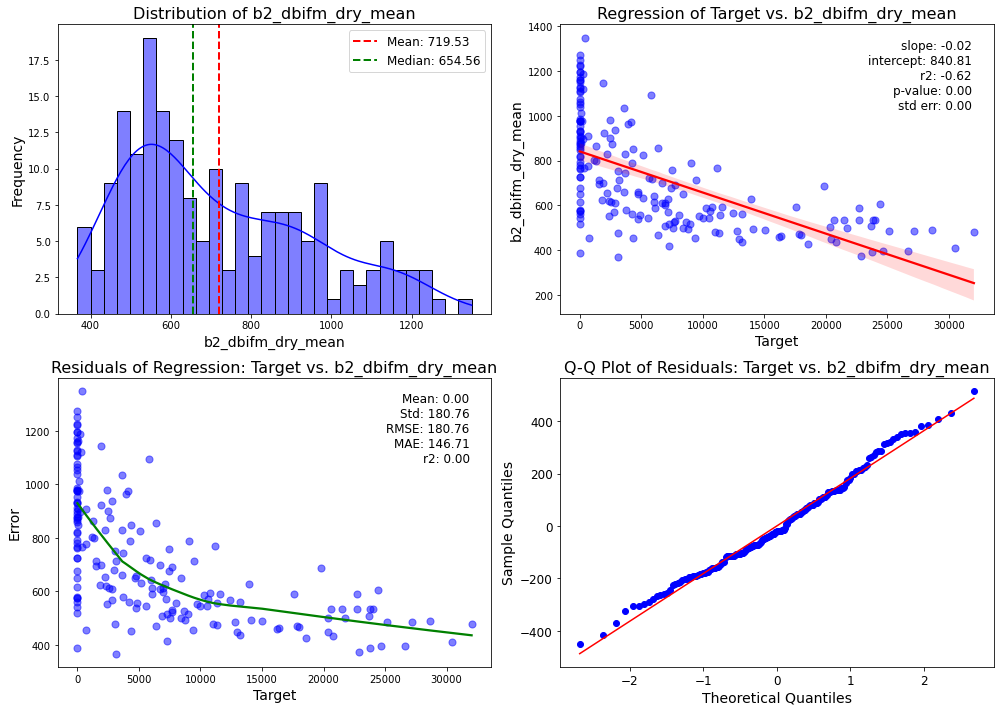

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b2_dbifm_dry_mean_0_combined_plot_tr.JPG


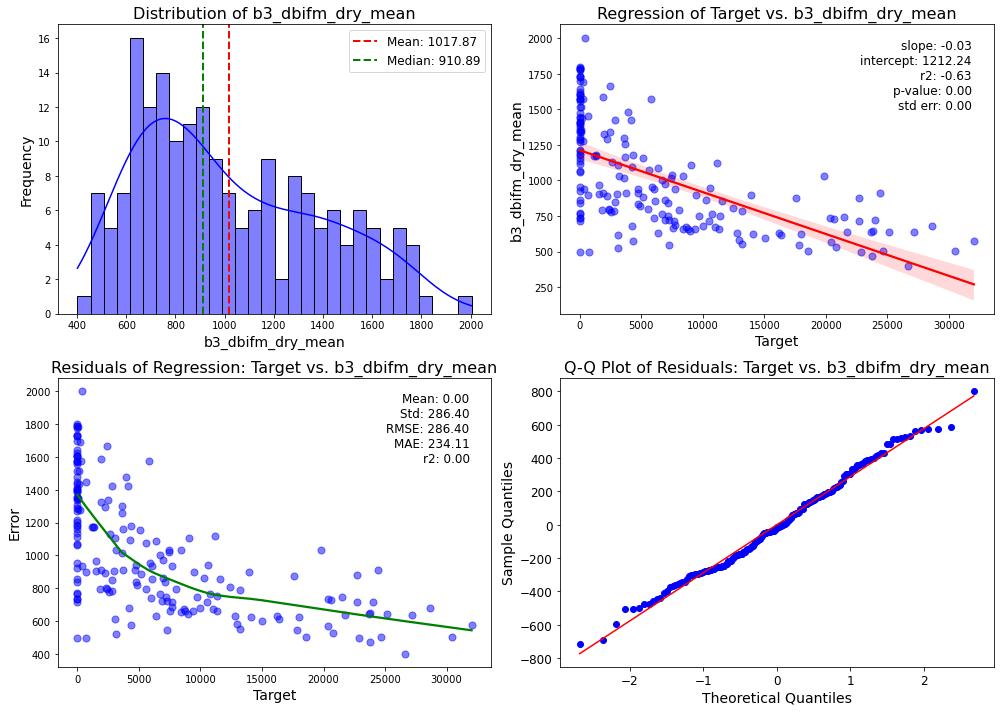

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b3_dbifm_dry_mean_0_combined_plot_tr.JPG


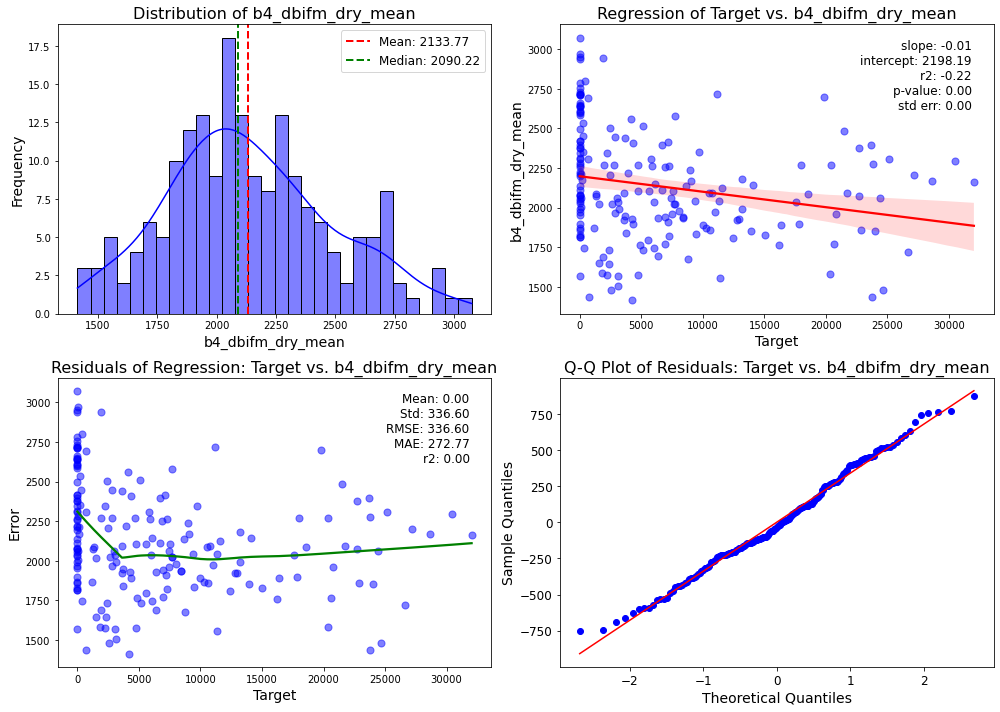

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b4_dbifm_dry_mean_0_combined_plot_tr.JPG


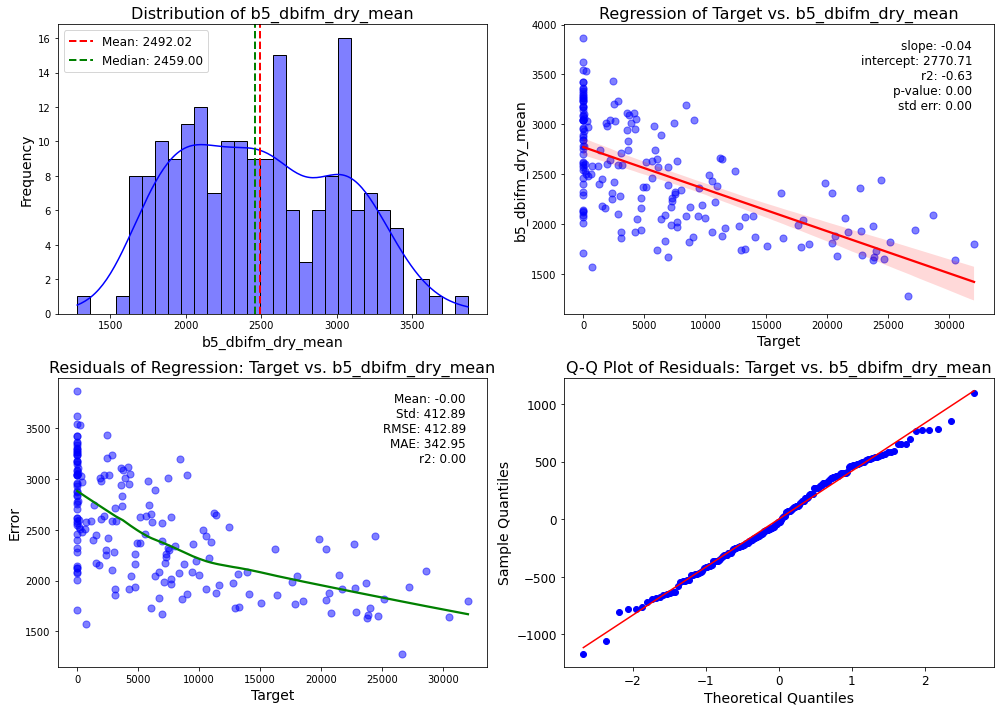

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b5_dbifm_dry_mean_0_combined_plot_tr.JPG


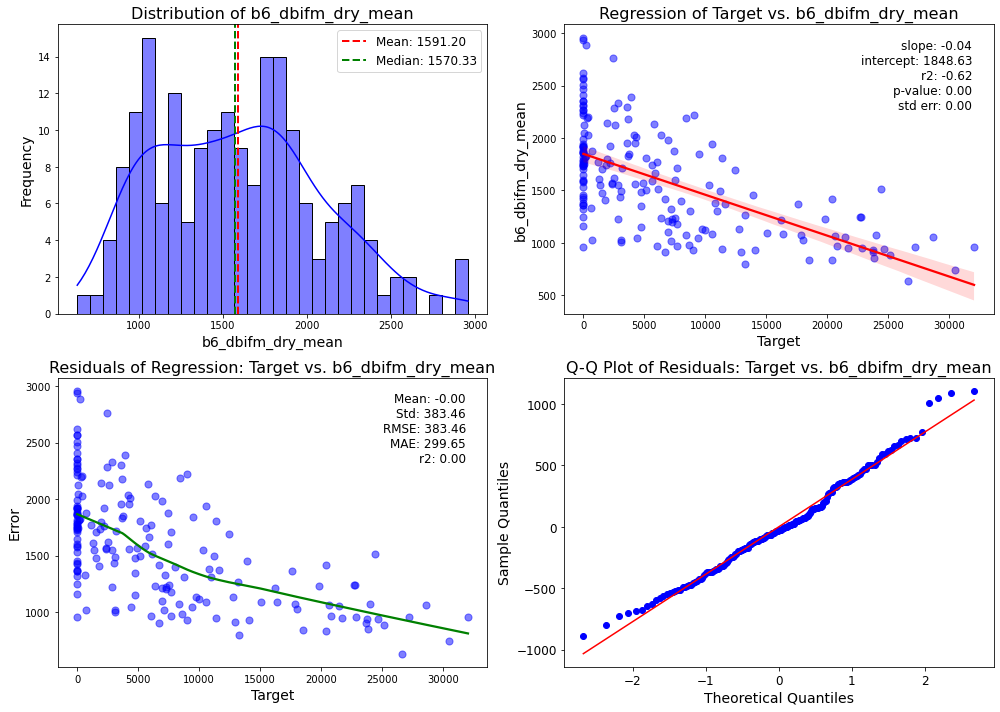

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b6_dbifm_dry_mean_0_combined_plot_tr.JPG


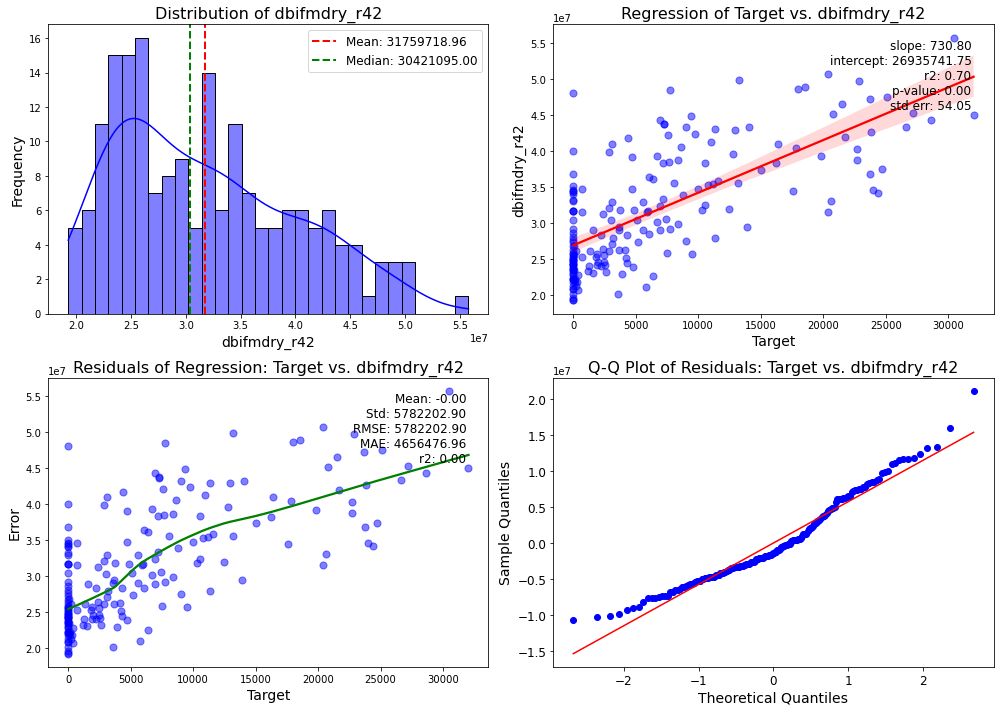

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r42_0_combined_plot_tr.JPG


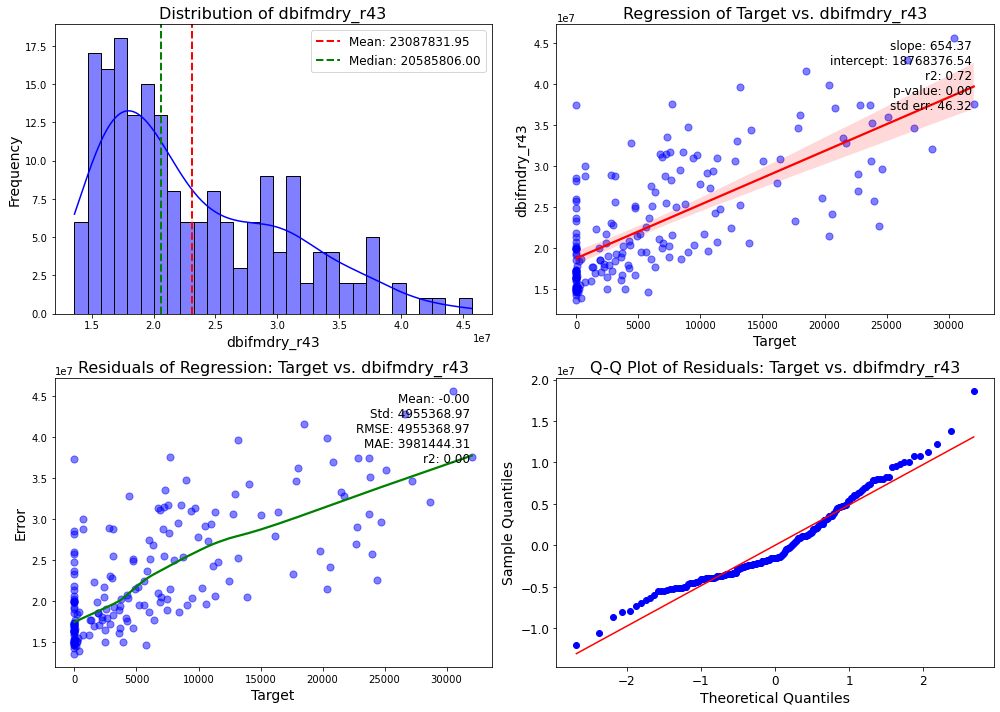

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r43_0_combined_plot_tr.JPG


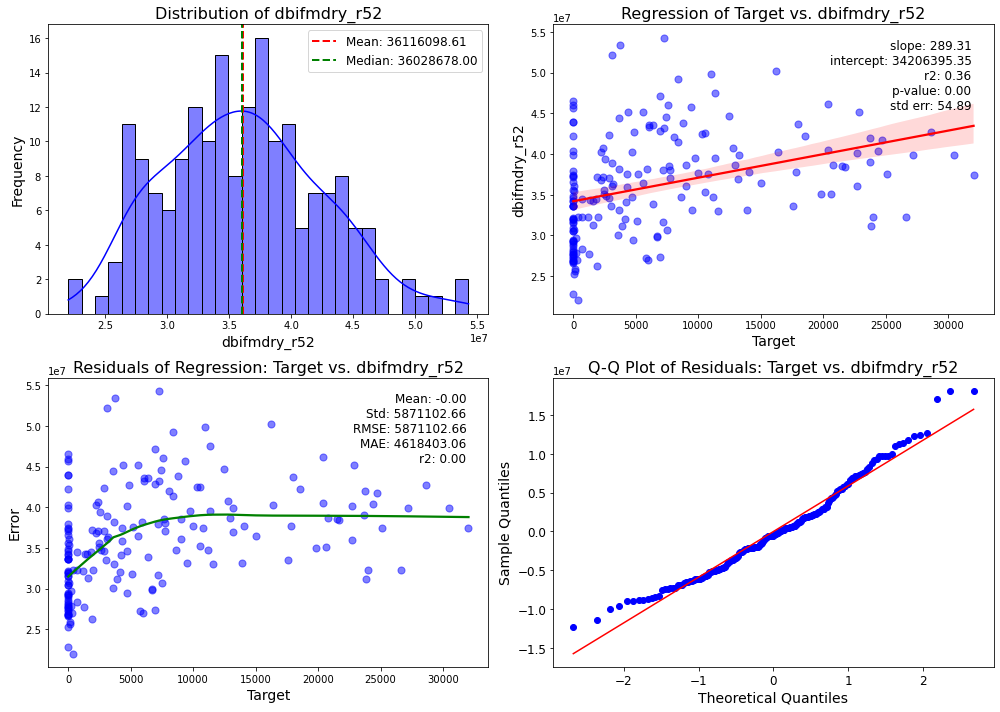

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r52_0_combined_plot_tr.JPG


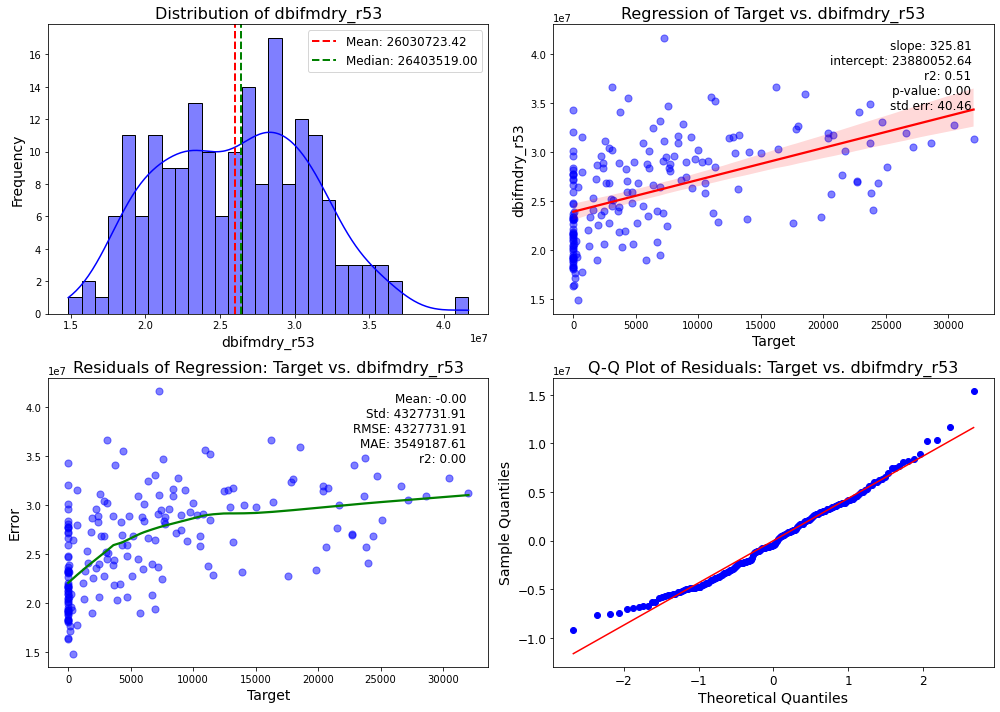

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r53_0_combined_plot_tr.JPG


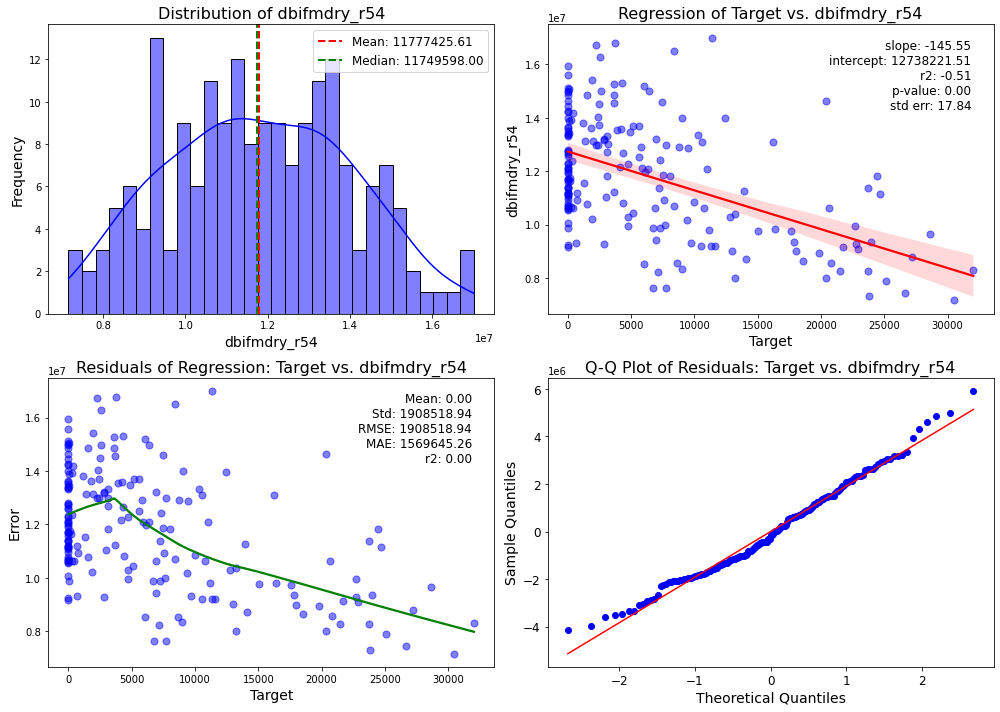

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r54_0_combined_plot_tr.JPG


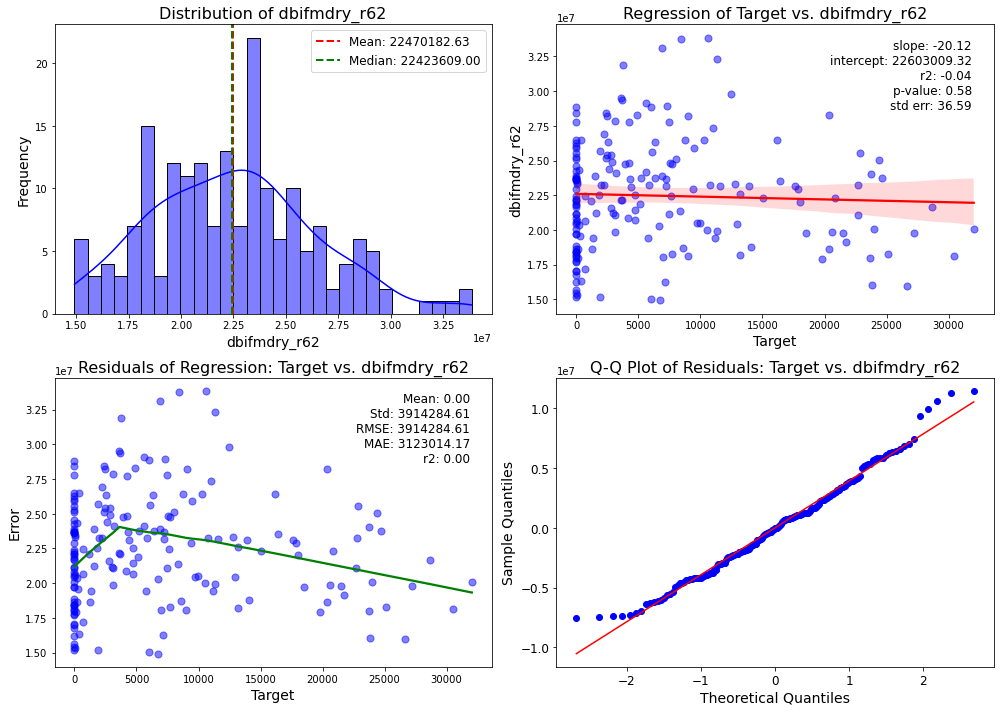

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r62_0_combined_plot_tr.JPG


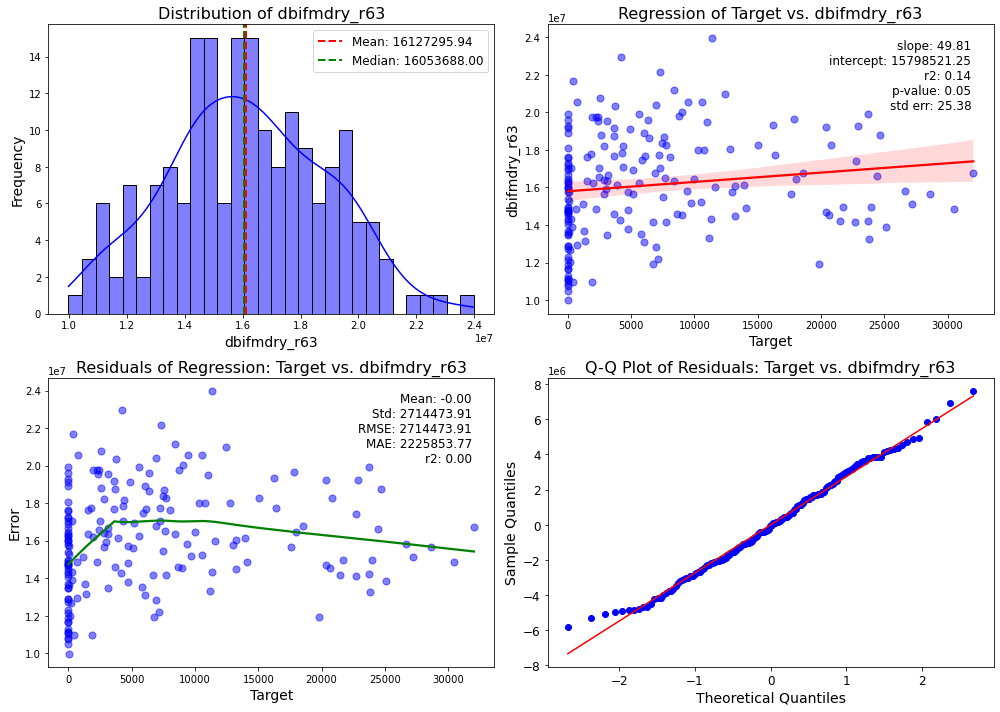

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r63_0_combined_plot_tr.JPG


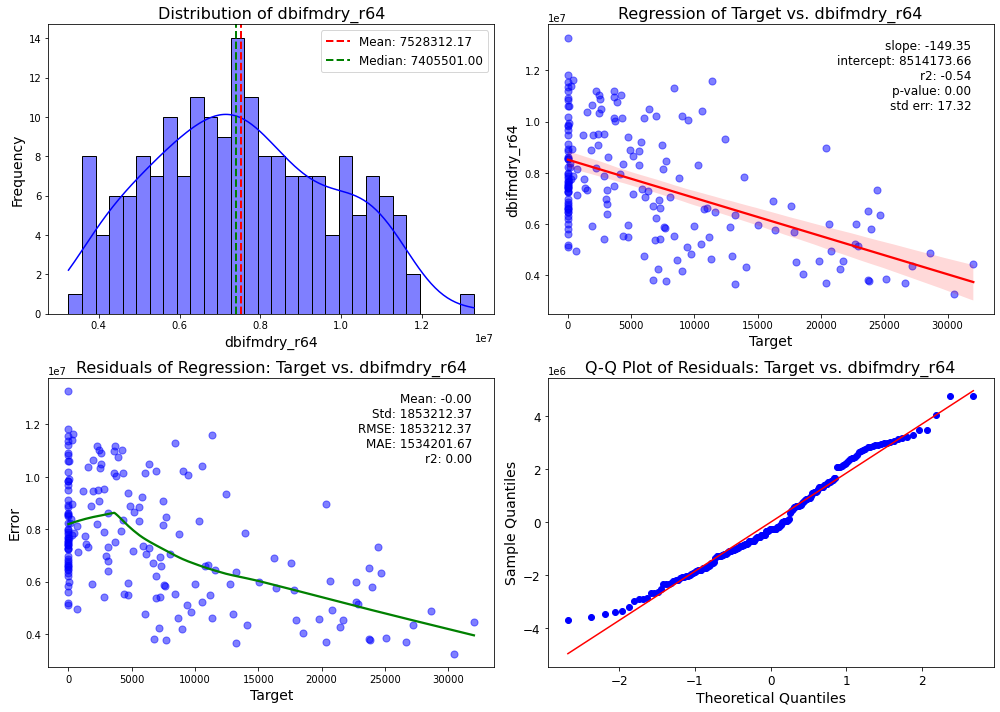

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r64_0_combined_plot_tr.JPG


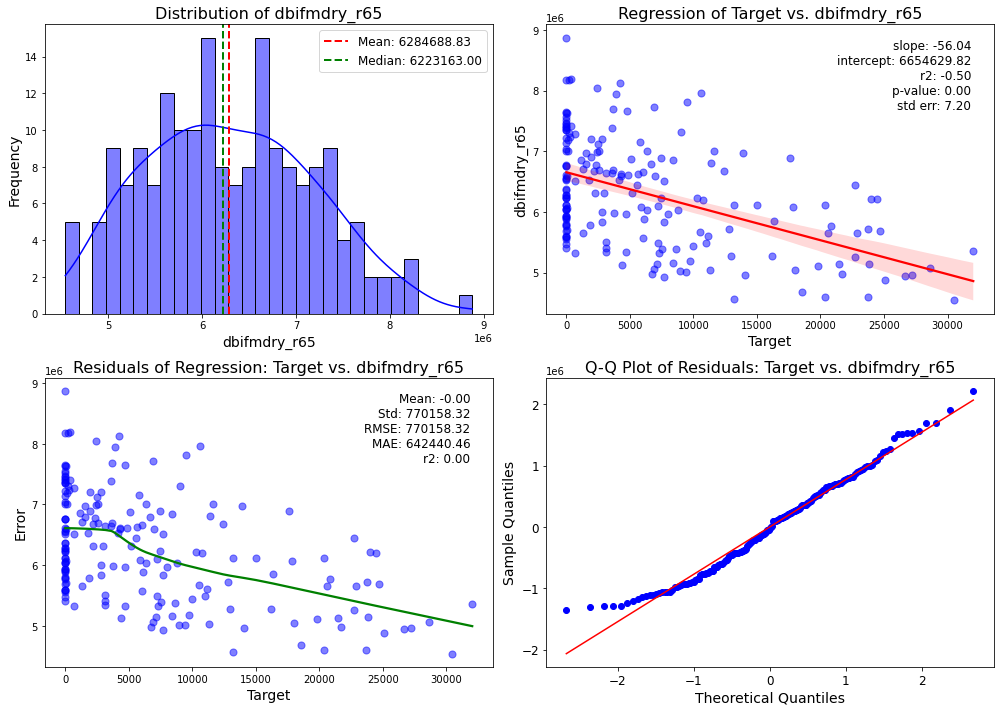

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_r65_0_combined_plot_tr.JPG


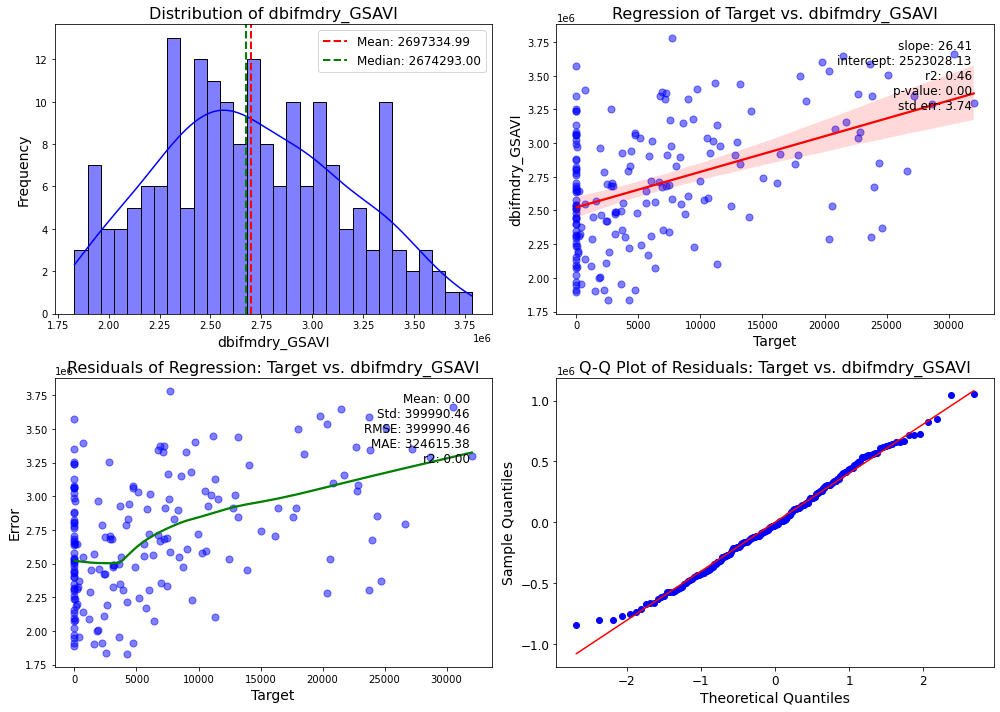

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_GSAVI_0_combined_plot_tr.JPG


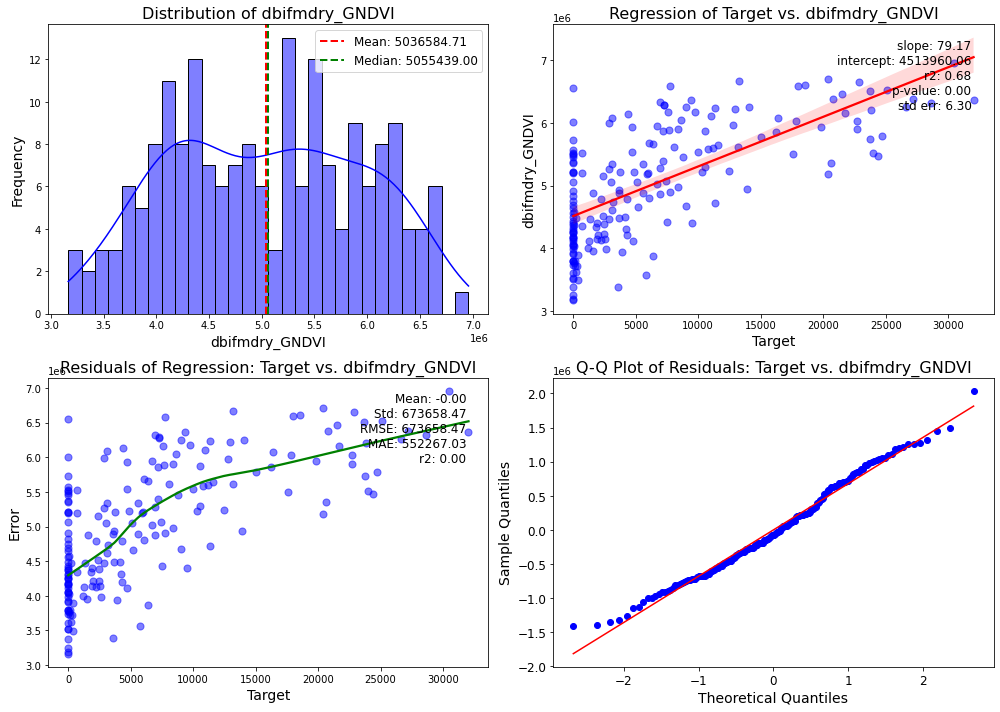

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_GNDVI_0_combined_plot_tr.JPG


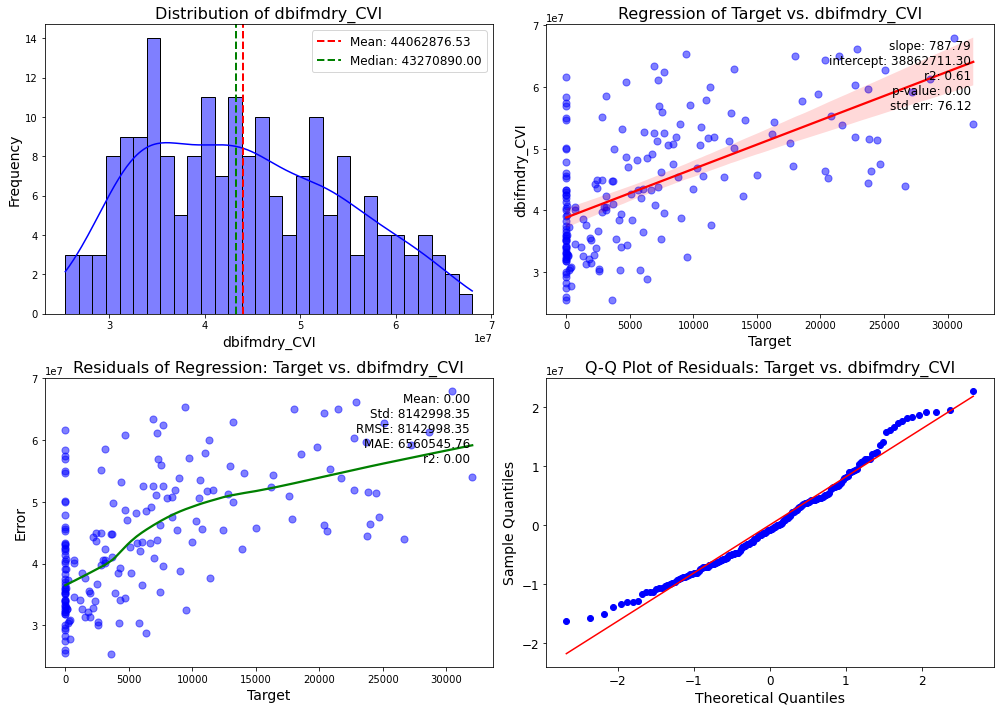

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_CVI_0_combined_plot_tr.JPG


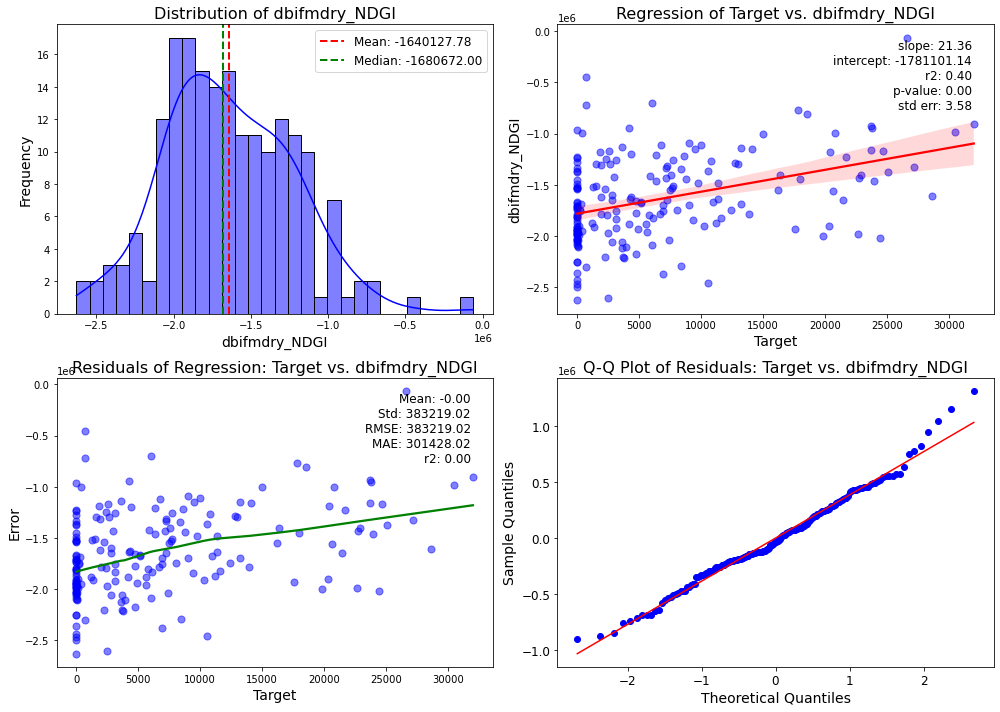

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_NDGI_0_combined_plot_tr.JPG


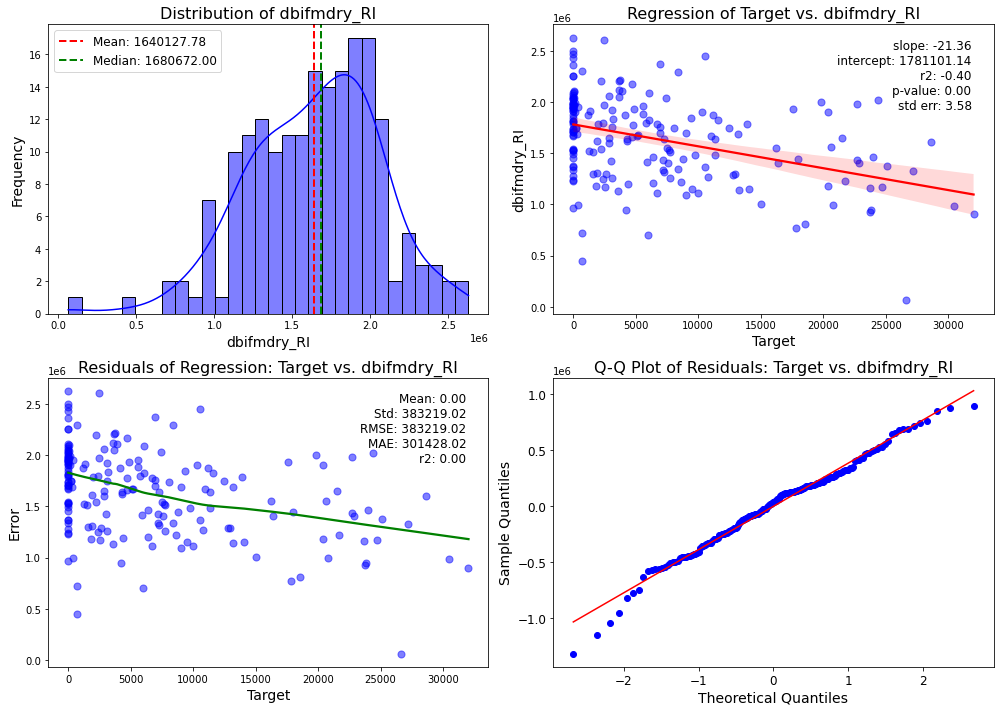

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_RI_0_combined_plot_tr.JPG


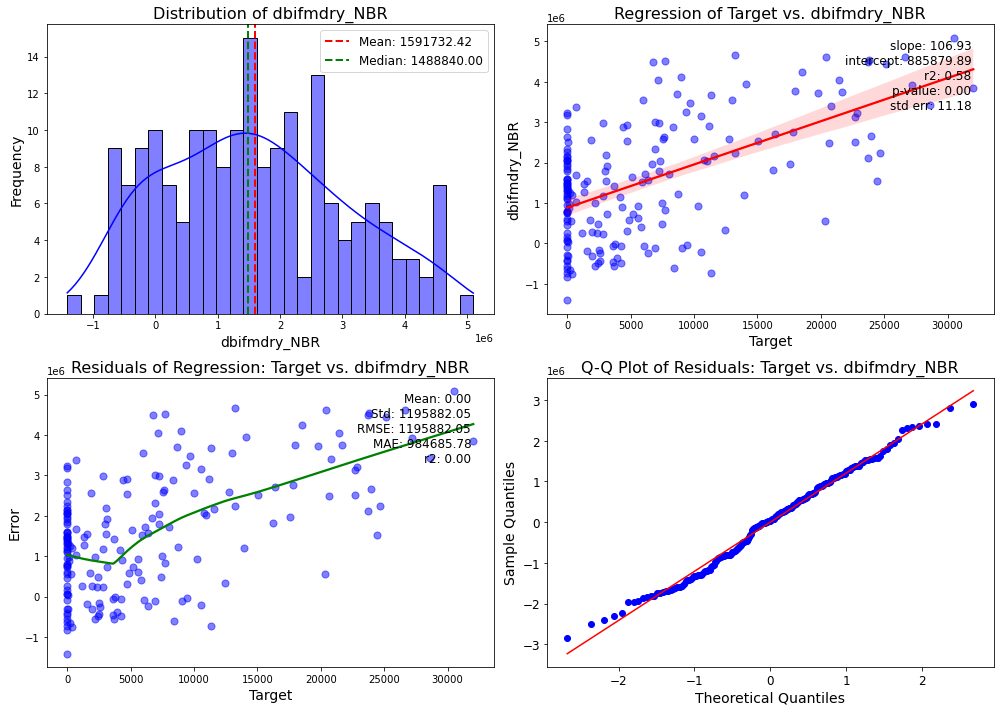

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_NBR_0_combined_plot_tr.JPG


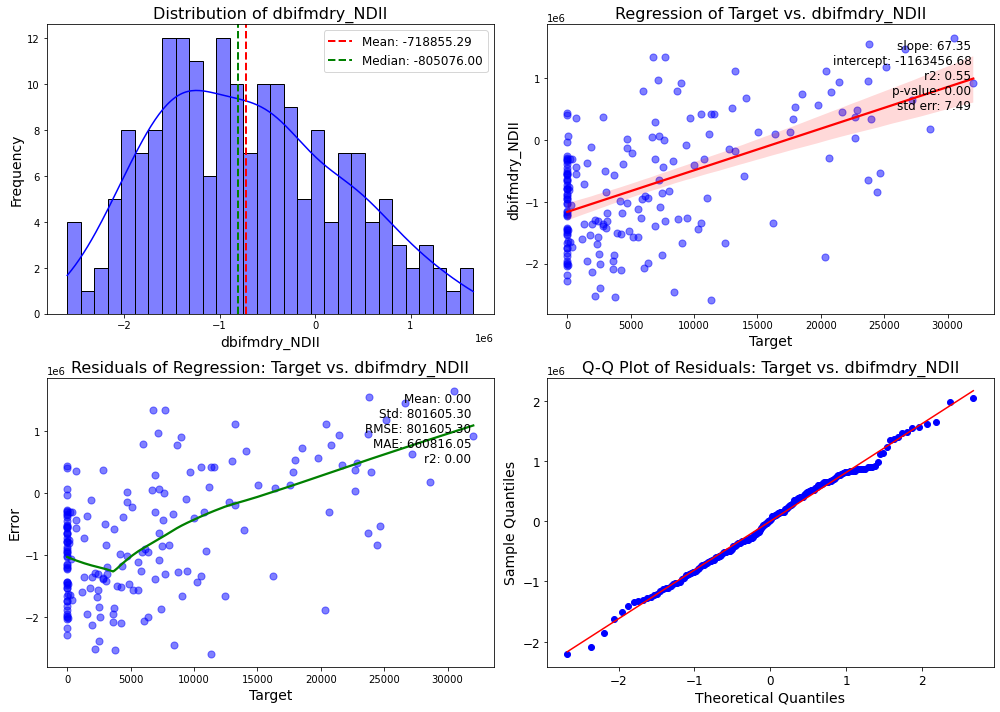

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_NDII_0_combined_plot_tr.JPG


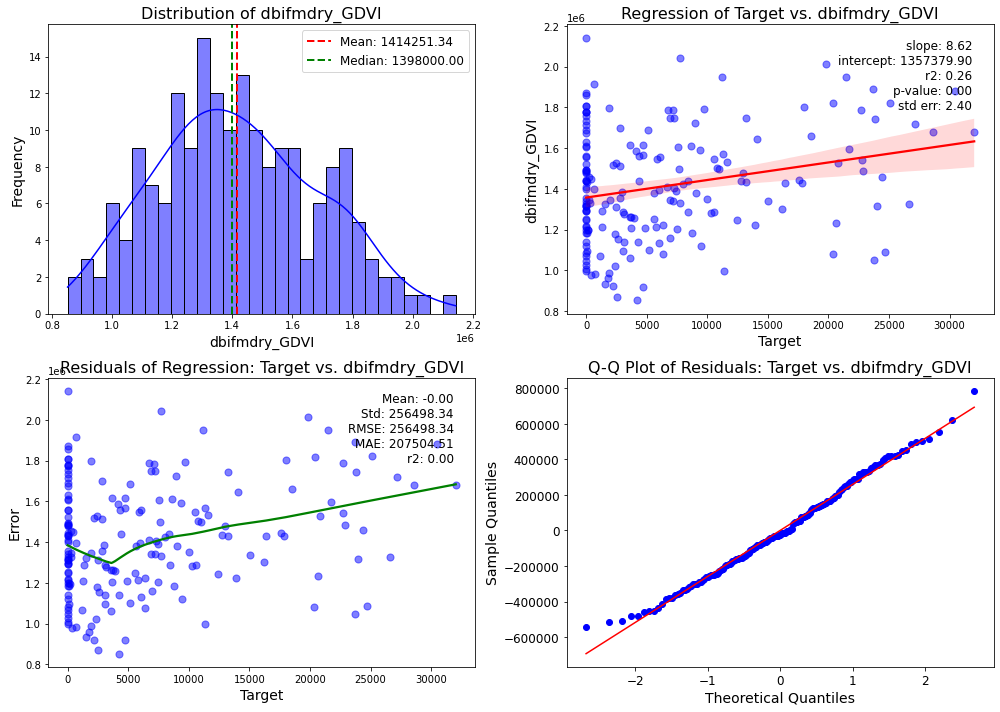

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_GDVI_0_combined_plot_tr.JPG


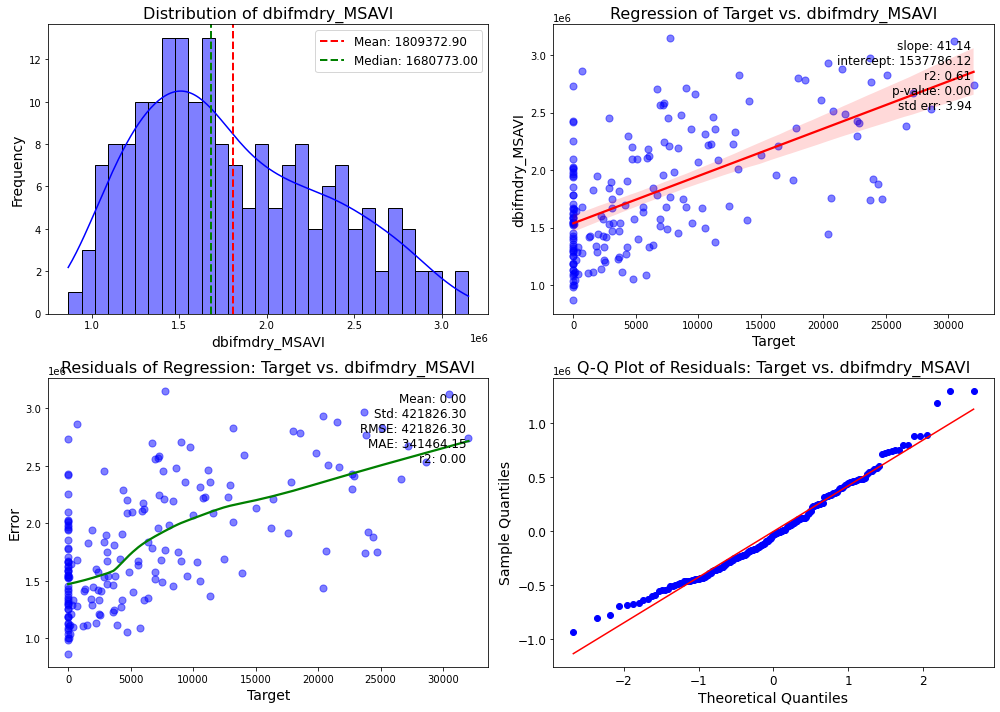

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_MSAVI_0_combined_plot_tr.JPG


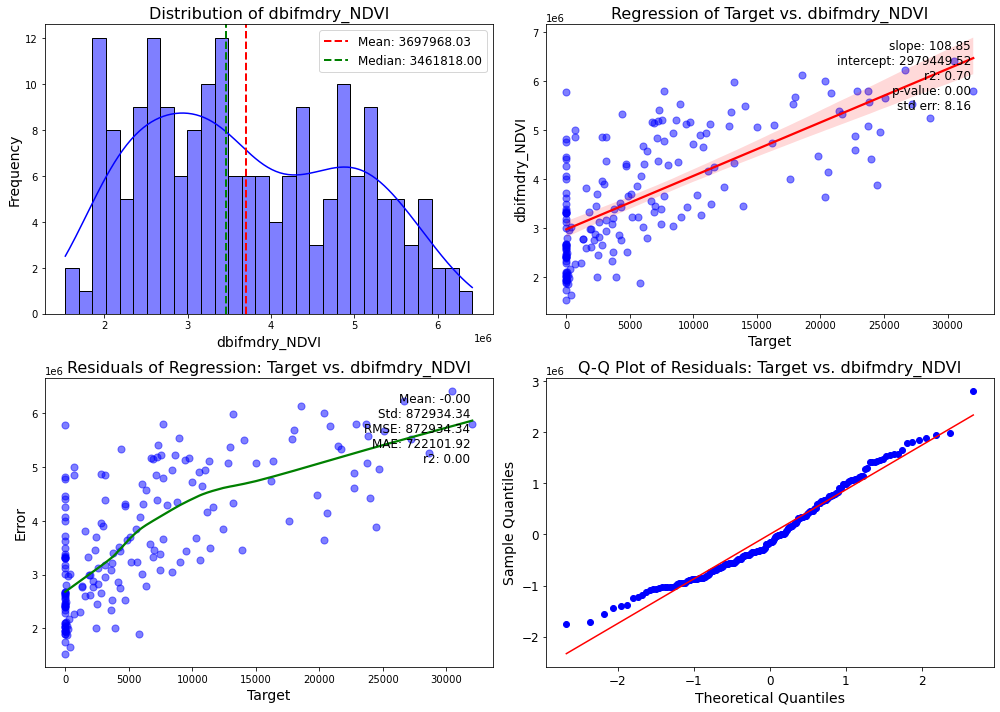

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_NDVI_0_combined_plot_tr.JPG


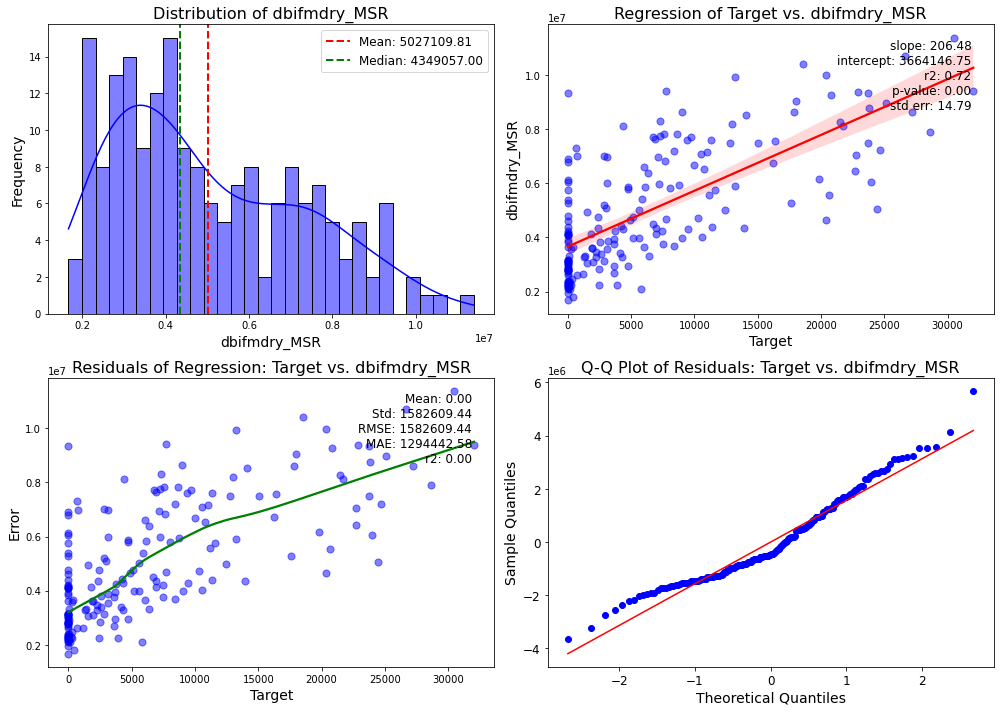

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_dbifmdry_MSR_0_combined_plot_tr.JPG


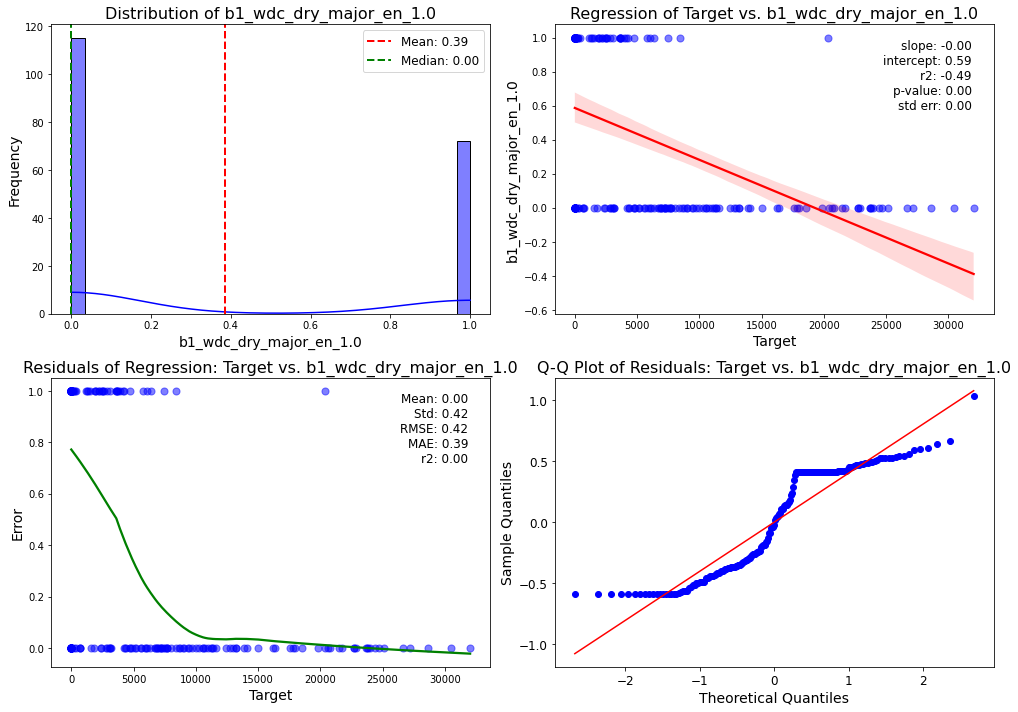

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_wdc_dry_major_en_1.0_0_combined_plot_tr.JPG


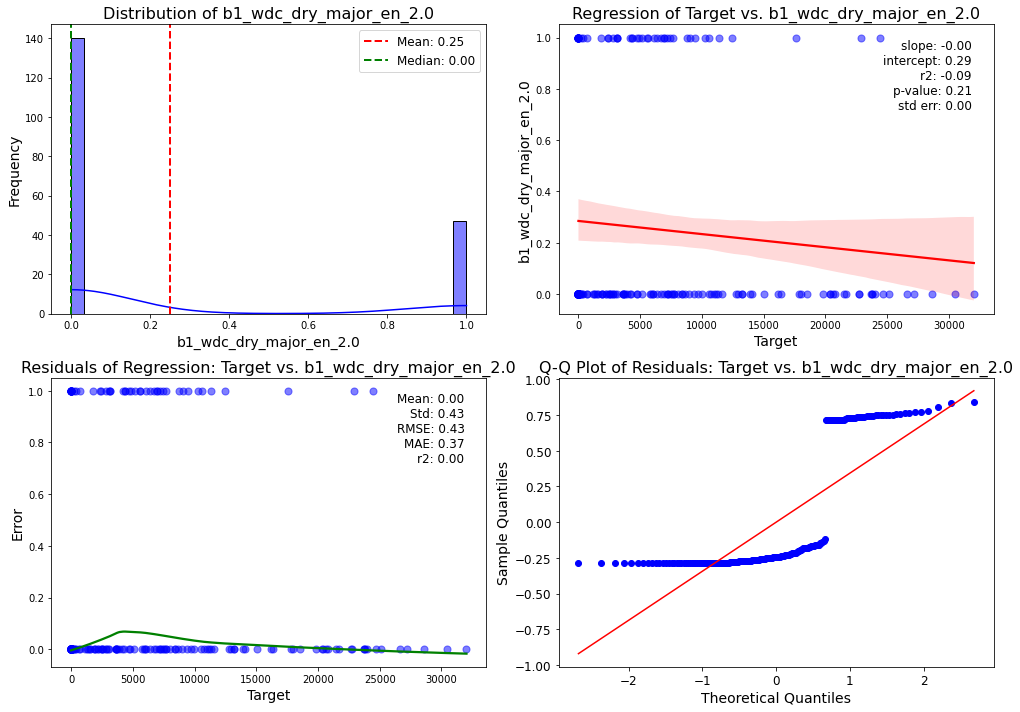

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_wdc_dry_major_en_2.0_0_combined_plot_tr.JPG


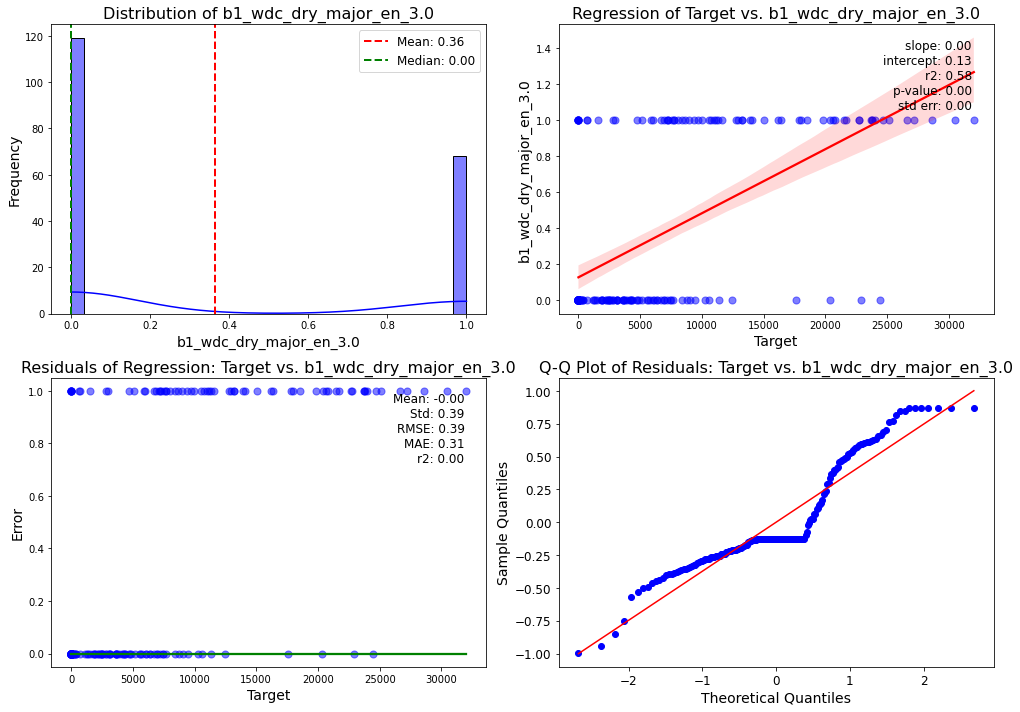

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_wdc_dry_major_en_3.0_0_combined_plot_tr.JPG


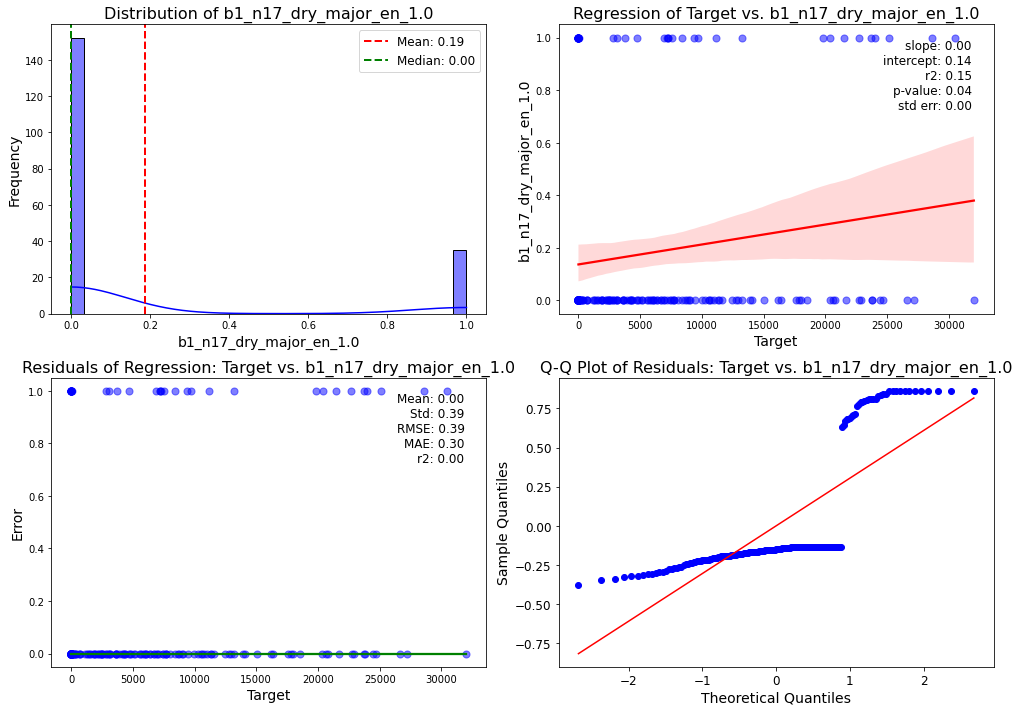

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_1.0_0_combined_plot_tr.JPG


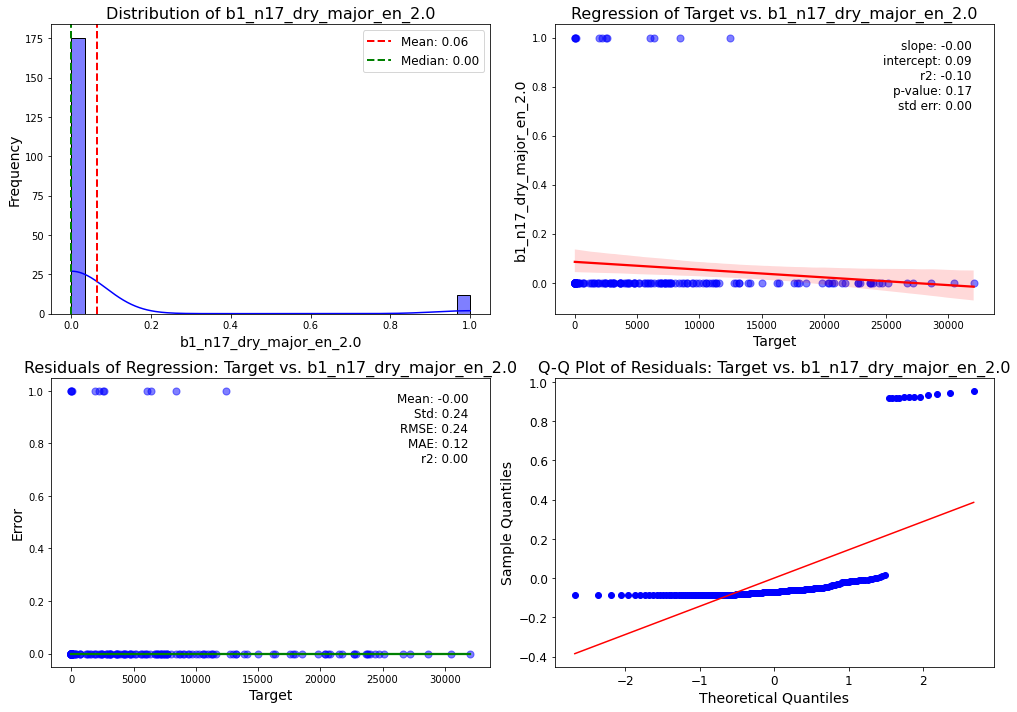

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_2.0_0_combined_plot_tr.JPG


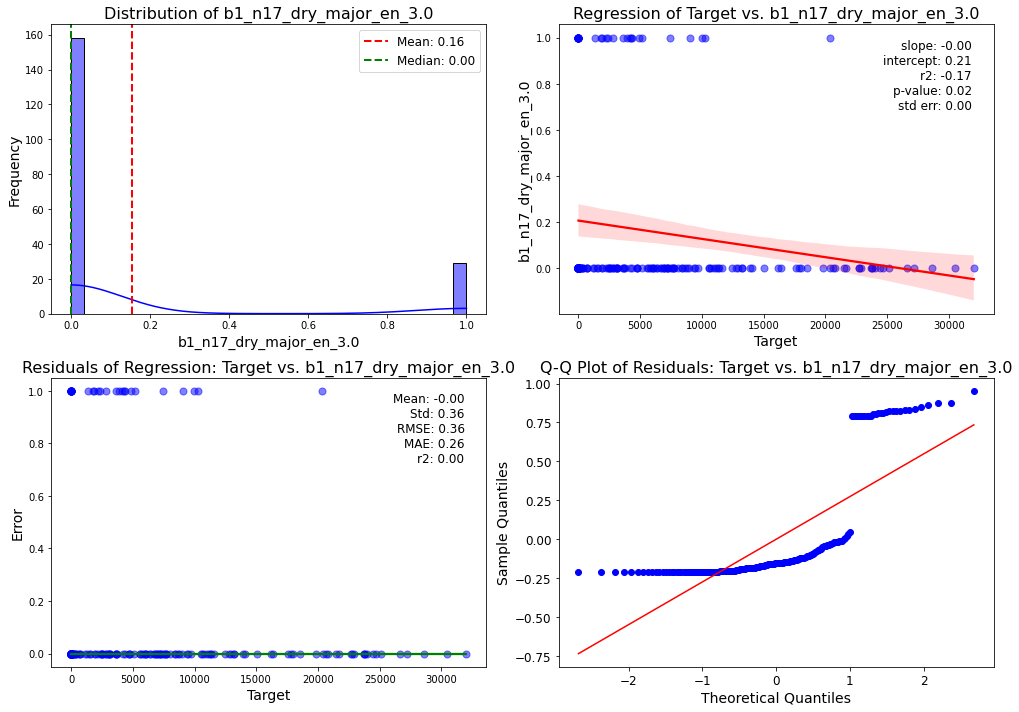

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_3.0_0_combined_plot_tr.JPG


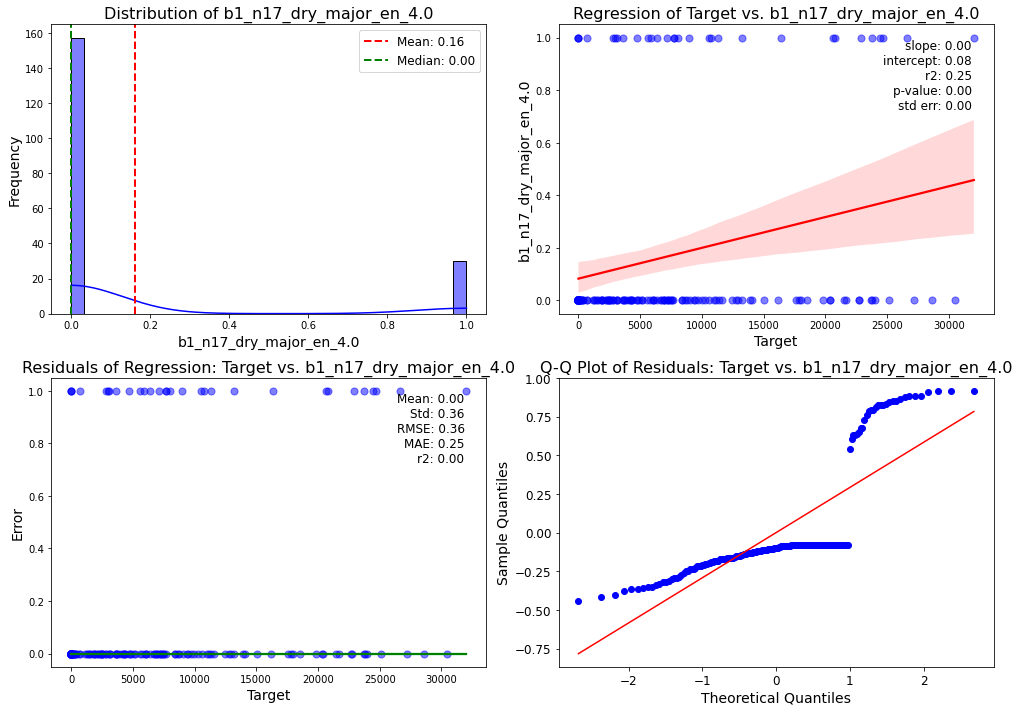

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_4.0_0_combined_plot_tr.JPG


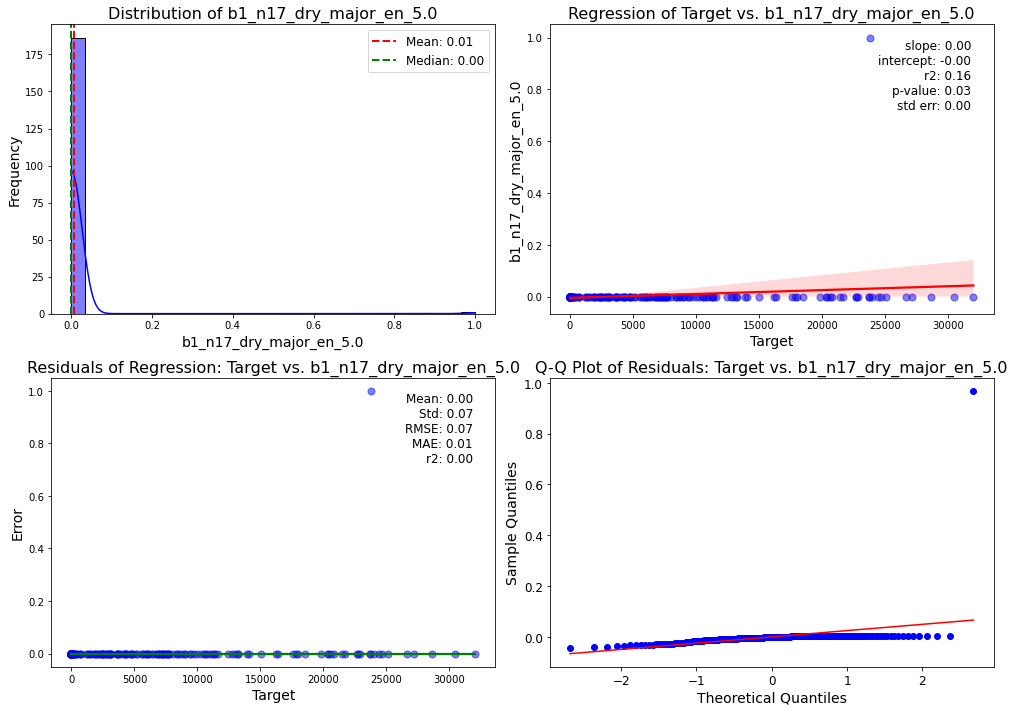

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_5.0_0_combined_plot_tr.JPG


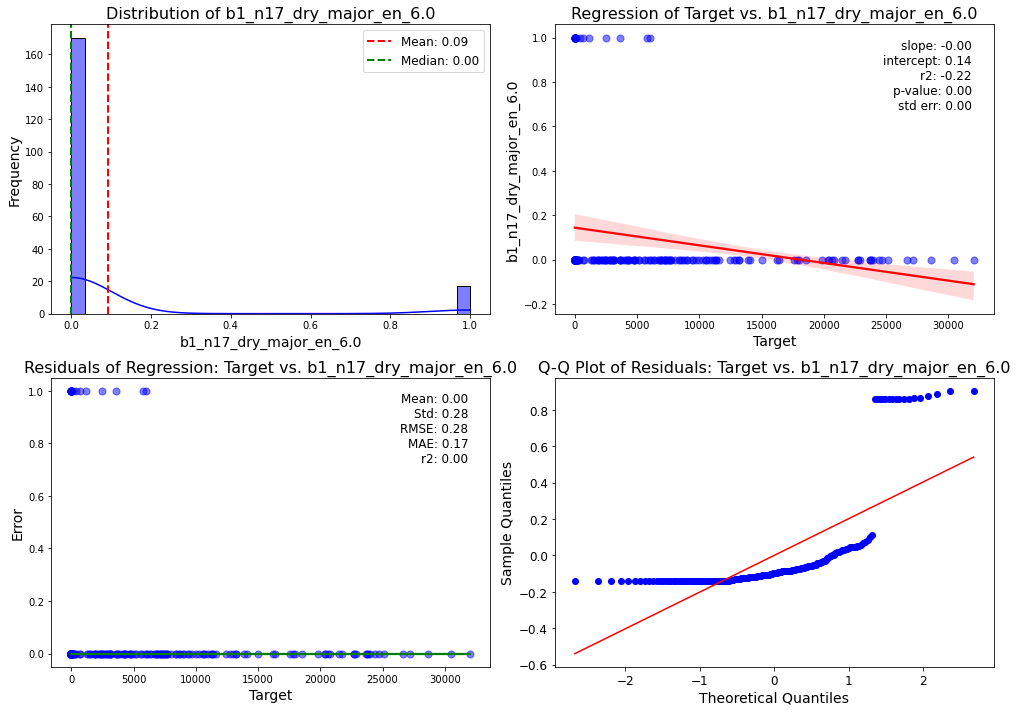

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_6.0_0_combined_plot_tr.JPG


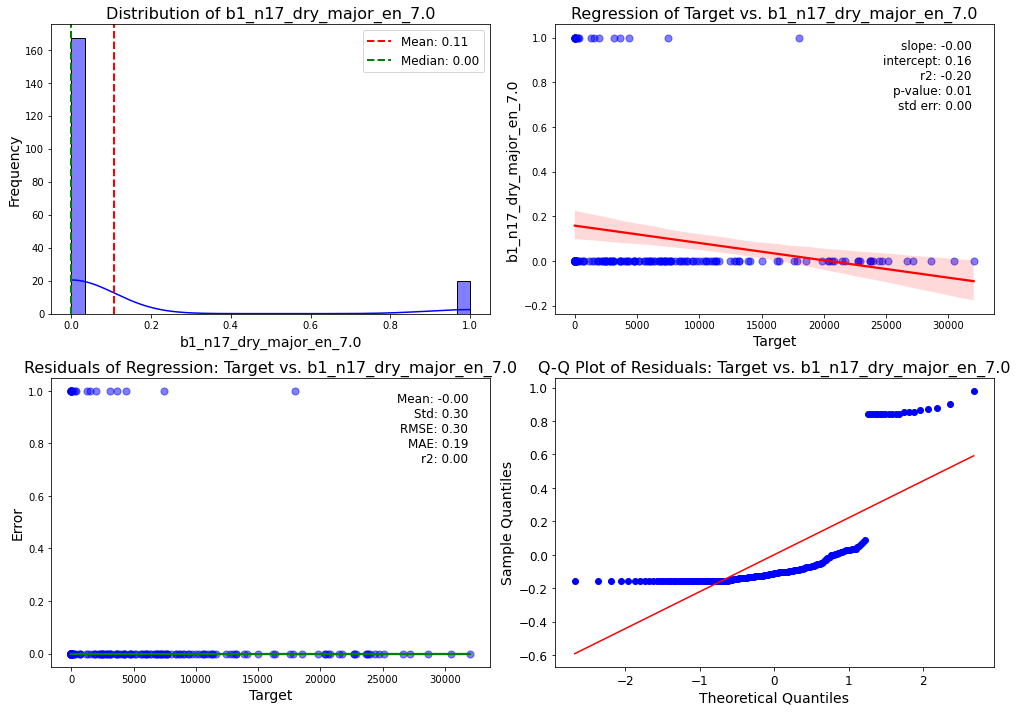

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_7.0_0_combined_plot_tr.JPG


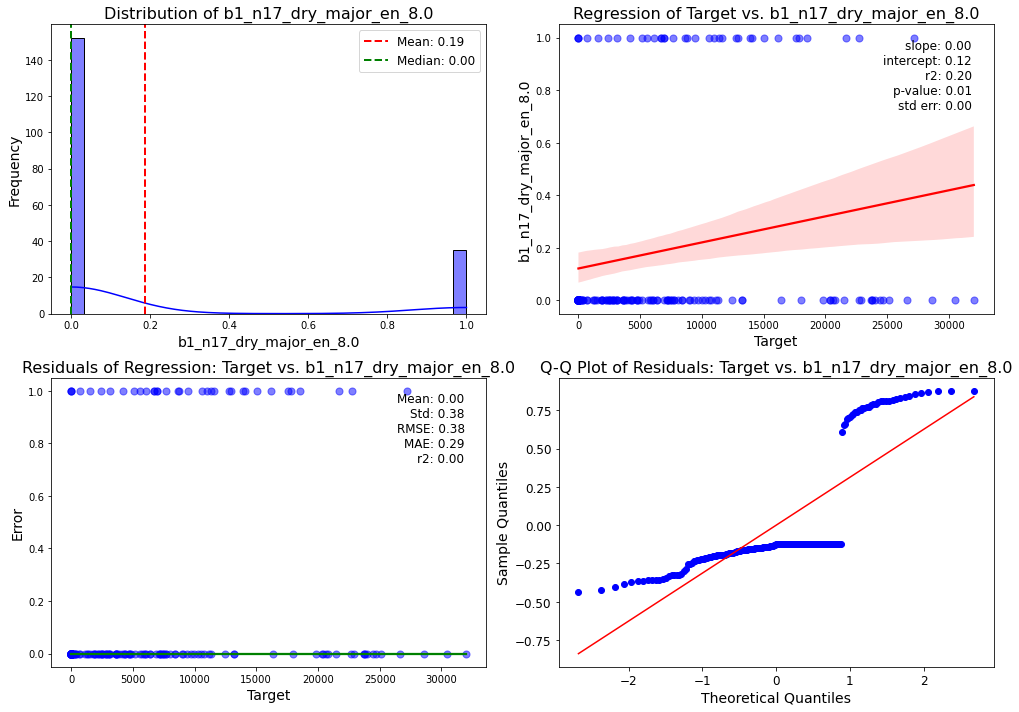

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_8.0_0_combined_plot_tr.JPG


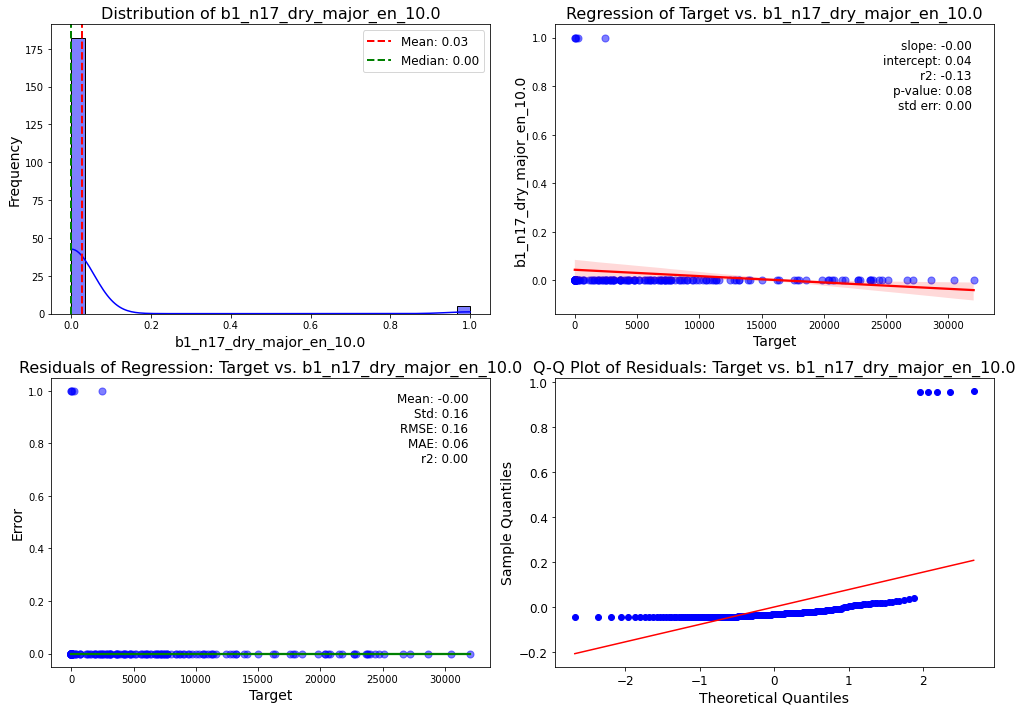

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_10.0_0_combined_plot_tr.JPG


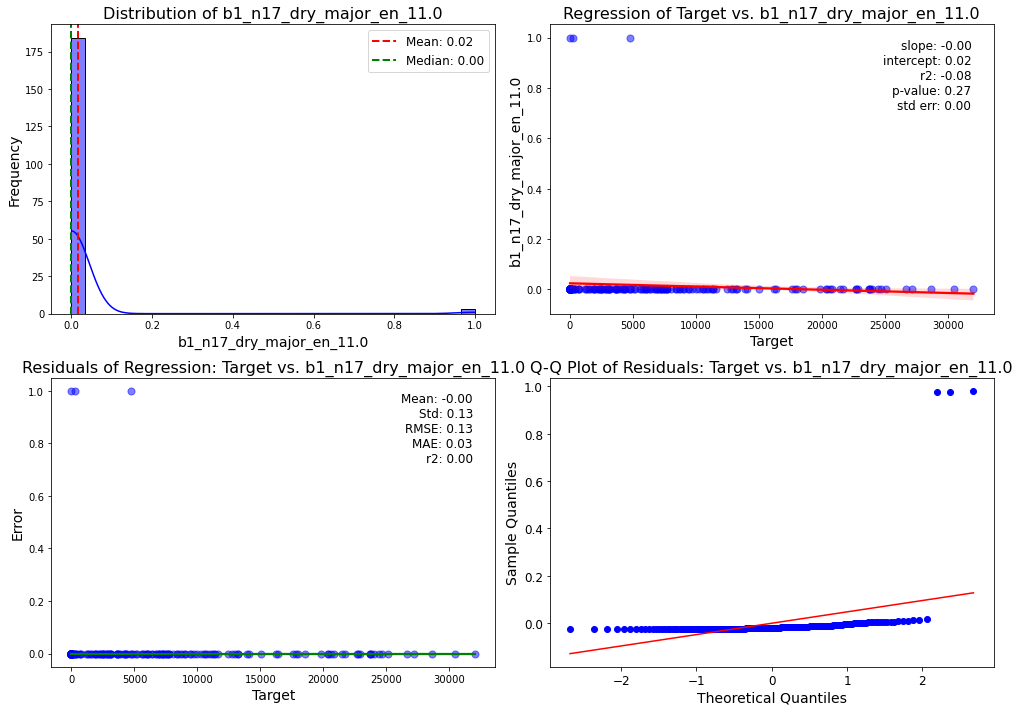

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_n17_dry_major_en_11.0_0_combined_plot_tr.JPG


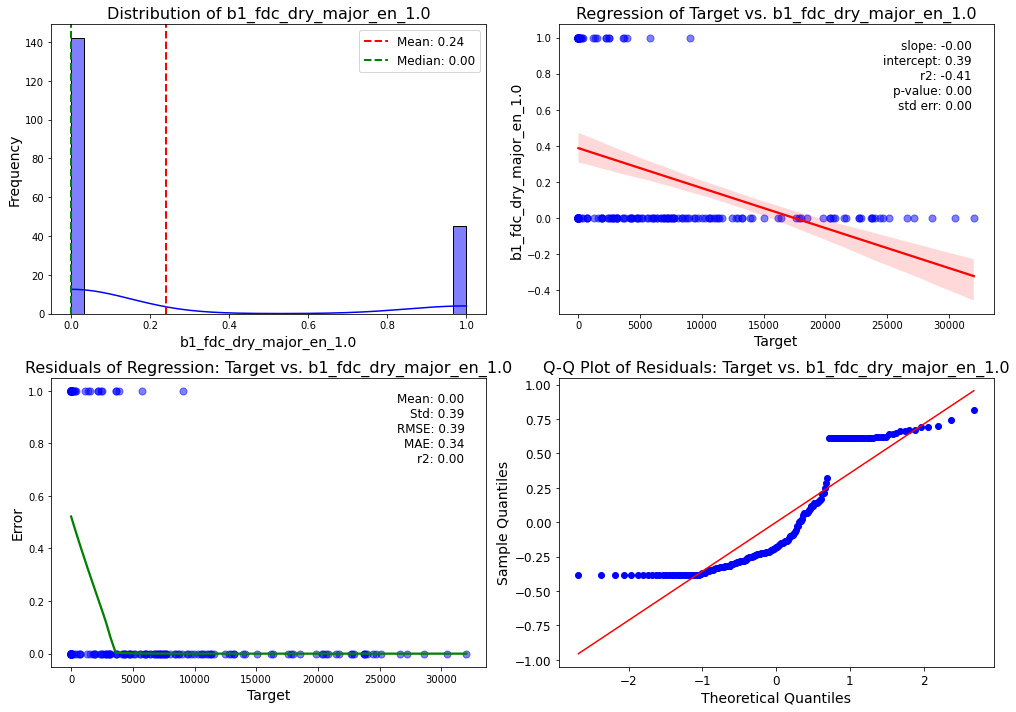

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_fdc_dry_major_en_1.0_0_combined_plot_tr.JPG


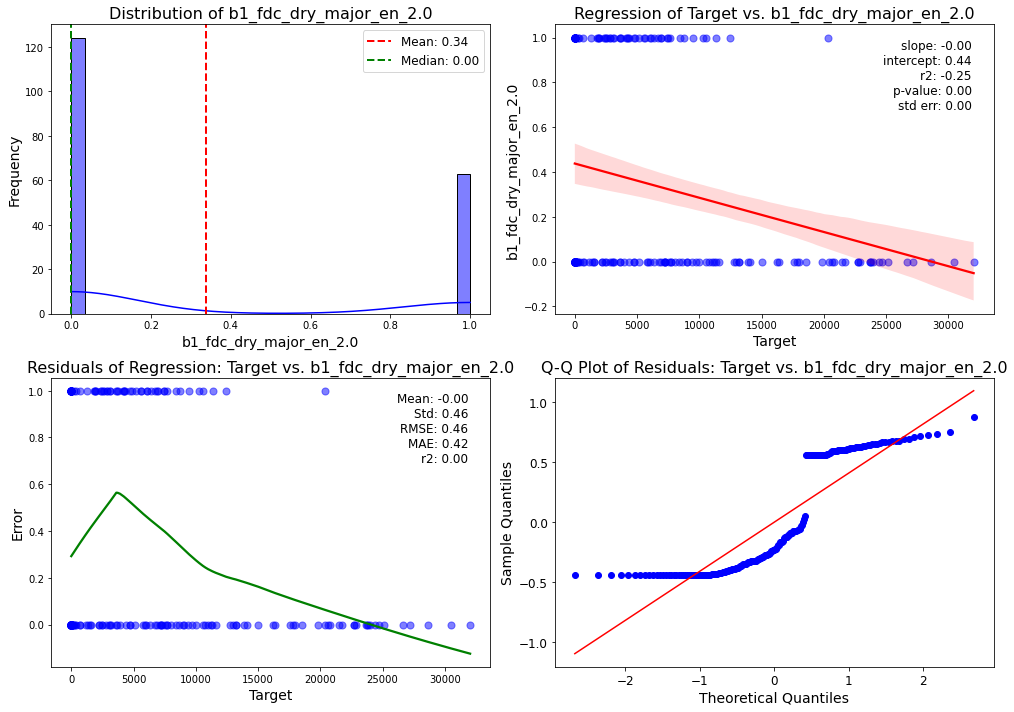

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_fdc_dry_major_en_2.0_0_combined_plot_tr.JPG


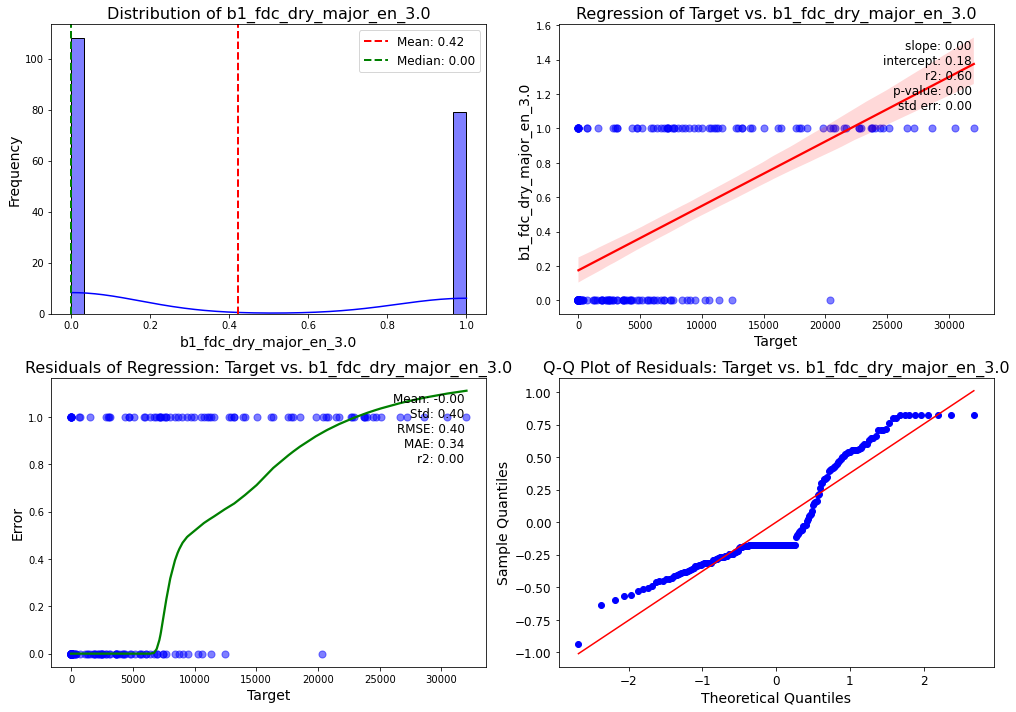

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_fdc_dry_major_en_3.0_0_combined_plot_tr.JPG


In [63]:
df = df_ml

def plot_with_mean_median(df, columns):
    for col in columns:
        plt.figure(figsize=(14, 10))

        # Top-left plot: Distribution with mean and median
        plt.subplot(2, 2, 1)
        sns.histplot(df[col], kde=True, color='blue', bins=30)
        
        # Calculate mean and median
        mean = df[col].mean()
        median = df[col].median()
        
        # Plot mean and median as dashed lines
        plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
        
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend(fontsize=12)
        
        # Top-right plot: Regression plot
        value_x = 'target'
        C_value_x = "Target"
        value_y_loop = col

        plt.subplot(2, 2, 2)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, line_kws={"color": "red"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel(value_y_loop, fontsize=14)
        plt.title(f"Regression of {C_value_x} vs. {value_y_loop}", fontsize=16)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_ml[value_x], df_ml[value_y_loop])

        # Annotate the stats
        plt.text(0.95, 0.95, f'slope: {slope:.2f}\nintercept: {intercept:.2f}\nr2: {r_value:.2f}\np-value: {p_value:.2f}\nstd err: {std_err:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', fontsize=12)

        # Bottom-left plot: Residuals plot
        plt.subplot(2, 2, 3)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, lowess=True, line_kws={"color": "green"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel("Error", fontsize=14)
        plt.title(f"Residuals of Regression: {C_value_x} vs. {value_y_loop}", fontsize=16)

        residuals = df_ml[value_y_loop] - (slope * df_ml[value_x] + intercept)

        # Compute additional residual statistics
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        rmse_res = np.sqrt(np.mean(residuals**2))
        mae_res = np.mean(np.abs(residuals))
        r2_res = scipy.stats.linregress(df_ml[value_x], residuals)[2]**2

        # Annotate the residual stats
        plt.text(0.95, 0.95, f'Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nRMSE: {rmse_res:.2f}\nMAE: {mae_res:.2f}\nr2: {r2_res:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', fontsize=12)

        # Bottom-right plot: Q-Q plot
        plt.subplot(2, 2, 4)
        scipy.stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot of Residuals: {C_value_x} vs. {value_y_loop}", fontsize=16)
        
        # Increase font size for Q-Q plot
        plt.xlabel('Theoretical Quantiles', fontsize=14)
        plt.ylabel('Sample Quantiles', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)

        plt.tight_layout()

        # Save the plot
        plt_out = os.path.join(output, "plots", f"{var_}_{mdl}_{value_y_loop}_{rs}_combined_plot_tr.JPG")
        plt.savefig(plt_out, dpi=300)
        plt.show()
        print("plot: ", plt_out)
        plt.close()

# Assuming df_ml.columns[1:] contains the columns to be plotted
plot_with_mean_median(df, df_ml.columns[1:])

plt.close('all')

In [64]:
df = df_ml

def plot_with_mean_median(df, columns):
    for col in columns:
        plt.figure(figsize=(14, 10))

        # Top-left plot: Distribution with mean and median
        plt.subplot(2, 2, 1)
        sns.histplot(df[col], kde=True, color='blue', bins=30)
        
        # Calculate mean and median
        mean = df[col].mean()
        median = df[col].median()
        
        # Plot mean and median as dashed lines
        plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
        
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend(fontsize=12)
        
        # Top-right plot: Regression plot
        value_x = 'target'
        C_value_x = 'Target'
        value_y_loop = col

        plt.subplot(2, 2, 2)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, line_kws={"color": "red"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel(value_y_loop, fontsize=14)
        plt.title(f"Regression of {C_value_x} vs. {value_y_loop}", fontsize=16)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_ml[value_x], df_ml[value_y_loop])

        # Annotate the stats
        plt.text(0.95, 0.05, f'slope: {slope:.2f}\nintercept: {intercept:.2f}\nr2: {r_value:.2f}\np-value: {p_value:.2f}\nstd err: {std_err:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=12)

        # Bottom-left plot: Residuals plot
        plt.subplot(2, 2, 3)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, lowess=True, line_kws={"color": "green"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel("Error", fontsize=14)
        plt.title(f"Residuals of Regression: {C_value_x} vs. {value_y_loop}", fontsize=16)

        residuals = df_ml[value_y_loop] - (slope * df_ml[value_x] + intercept)

        # Compute additional residual statistics
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        rmse_res = np.sqrt(np.mean(residuals**2))
        mae_res = np.mean(np.abs(residuals))
        r2_res = scipy.stats.linregress(df_ml[value_x], residuals)[2]**2

        # Annotate the residual stats
        plt.text(0.95, 0.05, f'Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nRMSE: {rmse_res:.2f}\nMAE: {mae_res:.2f}\nr2: {r2_res:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=12)

        # Bottom-right plot: Q-Q plot
        plt.subplot(2, 2, 4)
        scipy.stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot of Residuals: {C_value_x} vs. {value_y_loop}", fontsize=16)
        
        # Increase font size for Q-Q plot
        plt.xlabel('Theoretical Quantiles', fontsize=14)
        plt.ylabel('Sample Quantiles', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)

        plt.tight_layout()

        # Save the plot
        plt_out = os.path.join(output, "plots", f"{var_}_{mdl}_{value_y_loop}_{rs}_combined_plot_br.JPG")
        plt.savefig(plt_out, dpi=300)
        #plt.show()
        print("plot: ", plt_out)
        plt.close()

# Assuming df_ml.columns[1:] contains the columns to be plotted
plot_with_mean_median(df, df_ml.columns[1:])

plt.close('all')

plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_wfp_dry_mean_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_hsd_mean_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_hmc_mean_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_hcv_mean_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_h99_mean_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_ccw_dry_mean_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_b1_dbifm_dry_mean_0_combined_plot_br.JPG
plot:  C:\Users\robo

# Model

### Split off unseen test and train data

In [65]:
#select random state
#rs = 0

# randomly split data into train and test datasets, the user needs to define the variables 
xdata1 = df_ml.iloc[:, 1:].astype('float32')
ydata1 = df_ml[[value_x]].astype('float32')
ydata2 = ydata1.values
ydata = ydata2.ravel()
#y_data_float=ydata.astype("float32")
x_unseen, x_remaining, y_unseen, y_remaining = train_test_split(xdata1, ydata, train_size=0.20, random_state=rs) 
x_train, x_test, y_train, y_test = train_test_split(x_remaining, y_remaining, train_size=0.70, random_state=rs)  
print(x_unseen.shape, y_unseen.shape)
print("remaining.....")
print(x_remaining.shape, y_remaining.shape)
print("-"*50)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(37, 51) (37,)
remaining.....
(150, 51) (150,)
--------------------------------------------------
(105, 51) (105,)
(45, 51) (45,)


### Plot up Histograms for train and test datasets

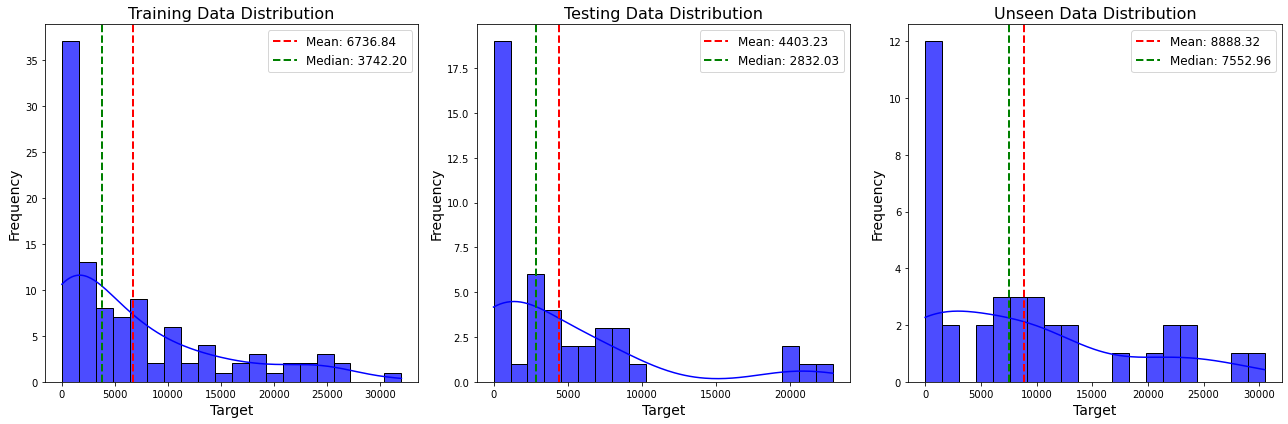

saved to:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\plots\adb_all_data_sddv4_mean_abr_0_train_test_unseen_distribution.JPG


In [66]:
import numpy as np
# output = '.'  # Replace with your actual output directory
# var_ = 'example_var'
# mdl = 'example_model'
# rs = 'example_run'

# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed

# Define the data and titles for each subplot
data = [y_train, y_test, y_unseen]
titles = ['Training Data Distribution', 'Testing Data Distribution', 'Unseen Data Distribution']

for i, (data_set, title) in enumerate(zip(data, titles)):
    mean = np.mean(data_set)
    median = np.median(data_set)
    
    # Plot histogram with seaborn
    sns.histplot(data_set, kde=True, bins=20, ax=axs[i], color='blue', alpha=0.7)
    
    # Plot mean and median lines
    axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    axs[i].axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
    
    axs[i].set_title(title, fontsize=16)
    axs[i].set_xlabel('Target', fontsize=14)
    axs[i].set_ylabel('Frequency', fontsize=14)
    axs[i].legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Save the figure
out = os.path.join(output, "plots", f"{var_}_{mdl}_{rs}_train_test_unseen_distribution.JPG")
plt.savefig(out, dpi=300)
plt.show()

print("saved to: ", out)

### Parameterise the Random Forest Regressor algorithm

for details see: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [67]:
#print(xdata1)

In [68]:
print(ydata)

[0.00000000e+00 8.37621582e+03 0.00000000e+00 2.46708008e+04
 3.08615991e+03 2.83203198e+03 0.00000000e+00 0.00000000e+00
 6.65280029e+02 0.00000000e+00 6.00600000e+03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.26887988e+03 3.08615991e+03
 1.34904004e+03 7.39199982e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.89419995e+03
 6.91222021e+03 9.99550977e+03 6.94678271e+03 7.65854248e+03
 9.38175000e+03 4.21067480e+03 7.20719971e+02 8.76869043e+03
 0.00000000e+00 2.43936011e+03 7.27558984e+03 2.39804609e+04
 1.79947598e+04 3.12312012e+03 7.47858984e+03 1.07633223e+04
 0.00000000e+00 2.66362949e+04 2.14691406e+04 2.26993906e+04
 1.11804004e+04 3.74219995e+03 0.00000000e+00 1.29608154e+04
 1.40824375e+04 1.32178555e+04 0.00000000e+00 2.21760010e+03
 0.00000000e+00 3.64839307e+03 4.72399902e+03 7.71539990e+03
 9.70896484e+03 4.71718799e+03 1.61970898e+04 1.27756299e+04
 4.87277686e+03 8.031450

In [69]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np


if mdl == "rfr":

    # Define model
    model = rfr()
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [2, 5, 10, 30, 40, 50, 100, 150, 200, 300], #5, 10, 20, 30, 40, 
        'max_depth': [None, 2, 3, 4, 5, 10, 20],
        # 'min_samples_split': [2, 3, 4, 5, 10],
        # 'min_samples_leaf': [1, 2, 3, 4, 5],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]
    }
elif mdl == "gbr":
    # Define model
    model = gbr()

    # Define parameter grid
    param_grid = {
    'n_estimators': [2, 5, 10, 30, 40, 50, 100, 150, 200, 300], #5, 10, 20, 30, 40, 
    'learning_rate': [0.01, 0.1, 1.0],
    }

elif mdl == "abr":
    # Define model
    model = abr()

    # Define parameter grid
    param_grid = {
    'n_estimators': [2, 5, 10, 30, 40, 50, 100, 150, 200, 300], #5, 10, 20, 30, 40, 
    'learning_rate': [0.01, 0.1, 1.0],
    }
else:
    print("ERROR__"*100)

# Define custom scorer for RMSE
def custom_rmse_scorer(y_true, y_pred):
    rmse = -np.sqrt(mean_squared_error(y_true, y_pred))
    #print("rmse: ", rmse)
    return rmse

# Define custom scorer for MAE
def custom_mae_scorer(y_true, y_pred):
    mae = -mean_absolute_error(y_true, y_pred)
    #print("mae: ", mae)
    return mae

# Define custom scorer for MAE
def custom_r2_scorer(y_true, y_pred):
    # Mean of true target values
    y_mean = np.mean(y_true)

    # Calculate sum of squares of residuals
    ss_residual = np.sum((y_true - y_pred) ** 2)

    # Calculate sum of squares of total
    ss_total = np.sum((y_true - y_mean) ** 2)
    # Calculate R^2
    r2 = 1 - (ss_residual / ss_total)

    return r2

r2_scorer = make_scorer(custom_r2_scorer)


# Make it a scorer
rmse_scorer = make_scorer(custom_rmse_scorer)
mae_scorer = make_scorer(custom_mae_scorer)
r2_scorer_ = make_scorer(custom_r2_scorer)
# -------------------------------------------------------------------

# Create GridSearchCV object with RMSE scoring
grid_search_rmse = GridSearchCV(model, param_grid, scoring=rmse_scorer, cv=5)
grid_search_rmse.fit(x_train, y_train)

# ----------------------------- RMSE ---------------------------------
print(mdl)
print("-"*100)
# Print the best score and parameters
print("RMSE Best Score: ", grid_search_rmse.best_score_)
print("RMSE Best Parameters: ", grid_search_rmse.best_params_)

# ----------------------------- MAE ---------------------------------

# Create GridSearchCV object with MAE scoring
grid_search_mae = GridSearchCV(model, param_grid, scoring=mae_scorer, cv=5)
grid_search_mae.fit(x_train, y_train)

# Print the best score and parameters
print("MAE Best Score: ", grid_search_mae.best_score_)
print("MAE Best Parameters: ", grid_search_mae.best_params_)


abr
----------------------------------------------------------------------------------------------------
RMSE Best Score:  -5561.367031096506
RMSE Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 10}
MAE Best Score:  -3813.2815811870796
MAE Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 40}


In [70]:
# Get best RMSE parameters
#best_params = grid_search_rmse.best_params_
best_model = grid_search_rmse.best_estimator_
fac = "RMSE"
print("RMSE Best Score: ", grid_search_rmse.best_score_)
print("RMSE Best Parameters: ", grid_search_rmse.best_params_)
print(best_model)

RMSE Best Score:  -5561.367031096506
RMSE Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 10}
AdaBoostRegressor(learning_rate=0.01, n_estimators=10)


In [71]:
# Get best MAE parameters
#best_params = grid_search_rmse.best_params_
best_model = grid_search_mae.best_estimator_
fac = "MAE"
print("MAE Best Score: ", grid_search_mae.best_score_)
print("MAE Best Parameters: ", grid_search_mae.best_params_)
print(best_model)

MAE Best Score:  -3813.2815811870796
MAE Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 40}
AdaBoostRegressor(learning_rate=0.01, n_estimators=40)


In [72]:
#print(grid_search_mae.best_estimator_)

### Enter manualy when required

In [73]:
#Manual 
#best_model = rfr(n_estimators=100)

### Fit regressor model and compute variable importance score 

may need to restrict the number of variables for the bar graph to be legible



In [74]:
#tree_model = best_model.fit(X_1, y_1)
tree_model = best_model.fit(x_train, y_train)

##### good info on the feature importance score - http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined

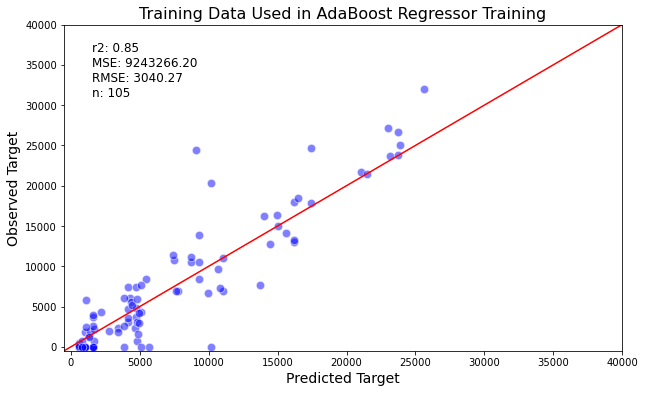

saved to:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_abr_MAE_0_train.JPG


In [75]:
plt.figure(figsize=(10, 6))
feature_importance = tree_model.feature_importances_

### TRY THIS
# use "feature importance" scores to see what the top 10 important features are
fi = enumerate(tree_model.feature_importances_)
cols = xdata1.columns
fiResult = [(value,cols[i]) for (i,value) in fi]

r2 = round(tree_model.score(x_train, y_train),2)
mse = round(np.mean((y_train - tree_model.predict(x_train))**2), 2)
rmse = round(np.sqrt(np.mean((y_train - tree_model.predict(x_train))**2)), 2)
              

plt.scatter(tree_model.predict(x_train), y_train, s= 70, alpha=0.5, color='blue', edgecolors='w')  
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500, 40000)

plt.plot(x, y, color='red')#, linestyle='dashed', linewidth=2)

# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Training Data Used in {model_name} Training', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nn: {len(y_train)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

out = os.path.join(output, "{0}_{1}_{2}_{3}_train.JPG".format(var_, mdl, fac, str(rs)))
#print(out)                   
plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()

print("saved to: ", out)

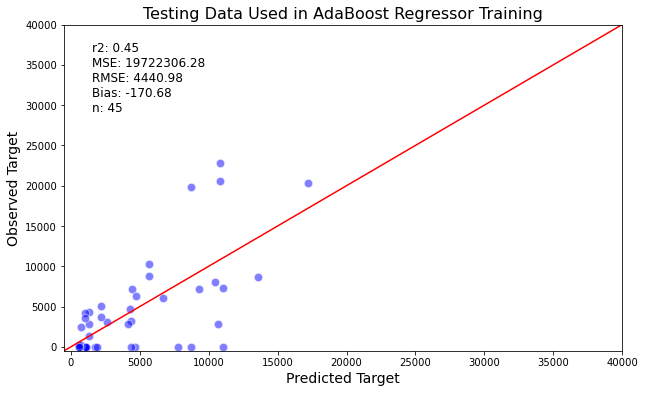

Plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_abr_MAE_0_test_data.JPG


In [76]:
plt.figure(figsize=(10, 6))
y2_predict = tree_model.predict(x_test)

r2 = round(tree_model.score(x_test, y_test),2)
mse = round(np.mean((y_test - tree_model.predict(x_test))** 2), 2)
rmse = round(np.sqrt(np.mean((y2_predict - y_test) ** 2)), 2)
bias = round(np.mean(y_test) - np.mean(y2_predict), 2)
var = round(explained_variance_score(y_test, y2_predict), 2)

plt.scatter(y2_predict, y_test, s= 70, alpha=0.5, color='blue', edgecolors='w')# ,s=10, c='b', marker='o')
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500, 40000)
# plt.ylabel('Observed AGB')
# plt.xlabel('Predicted AGB')
# plt.title(f'Testing data: {mdl}')
# 1 for 1 line
plt.plot(x, y, color = 'r')



# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Testing Data Used in {model_name} Training', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nBias: {bias:.2f}\nn: {len(y_test)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

# Explained variance is R2
out_plot = os.path.join(output, "{0}_{1}_{2}_{3}_test_data.JPG".format(var_, mdl, fac, str(rs)))
# Save the plot
plt.savefig(out_plot, dpi=300)
plt.show()
print("Plot: ", out_plot)

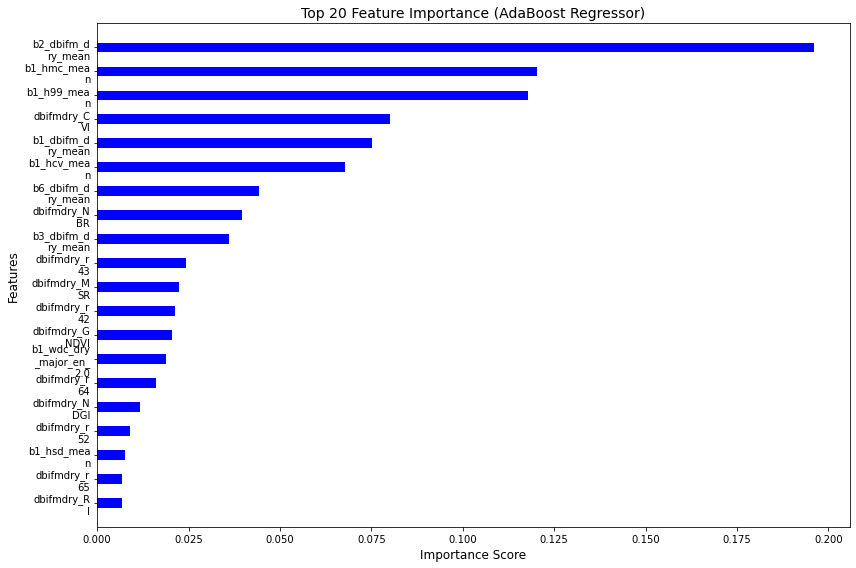

C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_Top20_Feature_Importance_Score.JPG


In [77]:
# Generate feature importance and related data
fi = enumerate(feature_importance)
cols = xdata1.columns
fiResult = np.array([(value, cols[i]) for (i, value) in fi])

score = fiResult[:, 0].astype(float)
score_4 = np.around(score, decimals=4)
band = fiResult[:, 1]

df_band = pd.DataFrame(dict(band=band, n=score_4))
df_band['n'] = df_band['n'].astype(float)
dfsort = df_band.sort_values(['n'], ascending=[False]).head(20)  # Select top 20 features

ind = np.arange(len(dfsort))
width = 0.4

# Increase figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot
ax.barh(ind, dfsort['n'], width, color='blue')

# Adjust y-tick labels
wrapped_labels = [textwrap.fill(label, 10) for label in dfsort['band']]
ax.set(yticks=ind, yticklabels=wrapped_labels, ylim=[-1, len(dfsort)])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title(f'Top 20 Feature Importance ({model_name})', fontsize=14)

# Reverse the order of y-axis to display highest to lowest
ax.invert_yaxis()

# Adjust layout
plt.tight_layout()

out = os.path.join(output, f"{var_}_{fac}_{mdl}_Top20_Feature_Importance_Score.JPG")
plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print(out)

                        band    n
10         b2_dbifm_dry_mean 0.20
2                b1_hmc_mean 0.12
4                b1_h99_mean 0.12
26              dbifmdry_CVI 0.08
6          b1_dbifm_dry_mean 0.08
3                b1_hcv_mean 0.07
14         b6_dbifm_dry_mean 0.04
29              dbifmdry_NBR 0.04
11         b3_dbifm_dry_mean 0.04
16              dbifmdry_r43 0.02
34              dbifmdry_MSR 0.02
15              dbifmdry_r42 0.02
25            dbifmdry_GNDVI 0.02
36   b1_wdc_dry_major_en_2.0 0.02
22              dbifmdry_r64 0.02
27             dbifmdry_NDGI 0.01
17              dbifmdry_r52 0.01
1                b1_hsd_mean 0.01
23              dbifmdry_r65 0.01
28               dbifmdry_RI 0.01
0            b1_wfp_dry_mean 0.01
9          b3_dp1fm_dry_mean 0.01
7          b1_dp1fm_dry_mean 0.01
20              dbifmdry_r62 0.01
32            dbifmdry_MSAVI 0.01
8          b2_dp1fm_dry_mean 0.00
45   b1_n17_dry_major_en_8.0 0.00
21              dbifmdry_r63 0.00
30            

<Figure size 864x576 with 0 Axes>

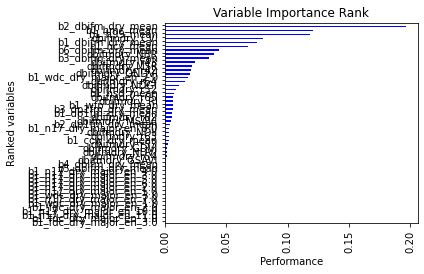

C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_Band_Importance_Score.JPG


In [78]:
plt.figure(figsize=(12, 8))
fiResult = np.array(fiResult)
score = (fiResult[:,0])
arr_unicode =score
# Convert Unicode strings to float values
arr_float = arr_unicode.astype(np.float)

# Round float values to two decimal places
score_4 = np.around(arr_float, decimals=4)

band = fiResult[:,1]
a = fiResult[np.argsort(fiResult[:, 1])]

df_band = pd.DataFrame(dict(band=band,n=score_4))
df_band['n'].astype('float')
dfsort = df_band.sort_values(['n'], ascending=[False])
print(dfsort)
 
## my complicated way to get the bar plot to sort in ascending order and display the assocated band names in the y axis
dfsort2 = df_band.sort_values(['n'], ascending=[True])
b = dfsort2[['band']]
c = b.values.tolist()
# convert the list of band names in the correct order to a string
e = str(c)
# strips all the rubbish from the string
f = e.replace('[','').replace(']','').replace("'",'').replace(",",' ')
# convert the cleaned up string back into a list to plot the band names in the bar graph
g = f.split()
 
ind = np.arange(len(df_band))
width = 0.4
print("ind: ", ind) 
fig, ax = plt.subplots()
ax.barh(ind, dfsort2.n, width, color='blue')
ax.set(yticks=ind + width, yticklabels= g, ylim=[2*width - 1, len(df_band)])
ax.set_xlabel('Performance') #, rotation=45)
ax.set_ylabel('Ranked variables') #, rotation=45)
plt.xticks(rotation='vertical')
ax.set_title('Variable Importance Rank')

# Adjust layout
plt.tight_layout()


out = os.path.join(output, "{0}_{1}_{2}_Band_Importance_Score.JPG".format(var_, fac, mdl))
plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print(out)

### Predict the selected model on the test data

In [79]:
dfsort.shape

(51, 2)

In [80]:
df_band.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    51 non-null     object 
 1   n       51 non-null     float64
dtypes: float64(1), object(1)
memory usage: 944.0+ bytes


In [81]:
dfsort['n'].astype('float')
dfsort.info()
dfsort['n'] = dfsort['n'].astype('float')
dfsort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 10 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    51 non-null     object 
 1   n       51 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 10 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    51 non-null     object 
 1   n       51 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [82]:
#Plot has value at the top with very small n value 

In [83]:
#Plot has value at the top with very small n value

sel_num = 12
df_var = dfsort.head(sel_num)

In [84]:
#df_var = dfsort[dfsort['n'] > 0.01]

In [85]:
column_var = df_var.band.tolist()

In [86]:
column_var.insert(0, 'target')

In [87]:
column_var

['target',
 'b2_dbifm_dry_mean',
 'b1_hmc_mean',
 'b1_h99_mean',
 'dbifmdry_CVI',
 'b1_dbifm_dry_mean',
 'b1_hcv_mean',
 'b6_dbifm_dry_mean',
 'dbifmdry_NBR',
 'b3_dbifm_dry_mean',
 'dbifmdry_r43',
 'dbifmdry_MSR',
 'dbifmdry_r42']

In [88]:
df_ml

target  b1_wfp_dry_mean  b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  \
0       0.00            45.89       103.63       107.13       151.32   
1    8376.22            44.00       103.88       106.25       169.41   
2       0.00             3.33       101.58       103.49       137.70   
3   24670.80            34.83       103.14       105.14       157.61   
4    3086.16            29.78       103.02       104.74       163.29   
..       ...              ...          ...          ...          ...   
195   240.24             2.25       100.94       102.21       140.04   
196     0.00            11.92       102.08       103.29       156.05   
197     0.00             7.89       100.82       101.59       144.41   
198     0.00             6.00       101.01       101.96       131.00   
199     0.00             1.00       100.89       101.59       138.83   

     b1_h99_mean  b1_ccw_dry_mean  b1_dbifm_dry_mean  b1_dp1fm_dry_mean  \
0         114.13            68.00             373.67              10.67   
1         113.93            66.00             292.44               1.33   
2         106.57             6.92             412.33               0.67   
3         111.49            54.75             223.58               8.75   
4         110.91            48.33             259.56               5.22   
..           ...              ...                ...                ...   
195       103.96             2.25             738.67              35.33   
196       107.97            21.25             692.08              30.33   
197       103.81            14.22             582.56               1.78   
198       104.01            11.00             710.88              21.38   
199       103.90             1.00             625.56               5.78   

     b2_dp1fm_dry_mean  ...  b1_n17_dry_major_en_4.0  b1_n17_dry_major_en_5.0  \
0                44.33  ...                        1                        0   
1                43.67  ...                        0                        0   
2                10.42  ...                        0                        0   
3                37.25  ...                        1                        0   
4                33.78  ...                        1                        0   
..                 ...  ...                      ...                      ...   
195               5.75  ...                        0                        0   
196              19.67  ...                        0                        0   
197              15.67  ...                        0                        0   
198               2.50  ...                        0                        0   
199               2.00  ...                        0                        0   

     b1_n17_dry_major_en_6.0  b1_n17_dry_major_en_7.0  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   
..                       ...                      ...   
195                        0                        0   
196                        0                        1   
197                        0                        0   
198                        1                        0   
199                        0                        0   

     b1_n17_dry_major_en_8.0  b1_n17_dry_major_en_10.0  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   
..                       ...                       ...   
195                        0                         1   
196                        0                         0   
197                        0                         0   
19

In [89]:
select_df = df_ml[column_var]

In [90]:
df_corr = select_df.corr()
df_corr

target  b2_dbifm_dry_mean  b1_hmc_mean  b1_h99_mean  \
target               1.00              -0.62         0.71         0.70   
b2_dbifm_dry_mean   -0.62               1.00        -0.70        -0.75   
b1_hmc_mean          0.71              -0.70         1.00         0.96   
b1_h99_mean          0.70              -0.75         0.96         1.00   
dbifmdry_CVI         0.61              -0.72         0.74         0.75   
b1_dbifm_dry_mean   -0.61               0.97        -0.71        -0.76   
b1_hcv_mean          0.18              -0.50         0.26         0.42   
b6_dbifm_dry_mean   -0.62               0.83        -0.75        -0.75   
dbifmdry_NBR         0.58              -0.51         0.75         0.69   
b3_dbifm_dry_mean   -0.63               0.98        -0.70        -0.74   
dbifmdry_r43         0.72              -0.80         0.83         0.81   
dbifmdry_MSR         0.72              -0.82         0.83         0.82   
dbifmdry_r42         0.70              -0.80         0.84         0.83   

                   dbifmdry_CVI  b1_dbifm_dry_mean  b1_hcv_mean  \
target                     0.61              -0.61         0.18   
b2_dbifm_dry_mean         -0.72               0.97        -0.50   
b1_hmc_mean                0.74              -0.71         0.26   
b1_h99_mean                0.75              -0.76         0.42   
dbifmdry_CVI               1.00              -0.78         0.21   
b1_dbifm_dry_mean         -0.78               1.00        -0.47   
b1_hcv_mean                0.21              -0.47         1.00   
b6_dbifm_dry_mean         -0.68               0.81        -0.31   
dbifmdry_NBR               0.73              -0.55        -0.00   
b3_dbifm_dry_mean         -0.64               0.93        -0.50   
dbifmdry_r43               0.80              -0.80         0.23   
dbifmdry_MSR               0.81              -0.82         0.26   
dbifmdry_r42               0.94              -0.83         0.24   

                   b6_dbifm_dry_mean  dbifmdry_NBR  b3_dbifm_dry_mean  \
target                         -0.62          0.58              -0.63   
b2_dbifm_dry_mean               0.83         -0.51               0.98   
b1_hmc_mean                    -0.75          0.75              -0.70   
b1_h99_mean                    -0.75          0.69              -0.74   
dbifmdry_CVI                   -0.68          0.73              -0.64   
b1_dbifm_dry_mean               0.81         -0.55               0.93   
b1_hcv_mean                    -0.31         -0.00              -0.50   
b6_dbifm_dry_mean               1.00         -0.84               0.85   
dbifmdry_NBR                   -0.84          1.00              -0.53   
b3_dbifm_dry_mean               0.85         -0.53               1.00   
dbifmdry_r43                   -0.85          0.84              -0.82   
dbifmdry_MSR                   -0.87          0.84              -0.84   
dbifmdry_r42                   -0.82          0.83              -0.78   

                   dbifmdry_r43  dbifmdry_MSR  dbifmdry_r42  
target                     0.72          0.72          0.70  
b2_dbifm_dry_mean         -0.80         -0.82         -0.80  
b1_hmc_mean                0.83          0.83          0.84  
b1_h99_mean                0.81          0.82          0.83  
dbifmdry_CVI               0.80          0.81          0.94  
b1_dbifm_dry_mean         -0.80         -0.82         -0.83  
b1_hcv_mean                0.23          0.26          0.24  
b6_dbifm_dry_mean         -0.85         -0.87         -0.82  
dbifmdry_NBR               0.84          0.84          0.83  
b3_dbifm_dry_mean         -0.82         -0.84         -0.78  
dbifmdry_r43               1.00          1.00          0.96  
dbifmdry_MSR               1.00          1.00          0.96  
dbifmdry_r42               0.96          0.96          1.00

In [91]:
dfsort.to_csv(os.path.join(output, "{0}_{1}_{2}_variable_score.csv".format(var_, fac, mdl)))
df_corr.to_csv(os.path.join(output, "{0}_{1}_{2}_select_variable_correlation.csv".format(var_, fac, mdl)))

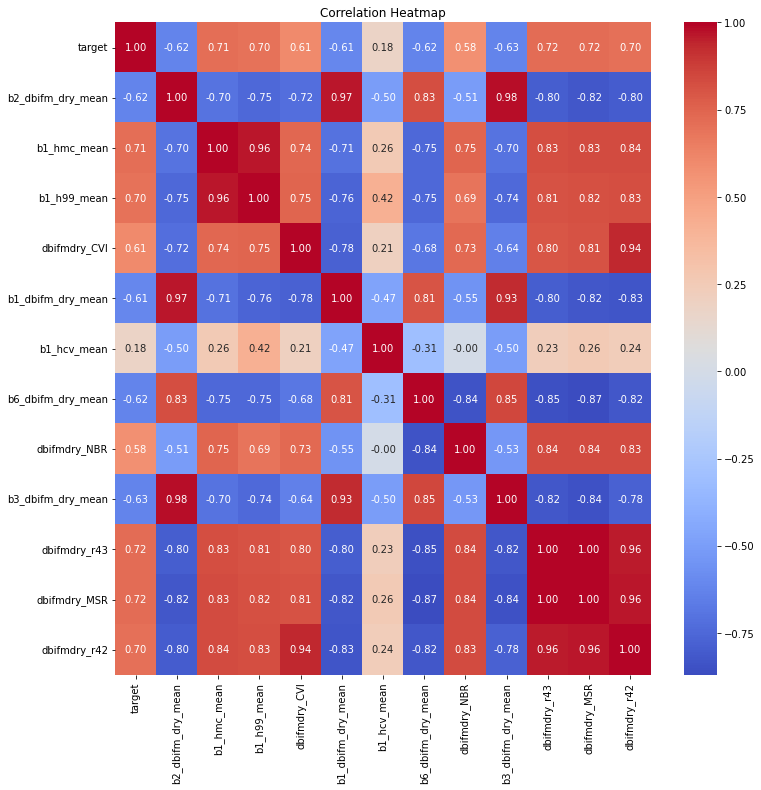

Plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_variable_score.JPG


In [92]:
# Create heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

# Save the plot
plot_out = os.path.join(output, "{0}_{1}_{2}_variable_score.JPG".format(var_, fac, mdl))
plt.savefig(plot_out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print("Plot: ", plot_out)

In [93]:
select_df

target  b2_dbifm_dry_mean  b1_hmc_mean  b1_h99_mean  dbifmdry_CVI  \
0       0.00             561.00       107.13       114.13      47885270   
1    8376.22             500.78       106.25       113.93      50775600   
2       0.00             677.25       103.49       106.57      58363315   
3   24670.80             395.83       105.14       111.49      47524435   
4    3086.16             477.00       104.74       110.91      42394332   
..       ...                ...          ...          ...           ...   
195   240.24            1187.67       102.21       103.96      30388263   
196     0.00            1073.92       103.29       107.97      34182549   
197     0.00             952.56       101.59       103.81      42441388   
198     0.00            1124.31       101.96       104.01      29196771   
199     0.00             977.56       101.59       103.90      36003359   

     b1_dbifm_dry_mean  b1_hcv_mean  b6_dbifm_dry_mean  dbifmdry_NBR  \
0               373.67       151.32            1323.67       1964774   
1               292.44       169.41            1071.33       2881356   
2               412.33       137.70            1729.75       1429988   
3               223.58       157.61             940.25       2241024   
4               259.56       163.29            1005.33       2197205   
..                 ...          ...                ...           ...   
195             738.67       140.04            2886.00       -653378   
196             692.08       156.05            2237.25        742810   
197             582.56       144.41            1794.67       2065458   
198             710.88       131.00            1735.06       1488840   
199             625.56       138.83            1760.00       1487304   

     b3_dbifm_dry_mean  dbifmdry_r43  dbifmdry_MSR  dbifmdry_r42  
0               765.67      25729212       6047316      35115865  
1               655.89      29561240       7201101      38717550  
2              1160.92      19867920       4099401      34056848  
3               500.67      29630493       7222079      37477895  
4               614.67      25573030       5995724      32953645  
..                 ...           ...           ...           ...  
195            1691.17      14977333       2236580      21326831  
196            1516.33      17125192       3085874      24180182  
197            1410.00      19351458       3909535      28644582  
198            1575.38      14872253       2194196      20838846  
199            1447.78      16409056       2811428      24302114  

[187 rows x 13 columns]

# Rerun on Selected data

In [94]:
xdata = select_df.iloc[:, 1:].astype('float32')
ydata1 = select_df[[value_x]].astype('float32')
ydata2 = ydata1.values
ydata = ydata2.ravel()

X_1, X_2, y_1, y_2 = train_test_split(xdata, ydata, train_size=0.70)  
         
print(X_1.shape, y_1.shape)
print(X_2.shape, y_2.shape)

(130, 12) (130,)
(57, 12) (57,)


In [95]:
select_df

target  b2_dbifm_dry_mean  b1_hmc_mean  b1_h99_mean  dbifmdry_CVI  \
0       0.00             561.00       107.13       114.13      47885270   
1    8376.22             500.78       106.25       113.93      50775600   
2       0.00             677.25       103.49       106.57      58363315   
3   24670.80             395.83       105.14       111.49      47524435   
4    3086.16             477.00       104.74       110.91      42394332   
..       ...                ...          ...          ...           ...   
195   240.24            1187.67       102.21       103.96      30388263   
196     0.00            1073.92       103.29       107.97      34182549   
197     0.00             952.56       101.59       103.81      42441388   
198     0.00            1124.31       101.96       104.01      29196771   
199     0.00             977.56       101.59       103.90      36003359   

     b1_dbifm_dry_mean  b1_hcv_mean  b6_dbifm_dry_mean  dbifmdry_NBR  \
0               373.67       151.32            1323.67       1964774   
1               292.44       169.41            1071.33       2881356   
2               412.33       137.70            1729.75       1429988   
3               223.58       157.61             940.25       2241024   
4               259.56       163.29            1005.33       2197205   
..                 ...          ...                ...           ...   
195             738.67       140.04            2886.00       -653378   
196             692.08       156.05            2237.25        742810   
197             582.56       144.41            1794.67       2065458   
198             710.88       131.00            1735.06       1488840   
199             625.56       138.83            1760.00       1487304   

     b3_dbifm_dry_mean  dbifmdry_r43  dbifmdry_MSR  dbifmdry_r42  
0               765.67      25729212       6047316      35115865  
1               655.89      29561240       7201101      38717550  
2              1160.92      19867920       4099401      34056848  
3               500.67      29630493       7222079      37477895  
4               614.67      25573030       5995724      32953645  
..                 ...           ...           ...           ...  
195            1691.17      14977333       2236580      21326831  
196            1516.33      17125192       3085874      24180182  
197            1410.00      19351458       3909535      28644582  
198            1575.38      14872253       2194196      20838846  
199            1447.78      16409056       2811428      24302114  

[187 rows x 13 columns]

# Set model with feature names for Notebook testing

In [96]:
select_tree_model = best_model.fit(X_1, y_1)

## Re-train model on selected paramiters

Fitted model r2 = 0.77
Fitted model mse = 14800653.72
n = 130


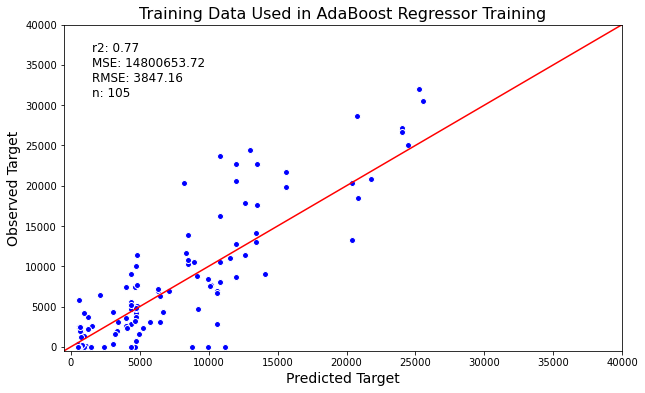

Plot:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_sel12_train.JPG


In [97]:
plt.figure(figsize=(10, 6))
feature_importance = best_model.feature_importances_

### TRY THIS
# use "feature importance" scores to see what the top 10 important features are
fi = enumerate(best_model.feature_importances_)
cols = xdata1.columns
fiResult = [(value,cols[i]) for (i,value) in fi]
#fiResult = [(value,cols[i]) for (i,value) in fi if value > 0.001]
## Change the value 0.04 which we picked empirically to give us 10 variables
## try running this code after changing the value up and down so you get more or less variables
## do you see how this might be useful in refining the model?
## Here is the code in case you mess up the line above
## [(value,cols[i]) for (i,value) in fi if value > 0.04]
#print fiResult

print('Fitted model r2 =' ,  format(select_tree_model.score(X_1, y_1), '.2f'))
print('Fitted model mse =', format(np.mean((y_1 - select_tree_model.predict(X_1))**2), '.2f'))
print('n =', len(y_1))

r2 = round(select_tree_model.score(X_1, y_1),2)
mse = round(np.mean((y_1 - select_tree_model.predict(X_1))** 2), 2)
rmse = round(np.sqrt(np.mean((y_1 - select_tree_model.predict(X_1))** 2)), 2)
#bias = round(np.mean(y_2) - np.mean(y2_predict), 2)


plt.scatter(select_tree_model.predict(X_1), y_1, s= 70, alpha=0.5, color='blue', edgecolors='w') 
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500,40000)


# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Training Data Used in {model_name} Training', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nn: {len(y_train)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


# 1 for 1 line

plt.plot(x, y, color = 'r')

plt_out = os.path.join(output, "{0}_{1}_{2}_sel{3}_train.JPG".format(var_, fac, mdl, sel_num))
plt.savefig(plt_out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print("Plot: ", plt_out)

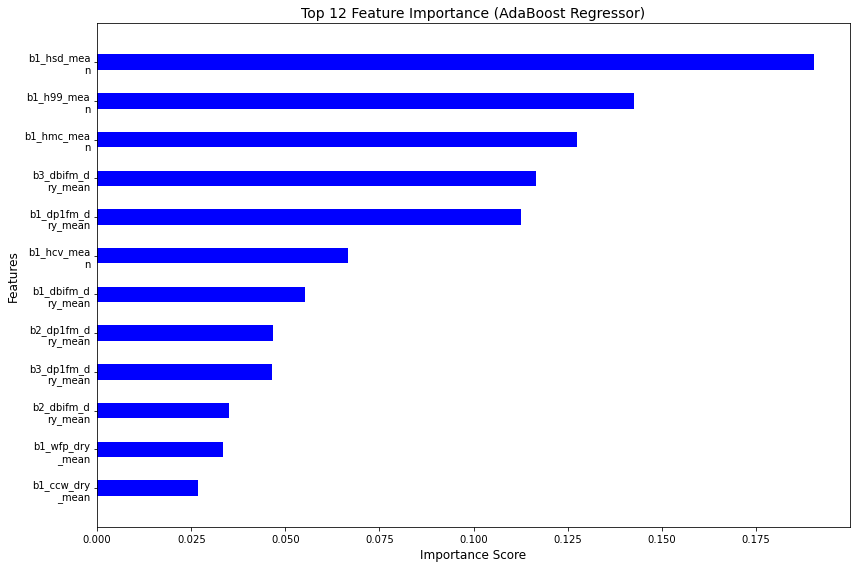

C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_select_12_Band_Importance_Score.JPG


In [98]:
# Generate feature importance and related data
fi = enumerate(feature_importance)
cols = xdata1.columns
fiResult = np.array([(value, cols[i]) for (i, value) in fi])

score = fiResult[:, 0].astype(float)
score_4 = np.around(score, decimals=4)
band = fiResult[:, 1]

df_band = pd.DataFrame(dict(band=band, n=score_4))
df_band['n'] = df_band['n'].astype(float)
dfsort = df_band.sort_values(['n'], ascending=[False]).head(20)  # Select top 20 features

ind = np.arange(len(dfsort))
width = 0.4

# Increase figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot
ax.barh(ind, dfsort['n'], width, color='blue')

# Adjust y-tick labels
wrapped_labels = [textwrap.fill(label, 10) for label in dfsort['band']]
ax.set(yticks=ind, yticklabels=wrapped_labels, ylim=[-1, len(dfsort)])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title(f'Top {str(sel_num)} Feature Importance ({model_name})', fontsize=14)

# Reverse the order of y-axis to display highest to lowest
ax.invert_yaxis()

# Adjust layout
plt.tight_layout()

out = os.path.join(output, "{0}_{1}_{2}_select_{3}_Band_Importance_Score.JPG".format(var_, fac, mdl, str(sel_num)))
plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print(out)

C:\Users\robot\anaconda3\envs\biomass_zonal\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\robot\anaconda3\envs\biomass_zonal\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\robot\anaconda3\envs\biomass_zonal\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


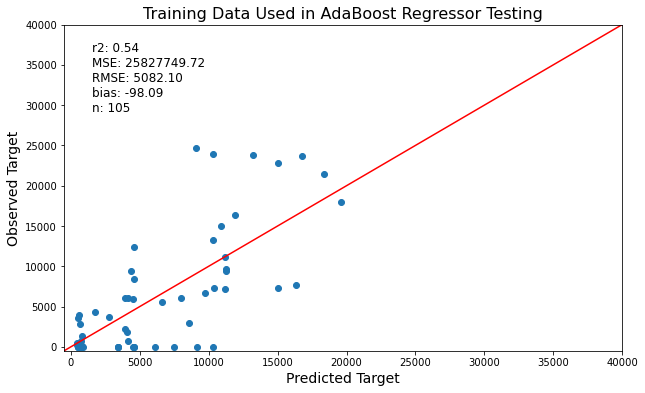

In [121]:
plt.figure(figsize=(10, 6))
y2_predict = select_tree_model.predict(X_2)

r2 = round(select_tree_model.score(X_2, y_2),2)
mse = round(np.mean((y_2 - select_tree_model.predict(X_2))** 2), 2)
rmse = round(np.sqrt(np.mean((y2_predict - y_2) ** 2)), 2)
bias = round(np.mean(y_2) - np.mean(y2_predict), 2)
var = round(explained_variance_score(y_2, y2_predict), 2)

plt.scatter(y2_predict, y_2, s= 70, alpha=0.5, color='blue', edgecolors='w')
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500, 40000)
# plt.ylabel('Observed mean AGB')
# plt.xlabel('Predicted mean AGB')
# plt.title(f'Testing selected {str(sel_num)} data: {var_} - {mdl}')
# # 1 for 1 line
plt.plot(x, y, color = 'r')

# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Training Data Used in {model_name} Testing', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nbias: {bias:.2f}\nn: {len(y_train)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)




# Save the plot
plt.savefig(os.path.join(output, "{0}_{1}_{2}_sel{3}_test.pdf".format(var_, fac, mdl, sel_num)), dpi=300)  # dpi sets the resolution in dots per inch
plt.show()

In [100]:
variable_imp_list = dfsort.band.to_list()
print(variable_imp_list)

['b1_hsd_mean', 'b1_h99_mean', 'b1_hmc_mean', 'b3_dbifm_dry_mean', 'b1_dp1fm_dry_mean', 'b1_hcv_mean', 'b1_dbifm_dry_mean', 'b2_dp1fm_dry_mean', 'b3_dp1fm_dry_mean', 'b2_dbifm_dry_mean', 'b1_wfp_dry_mean', 'b1_ccw_dry_mean']


# =================================================================

# STOP - do you realy want to save this model?

# remember to change the cPickle file name !!

# Save current fitted model and apply to unseen validation data 

In [101]:
select_tree_model

AdaBoostRegressor(learning_rate=0.01, n_estimators=40)

In [102]:
import pickle

#rfrL8CHM = rfr()
#rfrL8CHM.fit(X_1, y_1)
pickle_file = os.path.join(output, "{0}_{1}_{2}_sel_{3}_{4}_model.pickle".format(var_, fac, mdl, sel_num, samp))
with open(pickle_file, 'wb') as f:
    pickle.dump(select_tree_model, f)
print("pickle saved: ", pickle_file)

pickle saved:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_sel_12_all_data_model.pickle


In [103]:
# read in your validation dataset which has never been seen by rfr model - NOTE in this example I am just reading the same data used to train the model
y_unseen
x_unseen
#unseen_data

b1_wfp_dry_mean  b1_hsd_mean  b1_hmc_mean  b1_hcv_mean  b1_h99_mean  \
122            40.00       103.11       105.19       160.74       111.95   
33             19.31       103.99       107.02       164.95       114.34   
165            45.58       104.70       109.83       151.26       117.52   
136            49.50       104.72       109.95       150.23       117.58   
180            24.11       103.65       106.96       158.12       112.85   
34             39.75       105.59       108.43       171.89       118.45   
152            48.89       103.36       106.07       156.67       112.97   
169            17.22       103.50       104.50       179.02       112.07   
157            45.78       105.16       108.57       162.49       117.74   
31             46.92       102.43       104.48       152.80       109.43   
107            18.92       102.59       104.13       158.64       110.30   
90              3.90       101.86       102.64       166.36       107.86   
87             29.92       104.29       108.91       153.49       115.75   
123            25.86       101.32       102.67       138.21       105.49   
158            12.00       102.37       103.19       169.57       108.65   
194             4.00       101.39       102.63       144.78       105.48   
79              7.08       101.13       102.22       148.90       105.49   
85             57.44       105.31       110.80       149.83       119.39   
27              4.56       101.91       103.04       152.59       107.46   
176             2.00       101.66       102.80       154.78       106.98   
89             50.92       104.80       110.54       147.84       118.50   
187            31.33       102.74       105.78       141.90       109.55   
189            43.25       105.17       109.40       158.99       118.35   
42             44.25       104.88       108.75       158.50       116.92   
64             27.33       103.54       106.55       158.31       113.57   
150            37.78       104.56       109.32       149.50       117.13   
96              5.00       101.73       102.90       146.47       106.22   
77              7.92       102.72       104.46       164.19       110.74   
95             16.33       103.16       105.54       156.56       111.38   
38              6.56       102.36       104.48       149.28       108.80   
23              4.57       101.61       102.74       145.63       106.91   
10             26.62       102.02       103.76       152.15       102.47   
111             2.33       101.16       102.01       155.80       105.36   
73             16.06       102.94       104.52       166.65       110.97   
125            18.67       102.48       104.14       161.56       109.14   
52             41.25       104.79       108.47       161.20       116.80   
183             1.00       102.16       104.18       151.01       109.17   

     b1_ccw_dry_mean  b1_dbifm_dry_mean  b1_dp1fm_dry_mean  b2_dp1fm_dry_mean  \
122            61.19             209.31               9.31              38.38   
33             33.12             269.31               5.56              42.19   
165            67.92             328.00              12.33              45.33   
136            71.08             261.00               4.33              47.83   
180            40.33             407.78              24.78              29.67   
34             61.08             247.92               0.42              40.67   
152            71.44             276.22               0.11              47.22   
169            30.11             441.11              24.44              27.78   
157            68.44             259.56               1.11              45.11   
31             69.25             396.83               5.00              45.83   
107            31.33             376.00               9.50              25.00   
90              6.33             465.33              12.50               9.50   
87             48.08             312.83              19.33     

In [104]:
c_list = x_unseen.columns.tolist()
c_list

['b1_wfp_dry_mean',
 'b1_hsd_mean',
 'b1_hmc_mean',
 'b1_hcv_mean',
 'b1_h99_mean',
 'b1_ccw_dry_mean',
 'b1_dbifm_dry_mean',
 'b1_dp1fm_dry_mean',
 'b2_dp1fm_dry_mean',
 'b3_dp1fm_dry_mean',
 'b2_dbifm_dry_mean',
 'b3_dbifm_dry_mean',
 'b4_dbifm_dry_mean',
 'b5_dbifm_dry_mean',
 'b6_dbifm_dry_mean',
 'dbifmdry_r42',
 'dbifmdry_r43',
 'dbifmdry_r52',
 'dbifmdry_r53',
 'dbifmdry_r54',
 'dbifmdry_r62',
 'dbifmdry_r63',
 'dbifmdry_r64',
 'dbifmdry_r65',
 'dbifmdry_GSAVI',
 'dbifmdry_GNDVI',
 'dbifmdry_CVI',
 'dbifmdry_NDGI',
 'dbifmdry_RI',
 'dbifmdry_NBR',
 'dbifmdry_NDII',
 'dbifmdry_GDVI',
 'dbifmdry_MSAVI',
 'dbifmdry_NDVI',
 'dbifmdry_MSR',
 'b1_wdc_dry_major_en_1.0',
 'b1_wdc_dry_major_en_2.0',
 'b1_wdc_dry_major_en_3.0',
 'b1_n17_dry_major_en_1.0',
 'b1_n17_dry_major_en_2.0',
 'b1_n17_dry_major_en_3.0',
 'b1_n17_dry_major_en_4.0',
 'b1_n17_dry_major_en_5.0',
 'b1_n17_dry_major_en_6.0',
 'b1_n17_dry_major_en_7.0',
 'b1_n17_dry_major_en_8.0',
 'b1_n17_dry_major_en_10.0',
 'b1_n17_dry

In [105]:
unseen_df = x_unseen

In [106]:
unseen_out = os.path.join(output, "unseen_data.csv")
unseen_df.to_csv(unseen_out, index=False)

In [107]:
# Insert array as the first column
unseen_df.insert(0, 'target', y_unseen)

In [108]:
select_unseen_df = unseen_df[column_var]

In [109]:
select_unseen_df.columns

Index(['target', 'b2_dbifm_dry_mean', 'b1_hmc_mean', 'b1_h99_mean',
       'dbifmdry_CVI', 'b1_dbifm_dry_mean', 'b1_hcv_mean', 'b6_dbifm_dry_mean',
       'dbifmdry_NBR', 'b3_dbifm_dry_mean', 'dbifmdry_r43', 'dbifmdry_MSR',
       'dbifmdry_r42'],
      dtype='object')

In [110]:
column_var

['target',
 'b2_dbifm_dry_mean',
 'b1_hmc_mean',
 'b1_h99_mean',
 'dbifmdry_CVI',
 'b1_dbifm_dry_mean',
 'b1_hcv_mean',
 'b6_dbifm_dry_mean',
 'dbifmdry_NBR',
 'b3_dbifm_dry_mean',
 'dbifmdry_r43',
 'dbifmdry_MSR',
 'dbifmdry_r42']

In [111]:
unseen_xdata = select_unseen_df.iloc[:, 1:].astype('float32')
ydata1 = select_unseen_df[[value_x]].astype('float32')
ydata2 = ydata1.values
ydata3 = ydata2.ravel()

unseen_ydata = ydata3.reshape(-1, 1)

In [112]:
unseen_xdata.shape

(37, 12)

In [113]:
unseen_ydata.shape

(37, 1)

rmse:  11065.87
rmse2:  11065.87


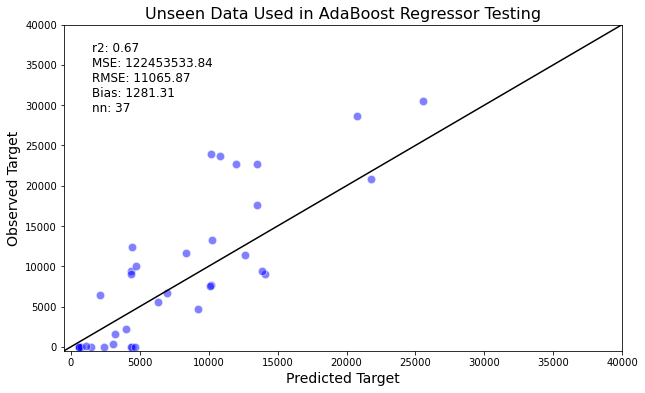

plot output:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_sel_12_data.JPG
Using:  adb_all_data_sddv4_mean_MAE_abr_sel_12_model.pickle


In [120]:
plt.figure(figsize=(10, 6))
with open(pickle_file, 'rb') as f:
        rf = pickle.load(f)

        predicted = rf.predict(unseen_xdata)


r2 = round(rf.score(unseen_xdata, unseen_ydata),2)
mse = round(np.mean((unseen_ydata - rf.predict(unseen_xdata))** 2), 2)
rmse = round(np.sqrt(np.mean((predicted - unseen_ydata) ** 2)), 2)

bias = round(np.mean(unseen_ydata) - np.mean(predicted), 2)
var = round(explained_variance_score(unseen_ydata, predicted), 2)

# r2 = round(select_tree_model.score(X_2, y_2),2)
# mse = round(np.mean((y_2 - select_tree_model.predict(X_2))** 2), 2)
# rmse = round(np.sqrt(np.mean((y2_predict - y_2) ** 2)), 2)
# bias = round(np.mean(y_2) - np.mean(y2_predict), 2)
# var = round(explained_variance_score(y_2, y2_predict), 2)
print("rmse: ", rmse)
print("rmse2: ", rmse2)

# plot up predicted and observed data 
plt.scatter(predicted, unseen_ydata, s= 70, alpha=0.5, color='blue', edgecolors='w') #,s=8, c='b', marker='o')

# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500, 40000)
plt.ylim(-500, 40000)

# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Unseen Data Used in {model_name} Testing', fontsize=16)


# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nBias: {bias:.2f}\nnn: {len(unseen_ydata)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


# 1 for 1 line

fig = plt.figure(1)
plt.plot(x, y, color = 'black')
output_plot = os.path.join(output, "{0}_{1}_{2}_sel_{3}_data.JPG".format(var_, fac, mdl, str(sel_num)))
fig.savefig(output_plot,dpi=600)
plt.show()
print("plot output: ", output_plot)
print("Using: ", "{0}_{1}_{2}_sel_{3}_model.pickle".format(var_, fac, mdl, sel_num))

In [115]:
# Load the pickled model
import pickle

with open(pickle_file, 'rb') as file:
    model = pickle.load(file)

# Load the dataset
import pandas as pd

# unseen x data
data = unseen_xdata

# Check the feature names used during training
training_feature_names = model.feature_names_in_

# Check the feature names in the new dataset
new_feature_names = data.columns

print("Training feature names:", training_feature_names)
print("New feature names:", new_feature_names)

Training feature names: ['b2_dbifm_dry_mean' 'b1_hmc_mean' 'b1_h99_mean' 'dbifmdry_CVI'
 'b1_dbifm_dry_mean' 'b1_hcv_mean' 'b6_dbifm_dry_mean' 'dbifmdry_NBR'
 'b3_dbifm_dry_mean' 'dbifmdry_r43' 'dbifmdry_MSR' 'dbifmdry_r42']
New feature names: Index(['b2_dbifm_dry_mean', 'b1_hmc_mean', 'b1_h99_mean', 'dbifmdry_CVI',
       'b1_dbifm_dry_mean', 'b1_hcv_mean', 'b6_dbifm_dry_mean', 'dbifmdry_NBR',
       'b3_dbifm_dry_mean', 'dbifmdry_r43', 'dbifmdry_MSR', 'dbifmdry_r42'],
      dtype='object')


# Adjust to export model with no feature names

In [116]:
xarray = X_1.to_numpy()
yarray = y_1

In [117]:
select_tree_model_no_headers = best_model.fit(xarray, yarray)

## Export selected model as pickle

In [118]:
import pickle

#rfrL8CHM = rfr()
#rfrL8CHM.fit(X_1, y_1)
pickle_file_no_headers = os.path.join(output, "{0}_{1}_{2}_sel_{3}_{4}_model_no_headers.pickle".format(var_, fac, mdl, sel_num, samp))
with open(pickle_file_no_headers, 'wb') as f:
    pickle.dump(select_tree_model_no_headers, f)
print("pickle saved: ", pickle_file_no_headers)

pickle saved:  C:\Users\robot\projects\biomass\model\adb_all_data_sddv4_mean\adb_all_data_sddv4_mean_MAE_abr_sel_12_all_data_model_no_headers.pickle


In [119]:
plt.close('all')